In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set directory to location of OULAD dataset in google drive

In [ ]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [ ]:
ls

all_f1.pdf            learning_behaviour_f1.pdf
all_npv.pdf           learning_behaviour_npv.pdf
anonymisedOUDataSet/  pass_fail_rate_modules.pdf
Deadline/             performance_f1.pdf
demographic_f1.pdf    performance_npv.pdf
demographic_npv.pdf   StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [ ]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# Module EEE

## Setup

### Load dataset and remove column features that are not used in module

In [ ]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_EEE_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # pass course = 0 | fail course = 1
  temp['final_result'] = temp['final_result'].replace({1:1, 2:0, 3:0})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
df[0].final_result.value_counts()

0    1400
1     348
Name: final_result, dtype: int64

In [ ]:
df[0].final_result.value_counts()

0    1400
1     348
Name: final_result, dtype: int64

In [ ]:
df[0].code_presentation.value_counts()

2014J    705
2013J    612
2014B    431
Name: code_presentation, dtype: int64

## Helper functions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [ ]:
def plot_confusion_matrix(result):
  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [ ]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare(deadline_list,result,labels,title):
  for i in range(len(result)):
    result[i] = np.array(result[i])
    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=result[i][:,1],marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("F1 Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare_npv(deadline_list,result,labels,title):
 
  for i in range(len(result)):   
    npv = []

    for j in result[i][:,4]:
      tn, fp, fn, tp = j.ravel()

      # Prevent zero division error
      if fn == 0:
        npv.append(0)
      else:
        npv.append(tn/(tn+fn))

    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Negative Predictive Value")
  plt_days.set_title(title)

In [ ]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [ ]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [ ]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [ ]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [ ]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [ ]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [ ]:
df[0].columns

Index(['code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'dualpane', 'forumng',
       'homepage', 'oucollaborate', 'oucontent', 'page', 'quiz', 'resource',
       'subpage', 'url', 'mean_click'],
      dtype='object')

In [ ]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [ ]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Feature correlation
 

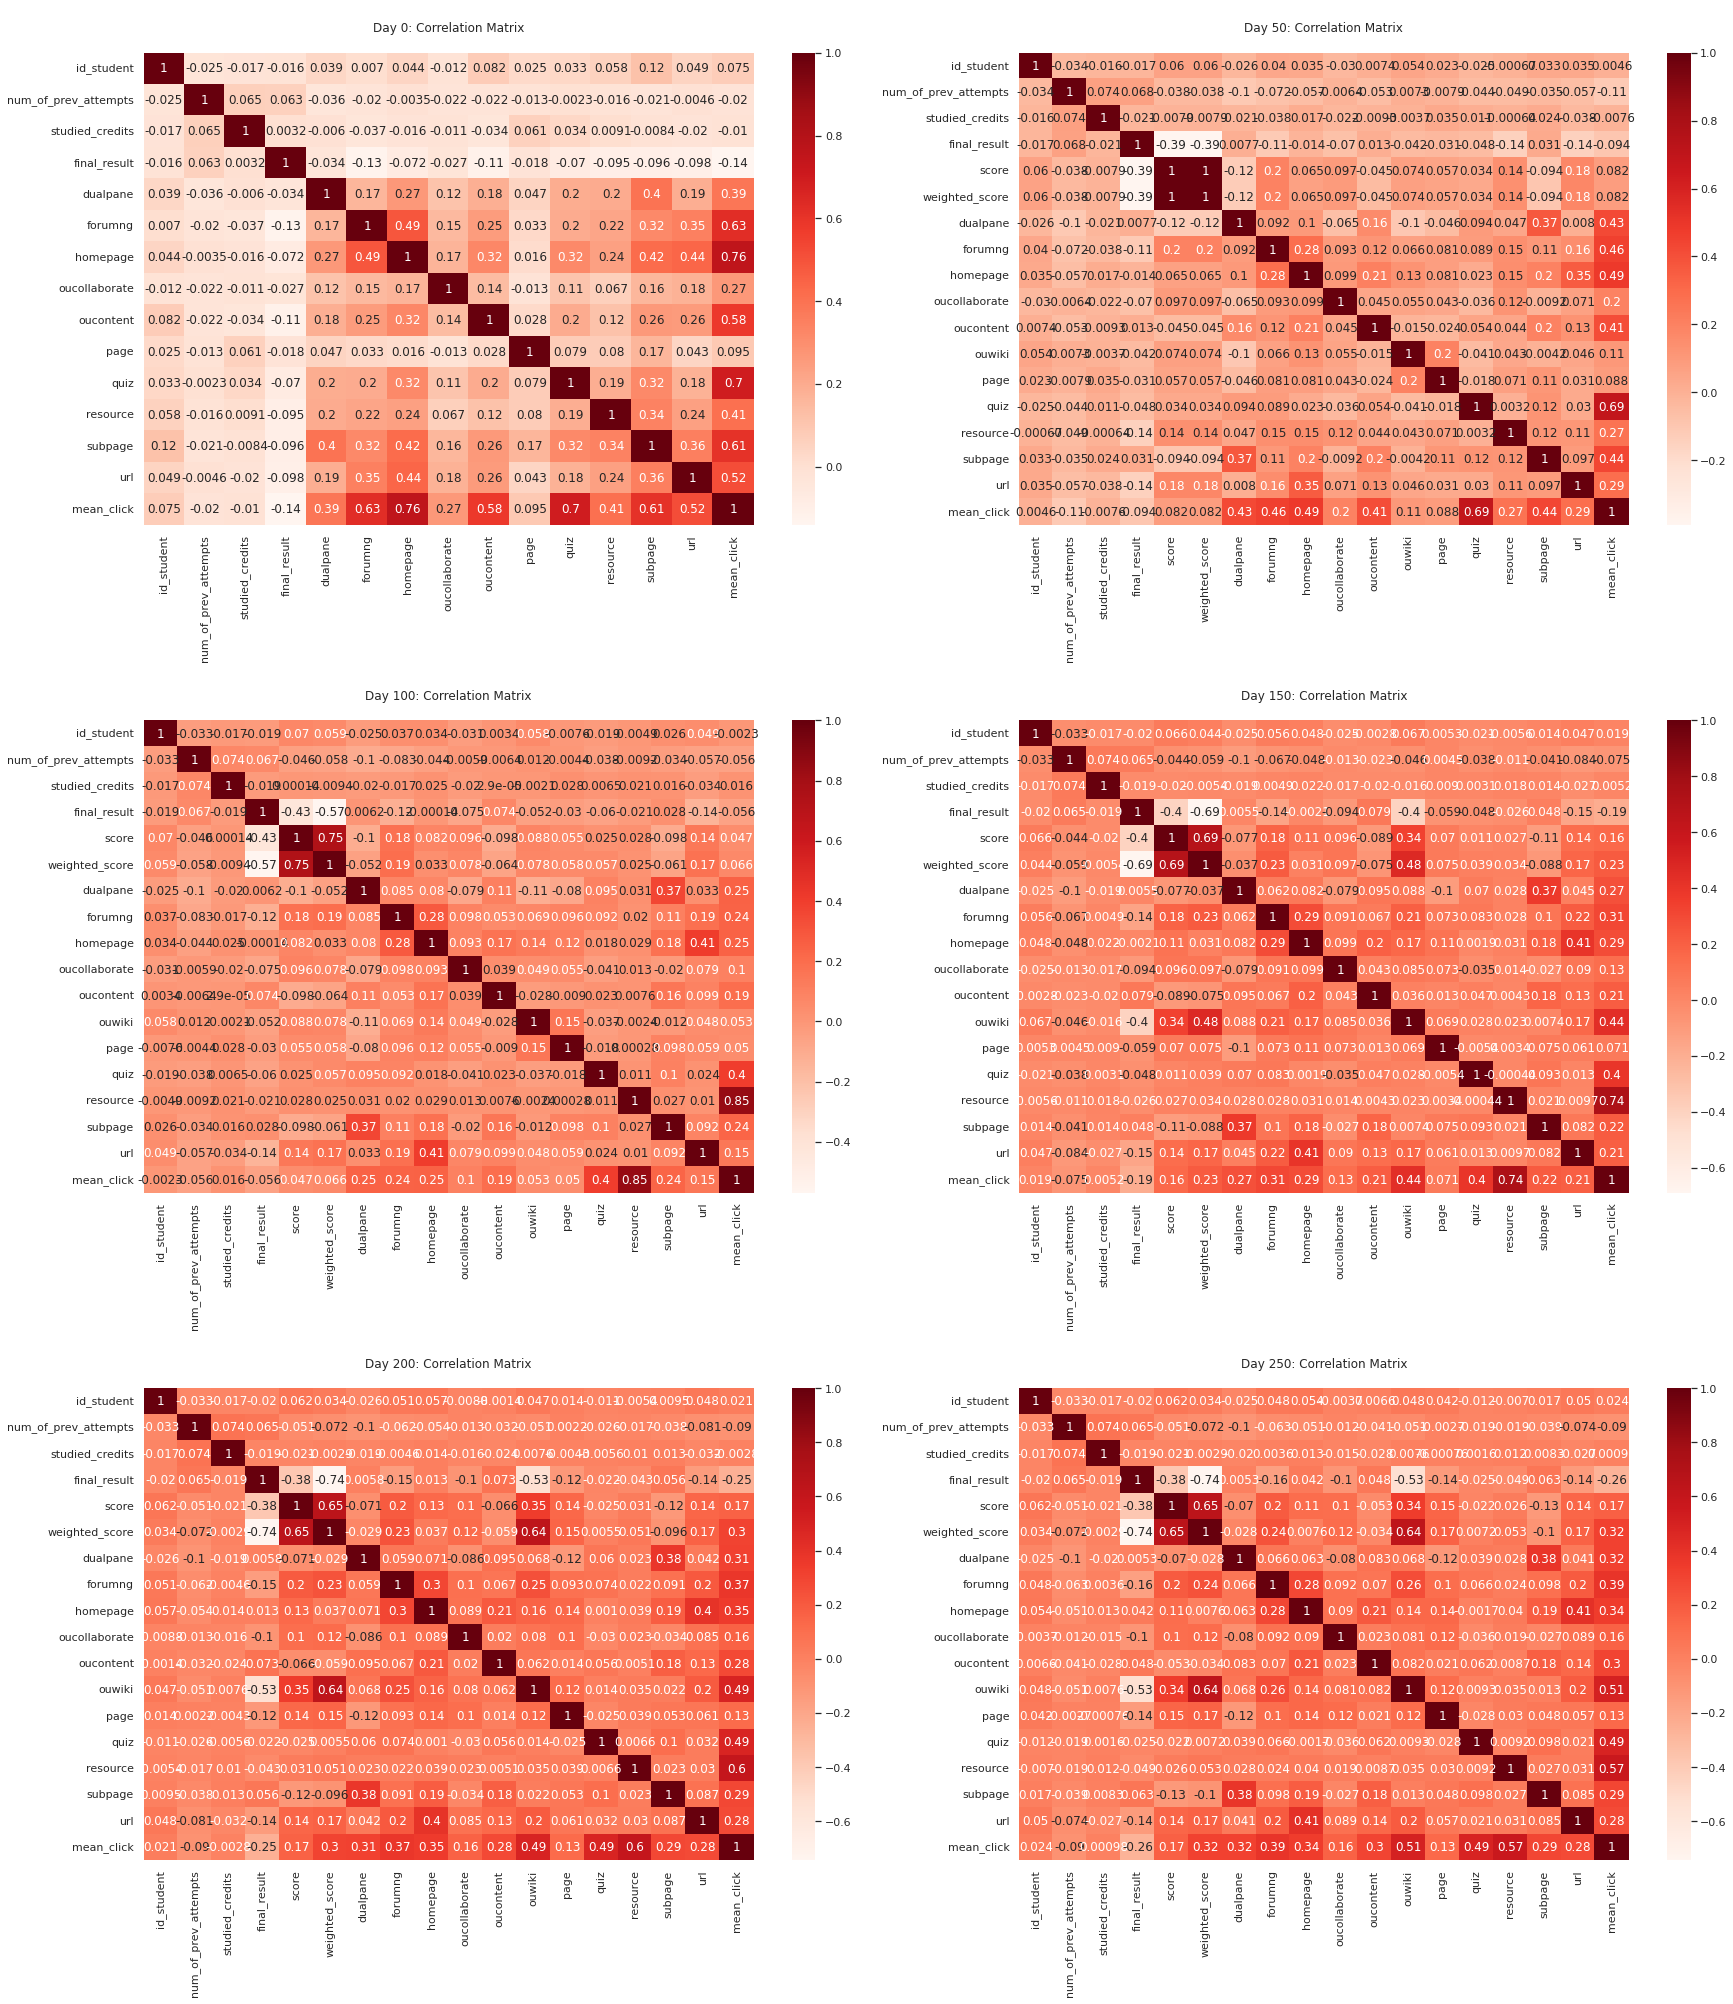

In [ ]:
plot_correlation_matrix(df)

## Make predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [ ]:
demographic_df = {}
for i in df.keys():
  demographic_df[i] = split_dataframe_by_data_type(df[i], ['demographic'], include_final_result=True)

In [ ]:
demographic_df[0].head()

code_presentation  id_student gender             region   highest_education  \
0             2013J       26915      M              Wales  Lower Than A Level   
1             2013J       35355      M              Wales  Lower Than A Level   
2             2013J       42638      M           Scotland    HE Qualification   
3             2013J       43564      M           Scotland    HE Qualification   
4             2013J       63112      M  South East Region  Lower Than A Level   

  imd_band age_band disability  final_result  
0    0-10%    35-55          N             1  
1    0-10%    35-55          N             0  
2  90-100%    35-55          N             0  
3   80-90%    35-55          N             0  
4   80-90%    35-55          N             0

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(demographic_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')


In [ ]:
X_train[0].shape

(612, 35)

###### Undersampling

In [ ]:
Y_train[0].value_counts()

0    495
1    117
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 495, 1: 117})
Resample dataset shape Counter({0: 117, 1: 117})
Sampling for day 50
Original dataset shape: Counter({0: 567, 1: 140})
Resample dataset shape Counter({0: 140, 1: 140})
Sampling for day 100
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 150
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 200
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 250
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
4    0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
704  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
705  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
706  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
707  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
708  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      14   15   16   17   18   19  
0    0.0  0.0  0.0  1.0  0.0  0.0  
1    0.0  1.0  0.0  1.0  0.0  0.0  
2    1.0  0.0  0.0  1.0  0.0  0.0  
3    0.0  0.0  1.0  0.0  0.0  0.0  
4    1.0  0.0  0.0  1.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  
704  0.0  0.0  1.0  0.0  0.0  0.0  
705  0.0  1.0  1.0  0.0  0.0  0.0  
706  0.0  0.0  0.0  1.0  0.0  0.0  
707  0.0  0.0  0.0  1.0  0.0  0.0  
708  0.0  0.0  1.0  0.0  0.0  0.0  

[709 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

demographic_results_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_du.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.431
Best parameters set:
Accuracy: 0.475177304964539, F1 Score: 0.24489795918367346, Precision: 0.16260162601626016, Recall: 0.49586776859504134


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.432
Best parameters set:
Accuracy: 0.5197452229299363, F1 Score: 0.30825688073394497, Precision: 0.20537897310513448, Recall: 0.6176470588235294


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.448
Best parameters set:
Accuracy: 0.4879594423320659, F1 Score: 0.26277372262773724, Precision: 0.17518248175182483, Recall: 0.5255474452554745


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.44

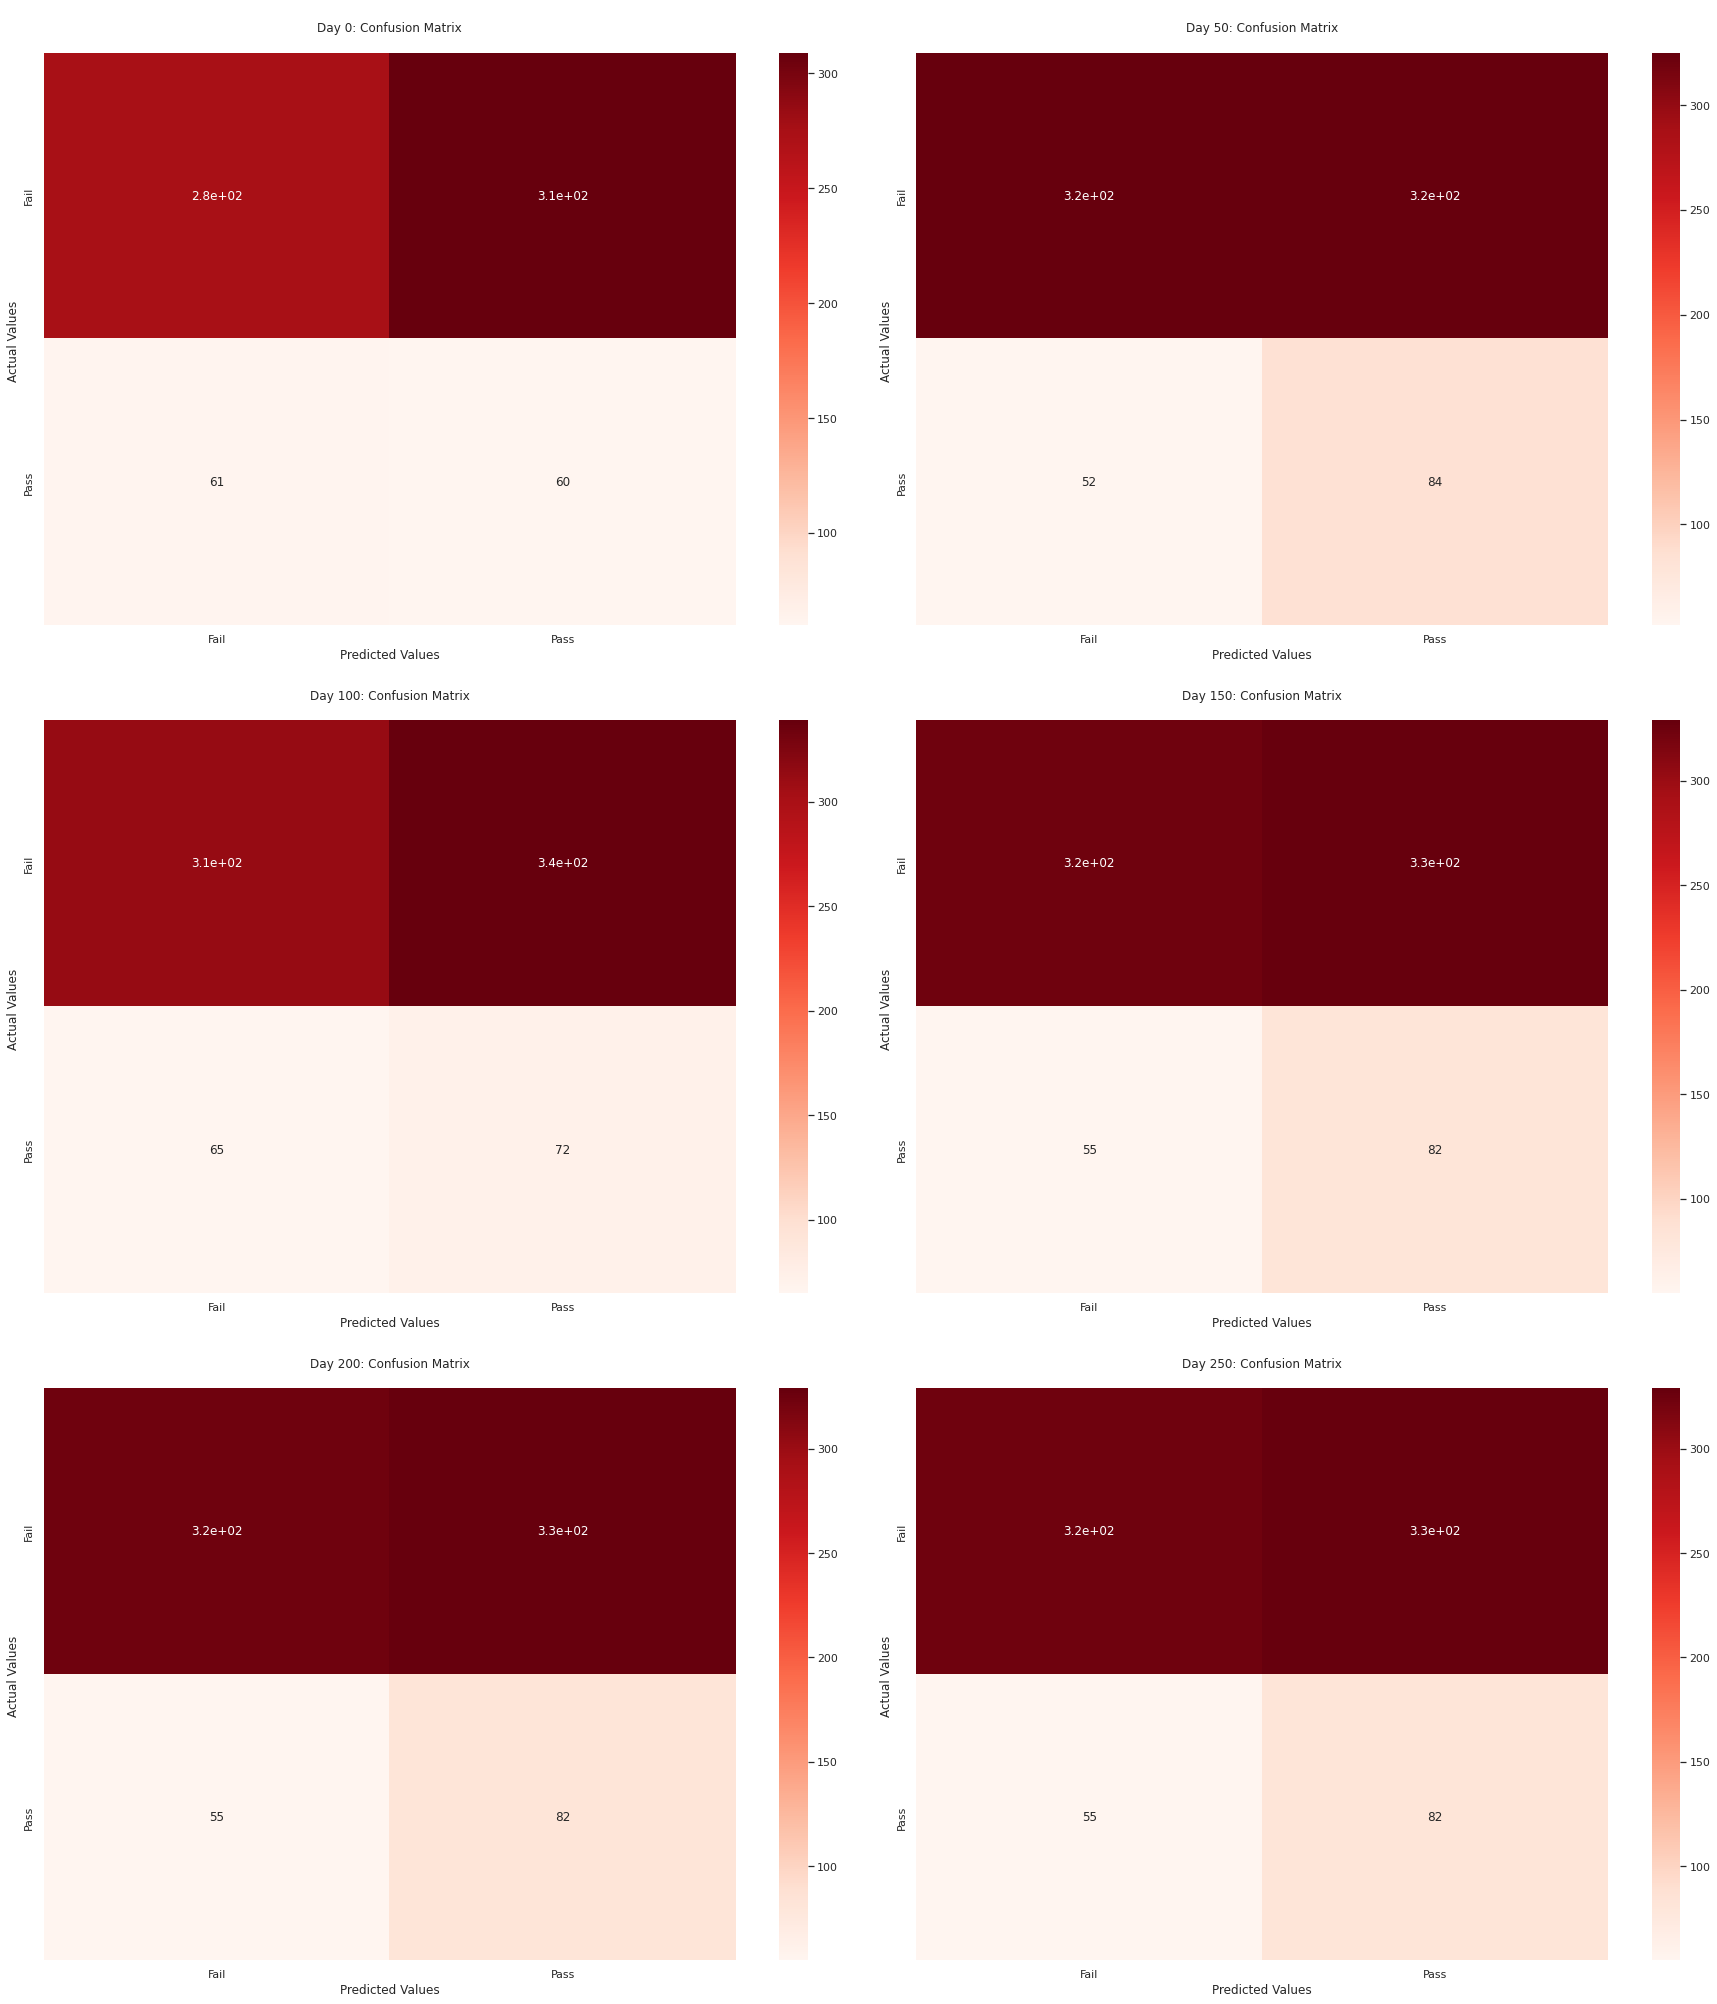

In [ ]:
plot_confusion_matrix(demographic_results_du)

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

demographic_results_nb = []

pipeline = Pipeline([
    ('clf', BernoulliNB(binarize=None)),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_nb.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.484
Best parameters set:
Accuracy: 0.8141843971631205, F1 Score: 0.02962962962962963, Precision: 0.14285714285714285, Recall: 0.01652892561983471


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.482
Best parameters set:
Accuracy: 0.8203821656050956, F1 Score: 0.06622516556291391, Precision: 0.3333333333333333, Recall: 0.03676470588235294


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.475
Best parameters set:
Accuracy: 0.8212927756653993, F1 Score: 0.05369127516778523, Precision: 0.3333333333333333, Recall: 0.029197080291970802


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.

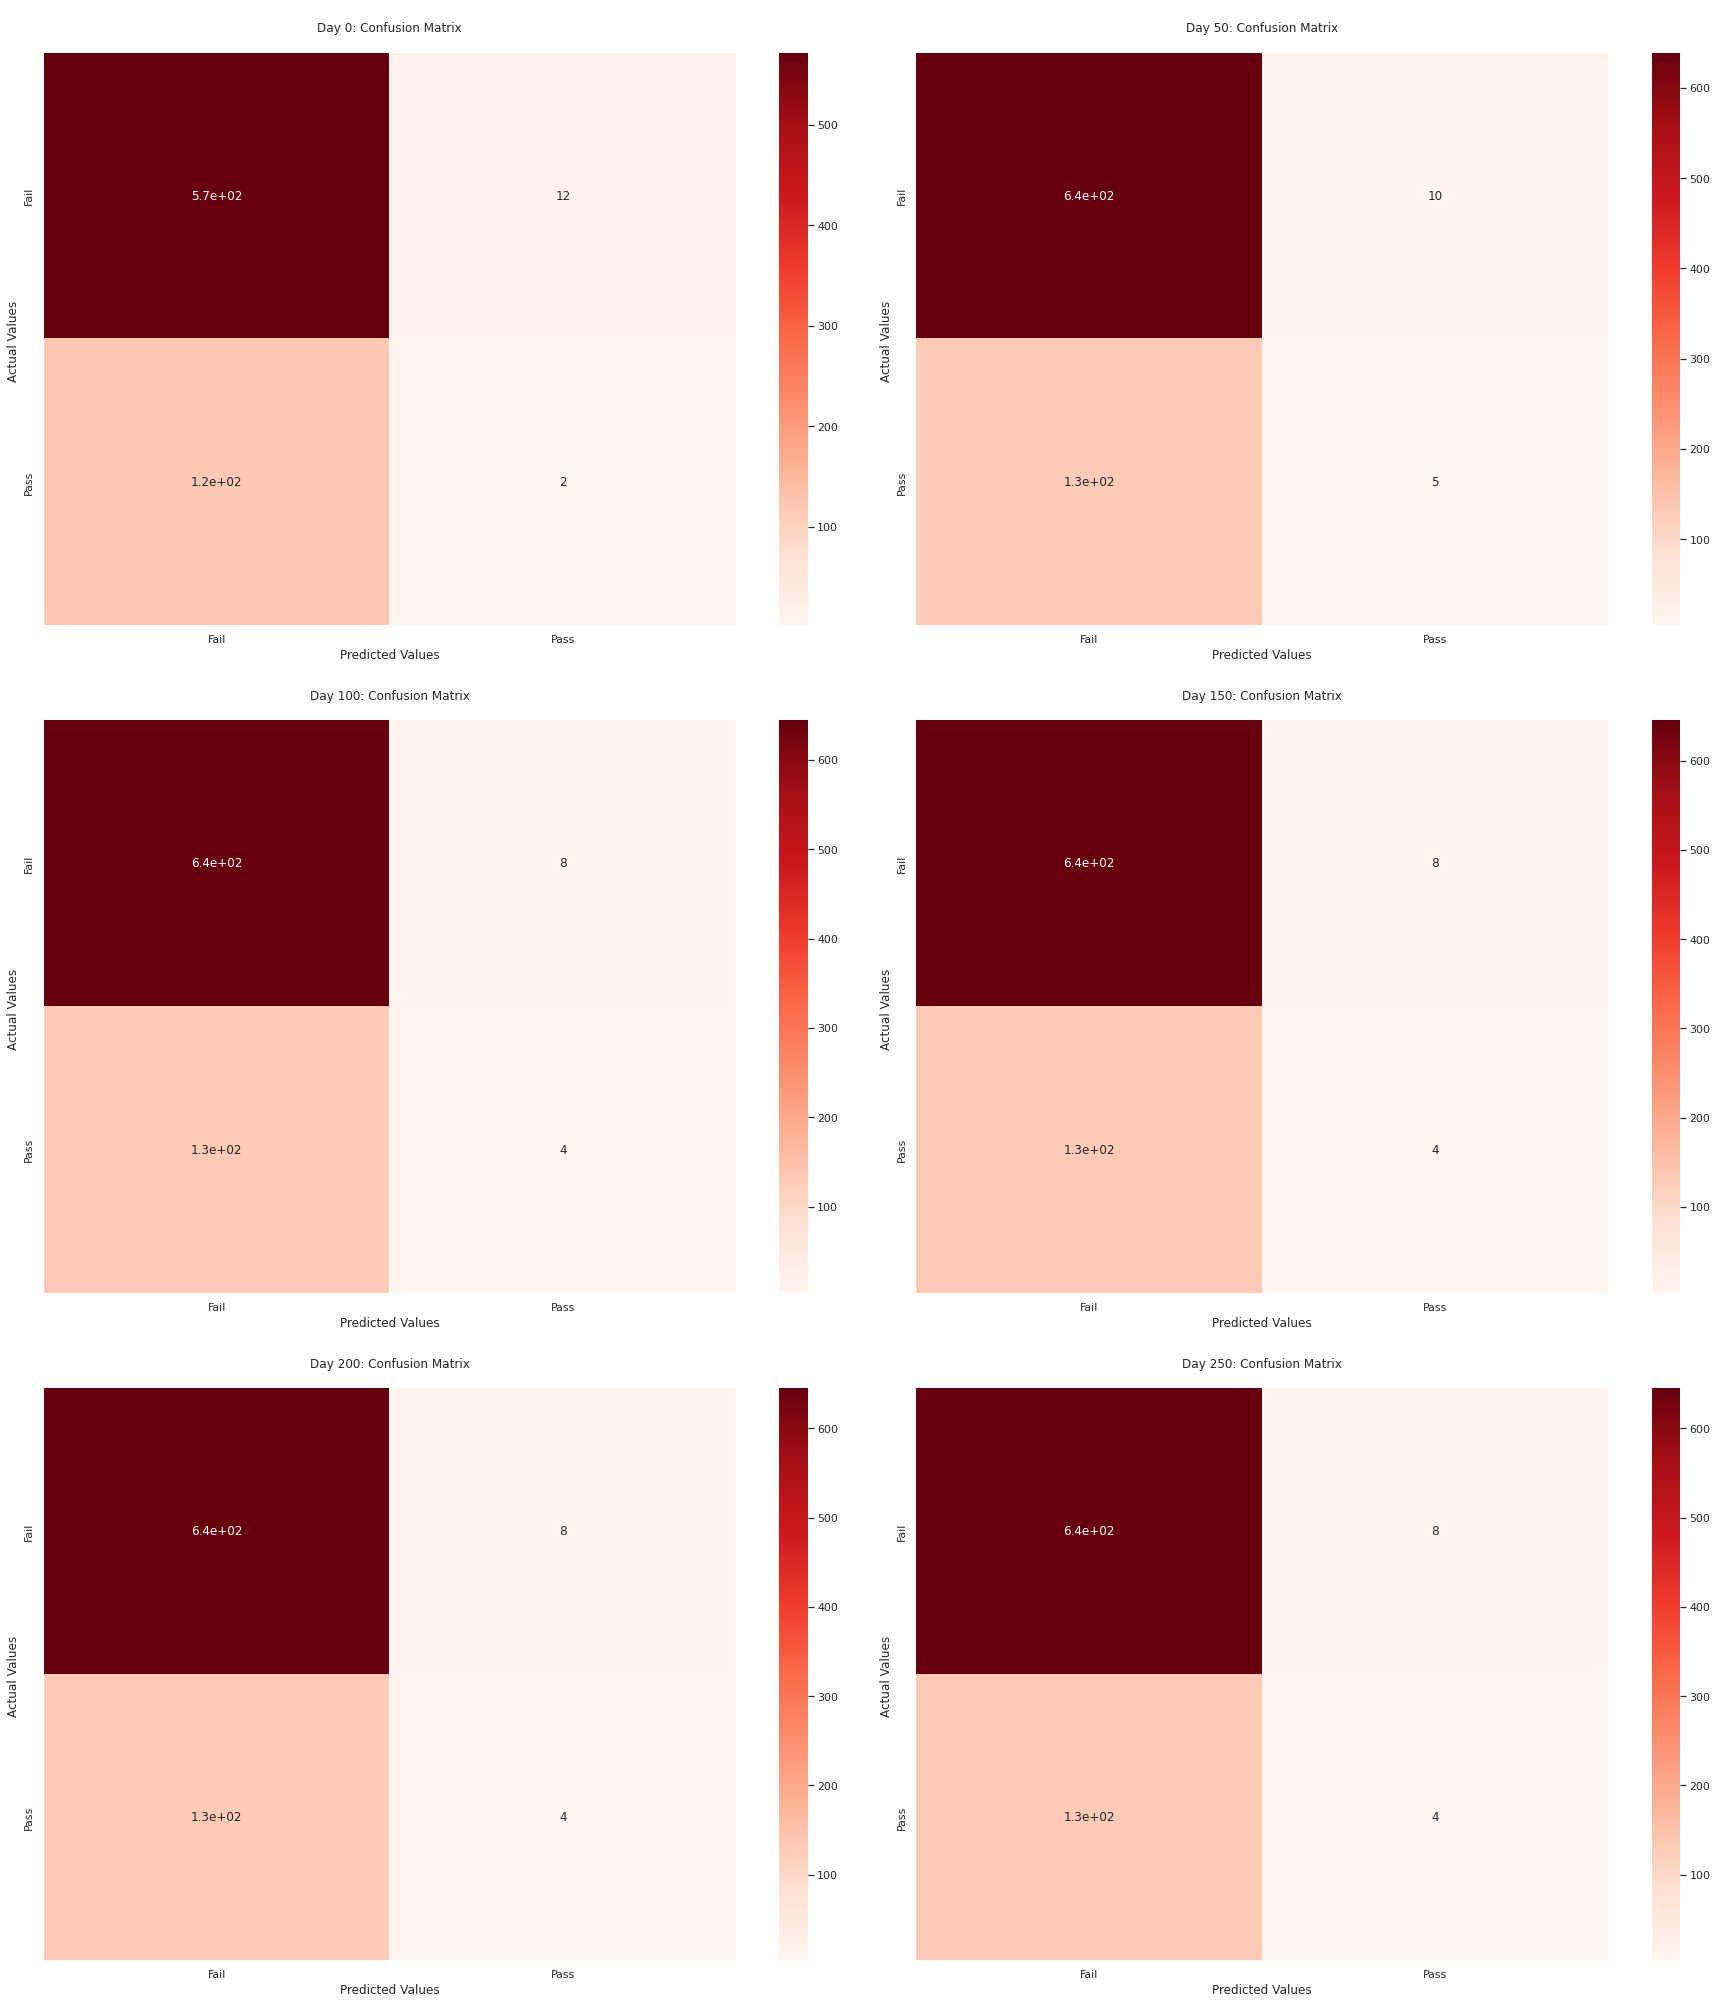

In [ ]:
plot_confusion_matrix(demographic_results_nb)

##### LogisticRegression

ovr is used for binary problems

In [ ]:
from sklearn.linear_model import LogisticRegression

demographic_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr')),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lr.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.463
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8283687943262411, F1 Score: 0.0, Precision: 0.0, Recall: 0.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))





Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.459
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.824203821656051, F1 Score: 0.014285714285714287, Precision: 0.25, Recall: 0.007352941176470588


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.458
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8250950570342205, F1 Score: 0.014285714285714285, Precision: 0.3333333333333333, Recall: 0.0072992700729927005


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.458
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8253164556962025, F1 Score: 0.014285714285714285, Precision: 0.3333333333333333, Recall: 0.0072992700

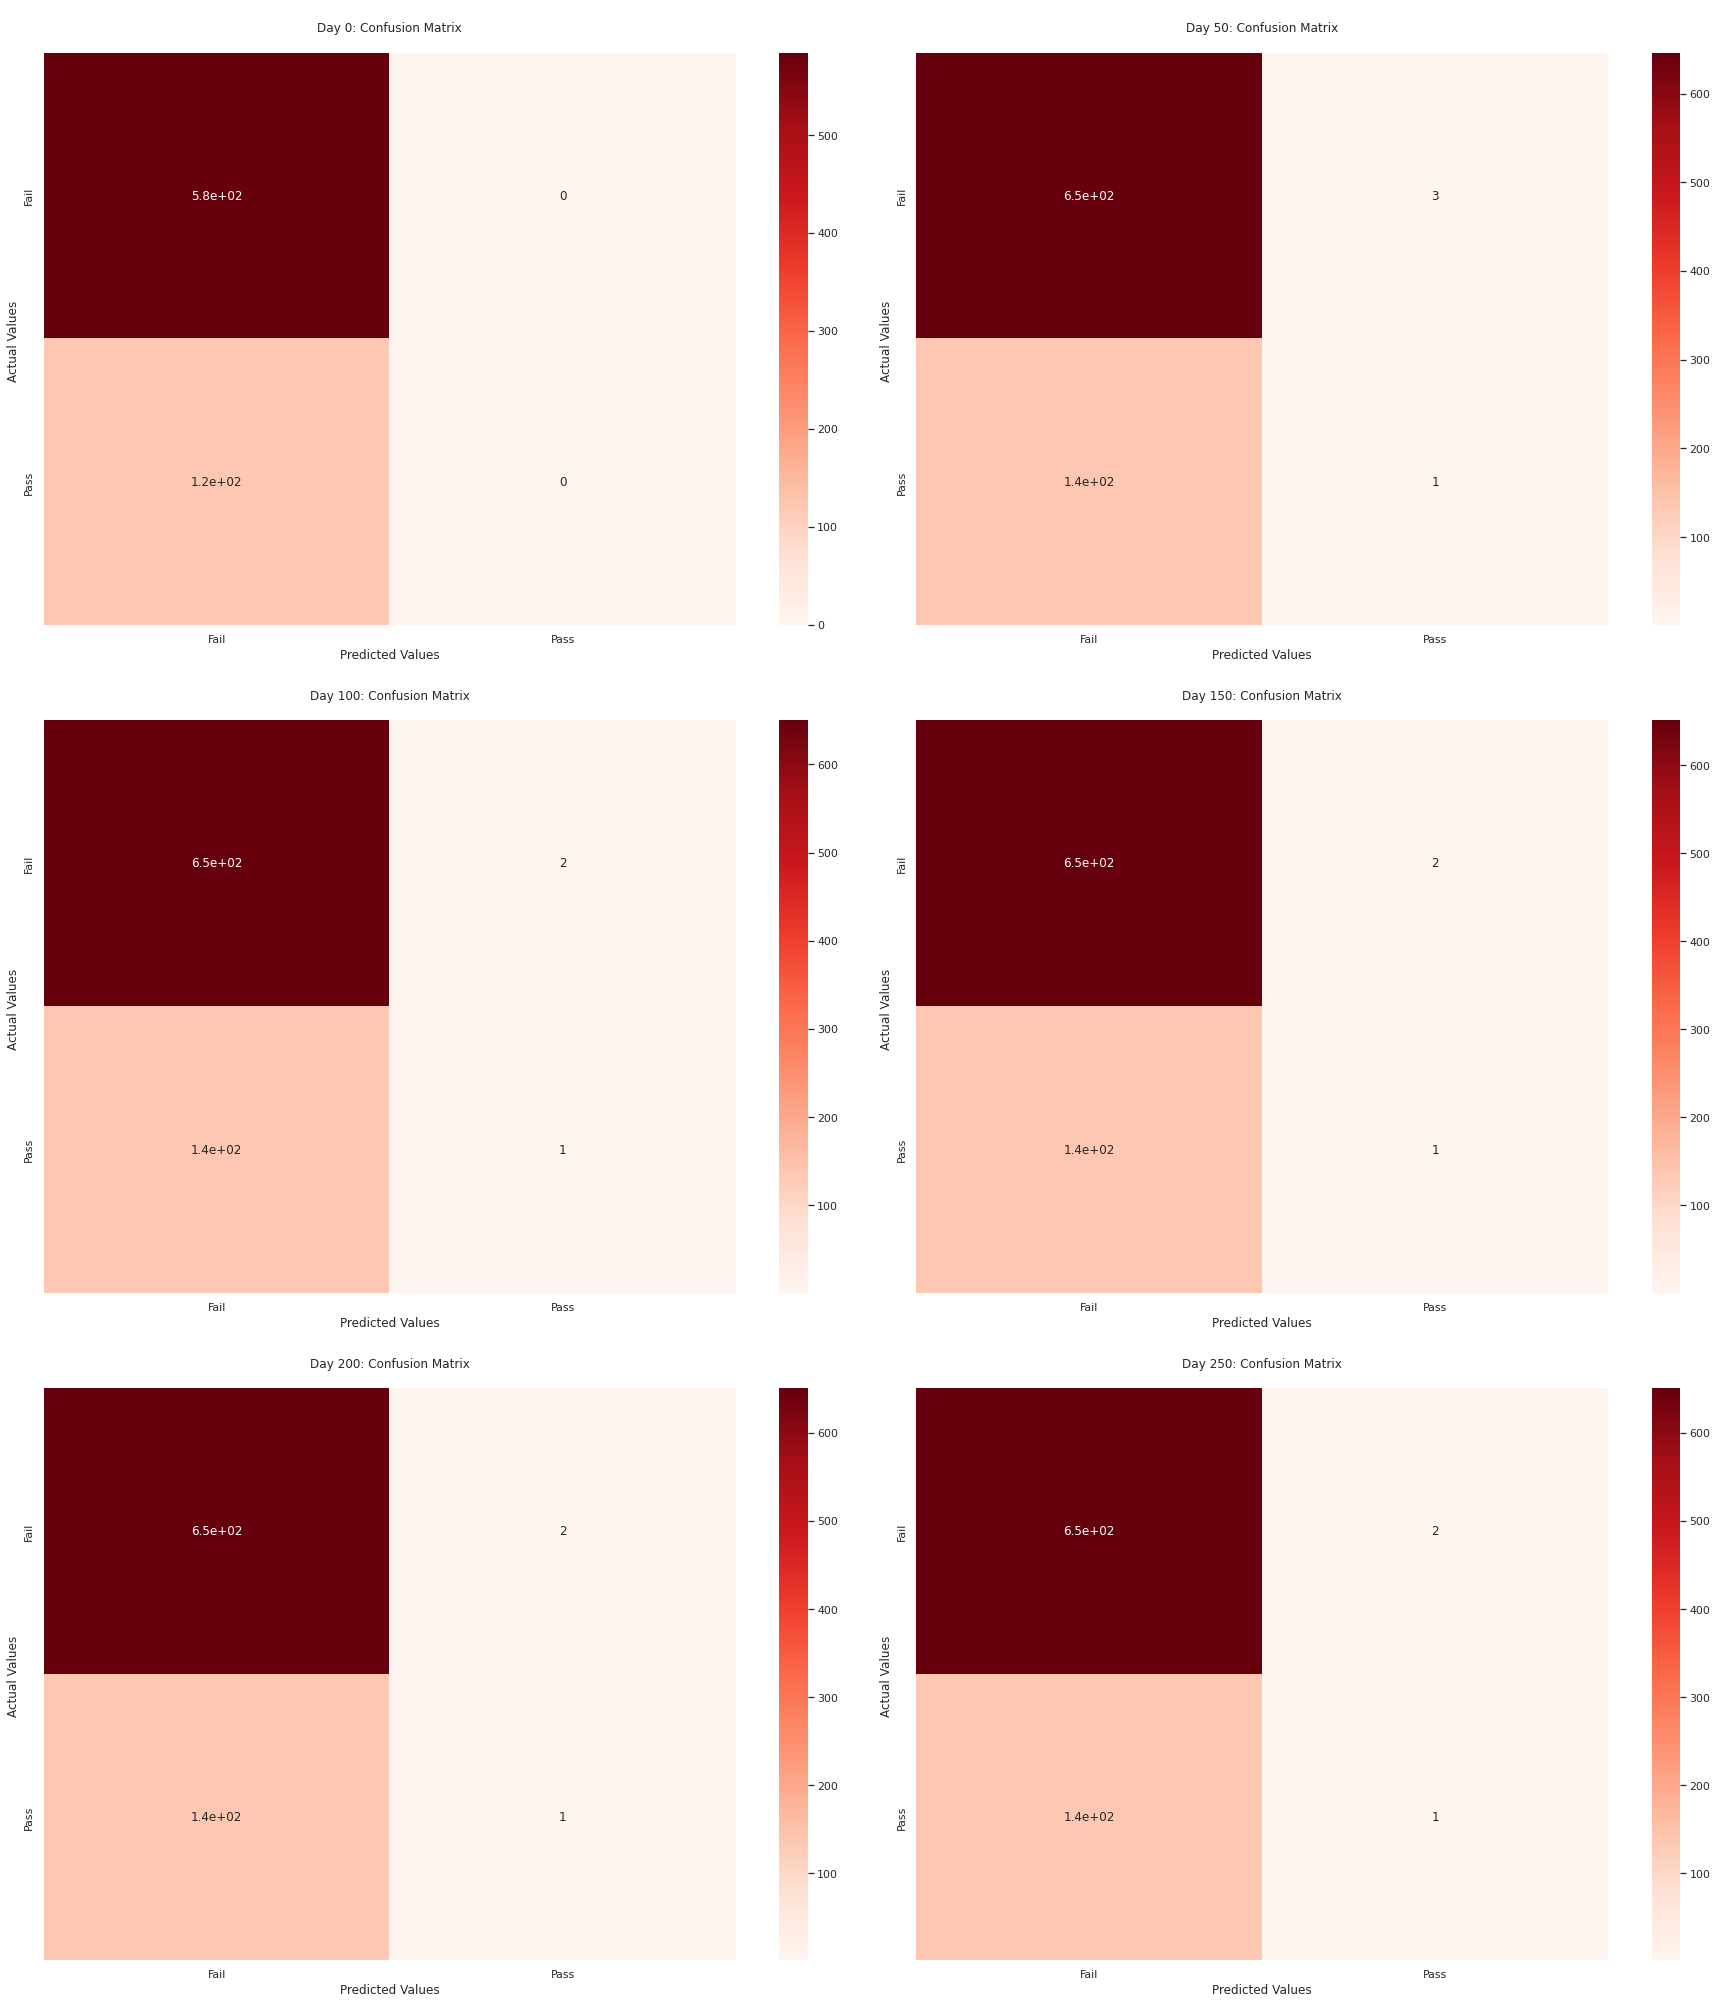

In [ ]:
plot_confusion_matrix(demographic_results_lr)

##### WeightedLogisticRegression

In [ ]:
demographic_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.508
Best parameters set:
Accuracy: 0.5673758865248227, F1 Score: 0.30523917995444194, Precision: 0.21069182389937108, Recall: 0.5537190082644629


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.518
Best parameters set:
Accuracy: 0.5732484076433121, F1 Score: 0.2795698924731183, Precision: 0.19756838905775076, Recall: 0.47794117647058826


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.509
Best parameters set:
Accuracy: 0.5868187579214195, F1 Score: 0.2943722943722944, Precision: 0.20923076923076922, Recall: 0.49635036496350365


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.50

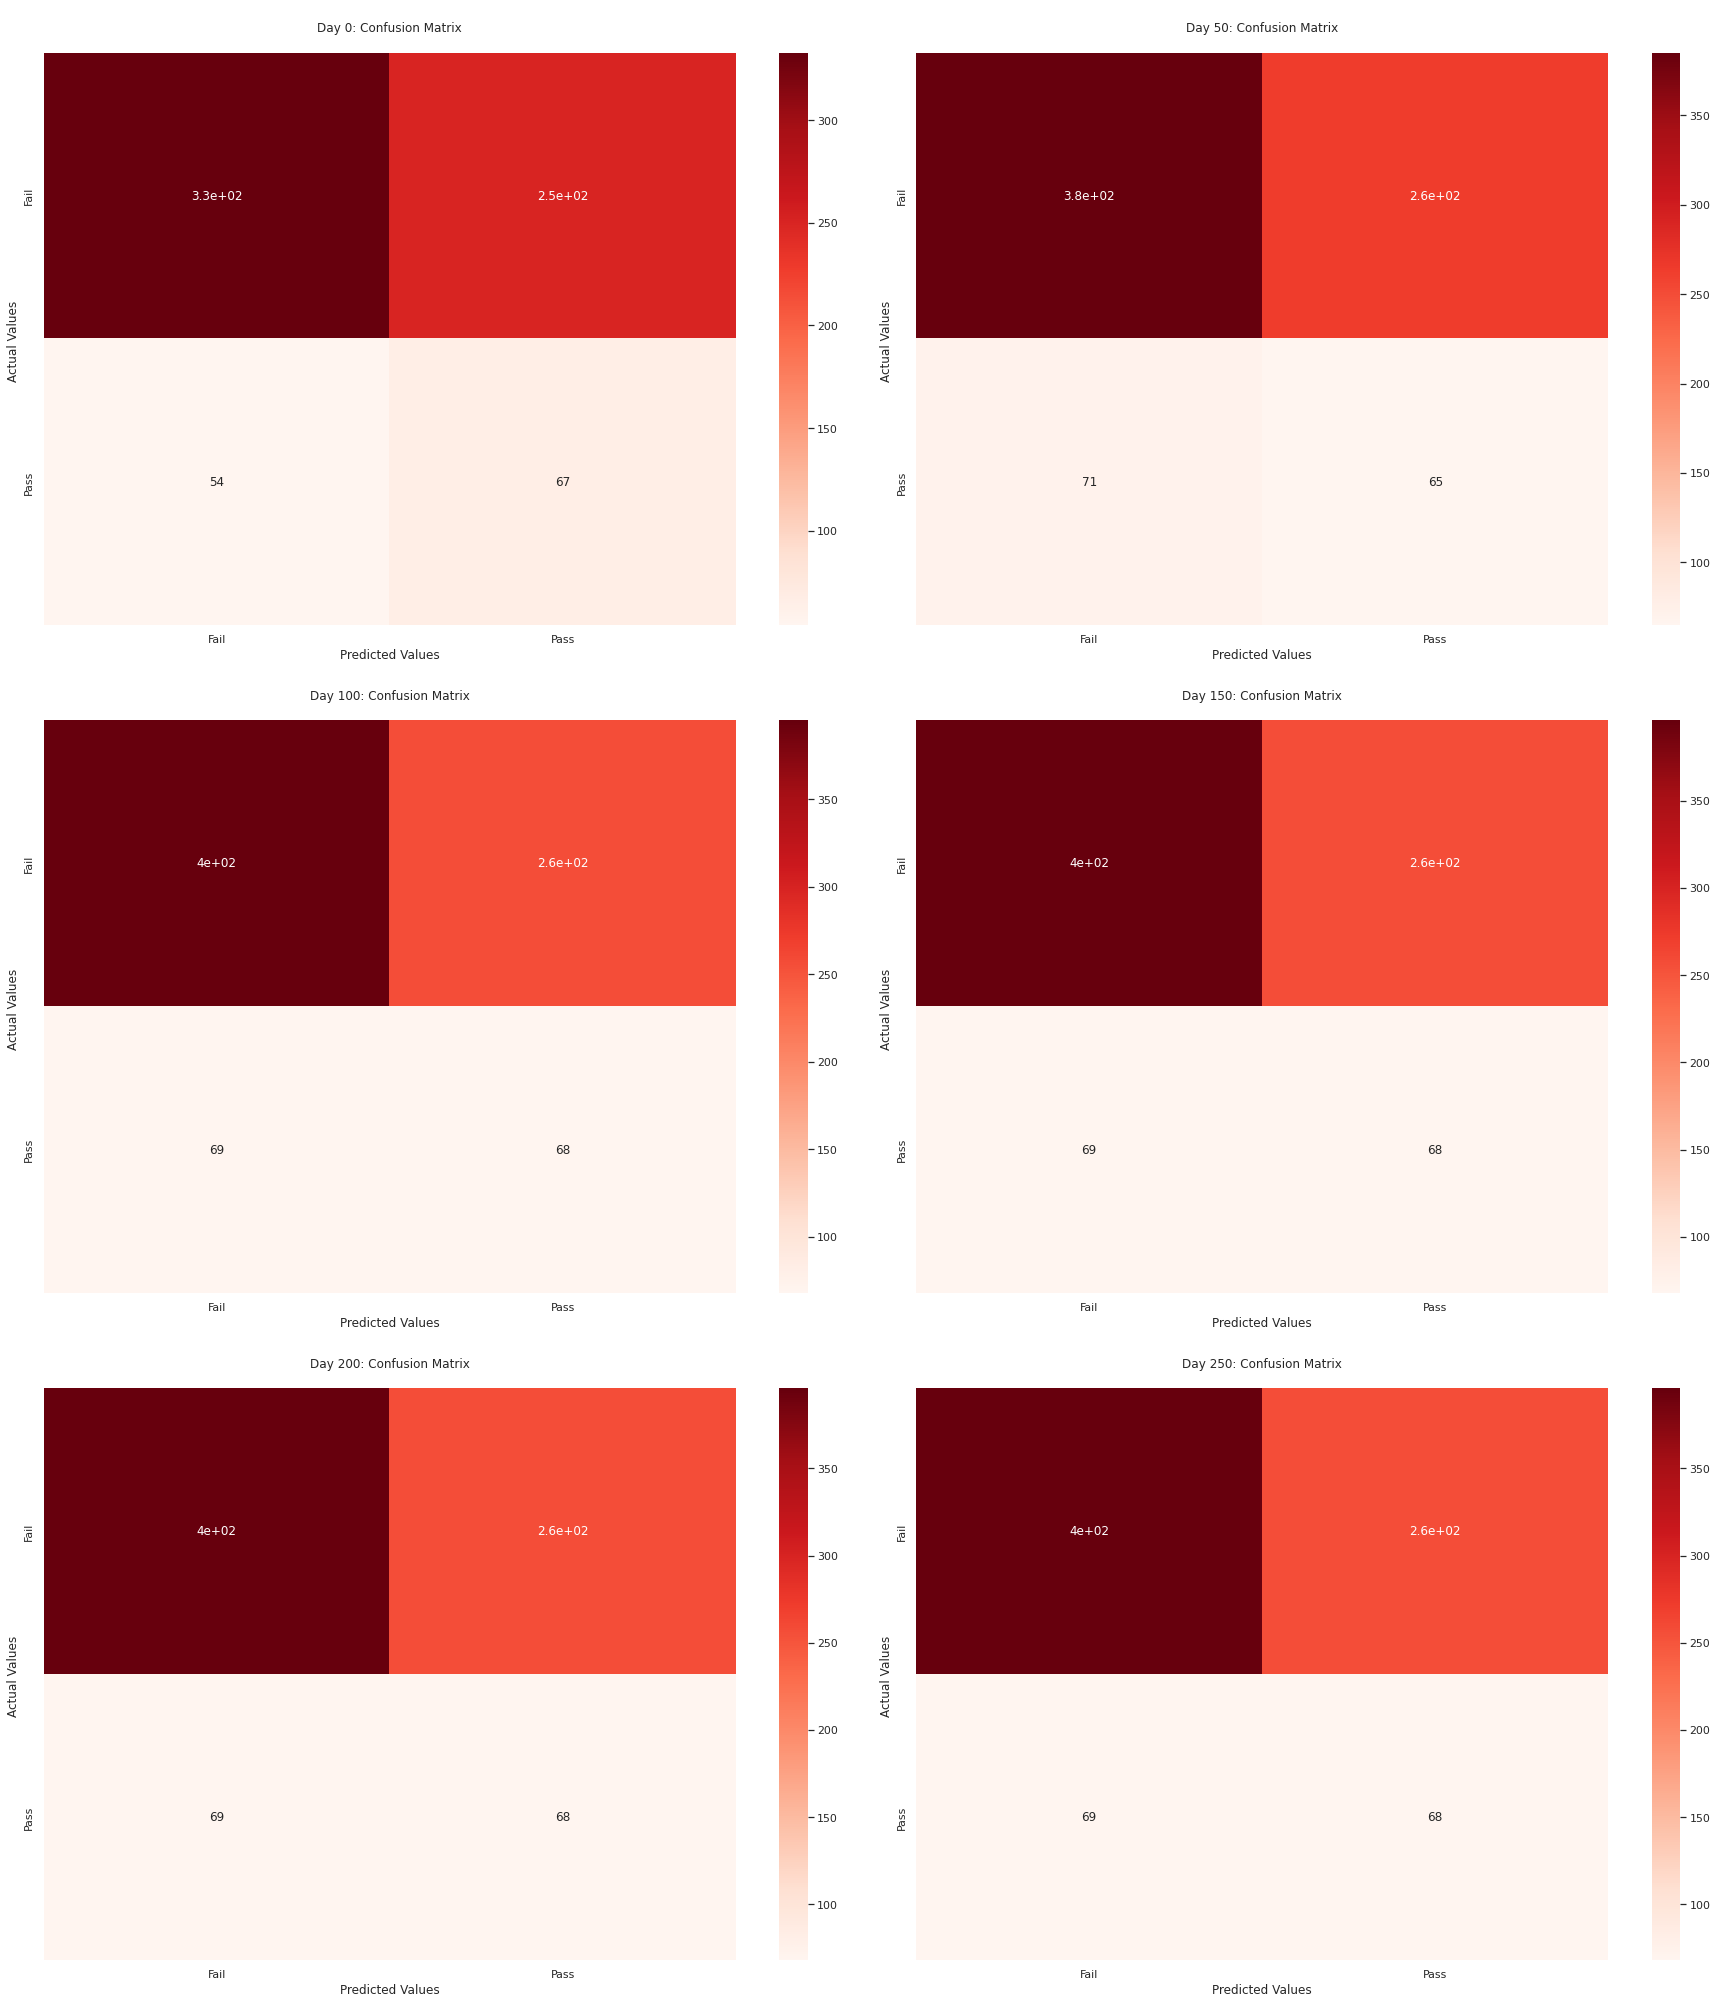

In [ ]:
plot_confusion_matrix(demographic_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

demographic_results_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_rf.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.557
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.5985815602836879, F1 Score: 0.2762148337595908, Precision: 0.2, Recall: 0.4462809917355372


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.506
Best parameters set:
	clf__n_estimators: 70
Accuracy: 0.6624203821656051, F1 Score: 0.2042042042042042, Precision: 0.17258883248730963, Recall: 0.25


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.531
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.65525982256

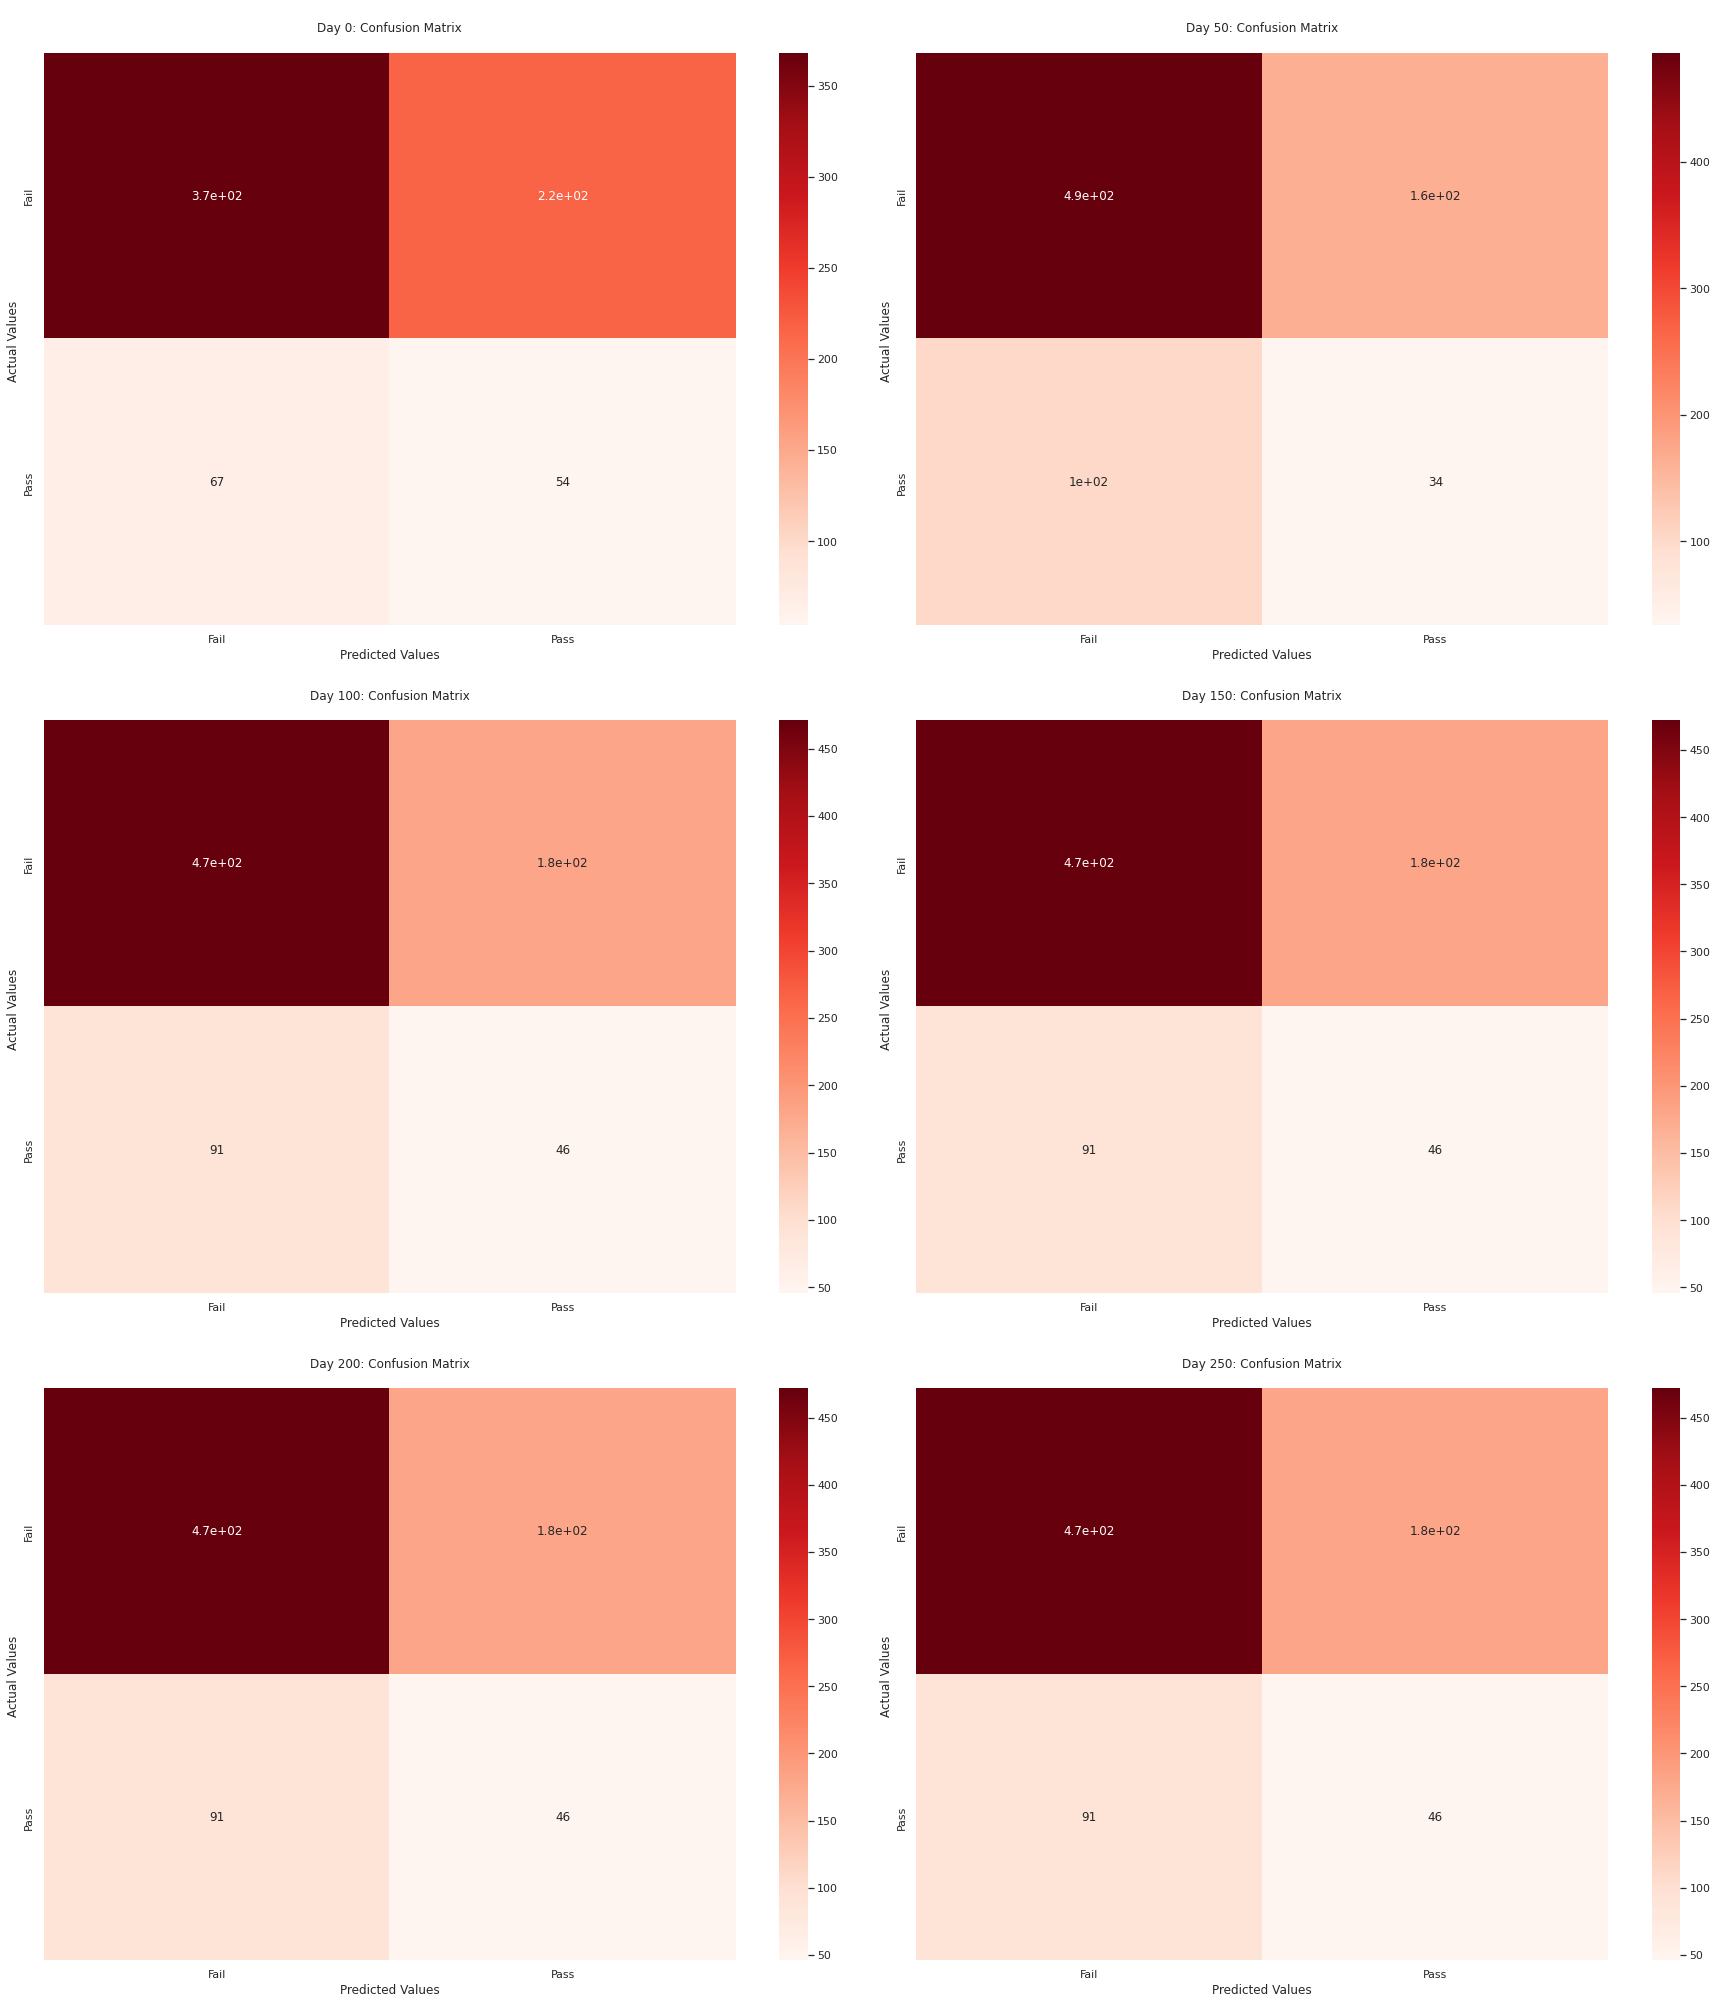

In [ ]:
plot_confusion_matrix(demographic_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

demographic_results_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_ab.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.464
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.825531914893617, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.451
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.8254777070063695, F1 Score: 0.014388489208633096, Precision: 0.3333333333333333, Recall: 0.007352941176470588


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.464
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.8238276299112801, F1 Score: 0.04137931034482759, Precision:

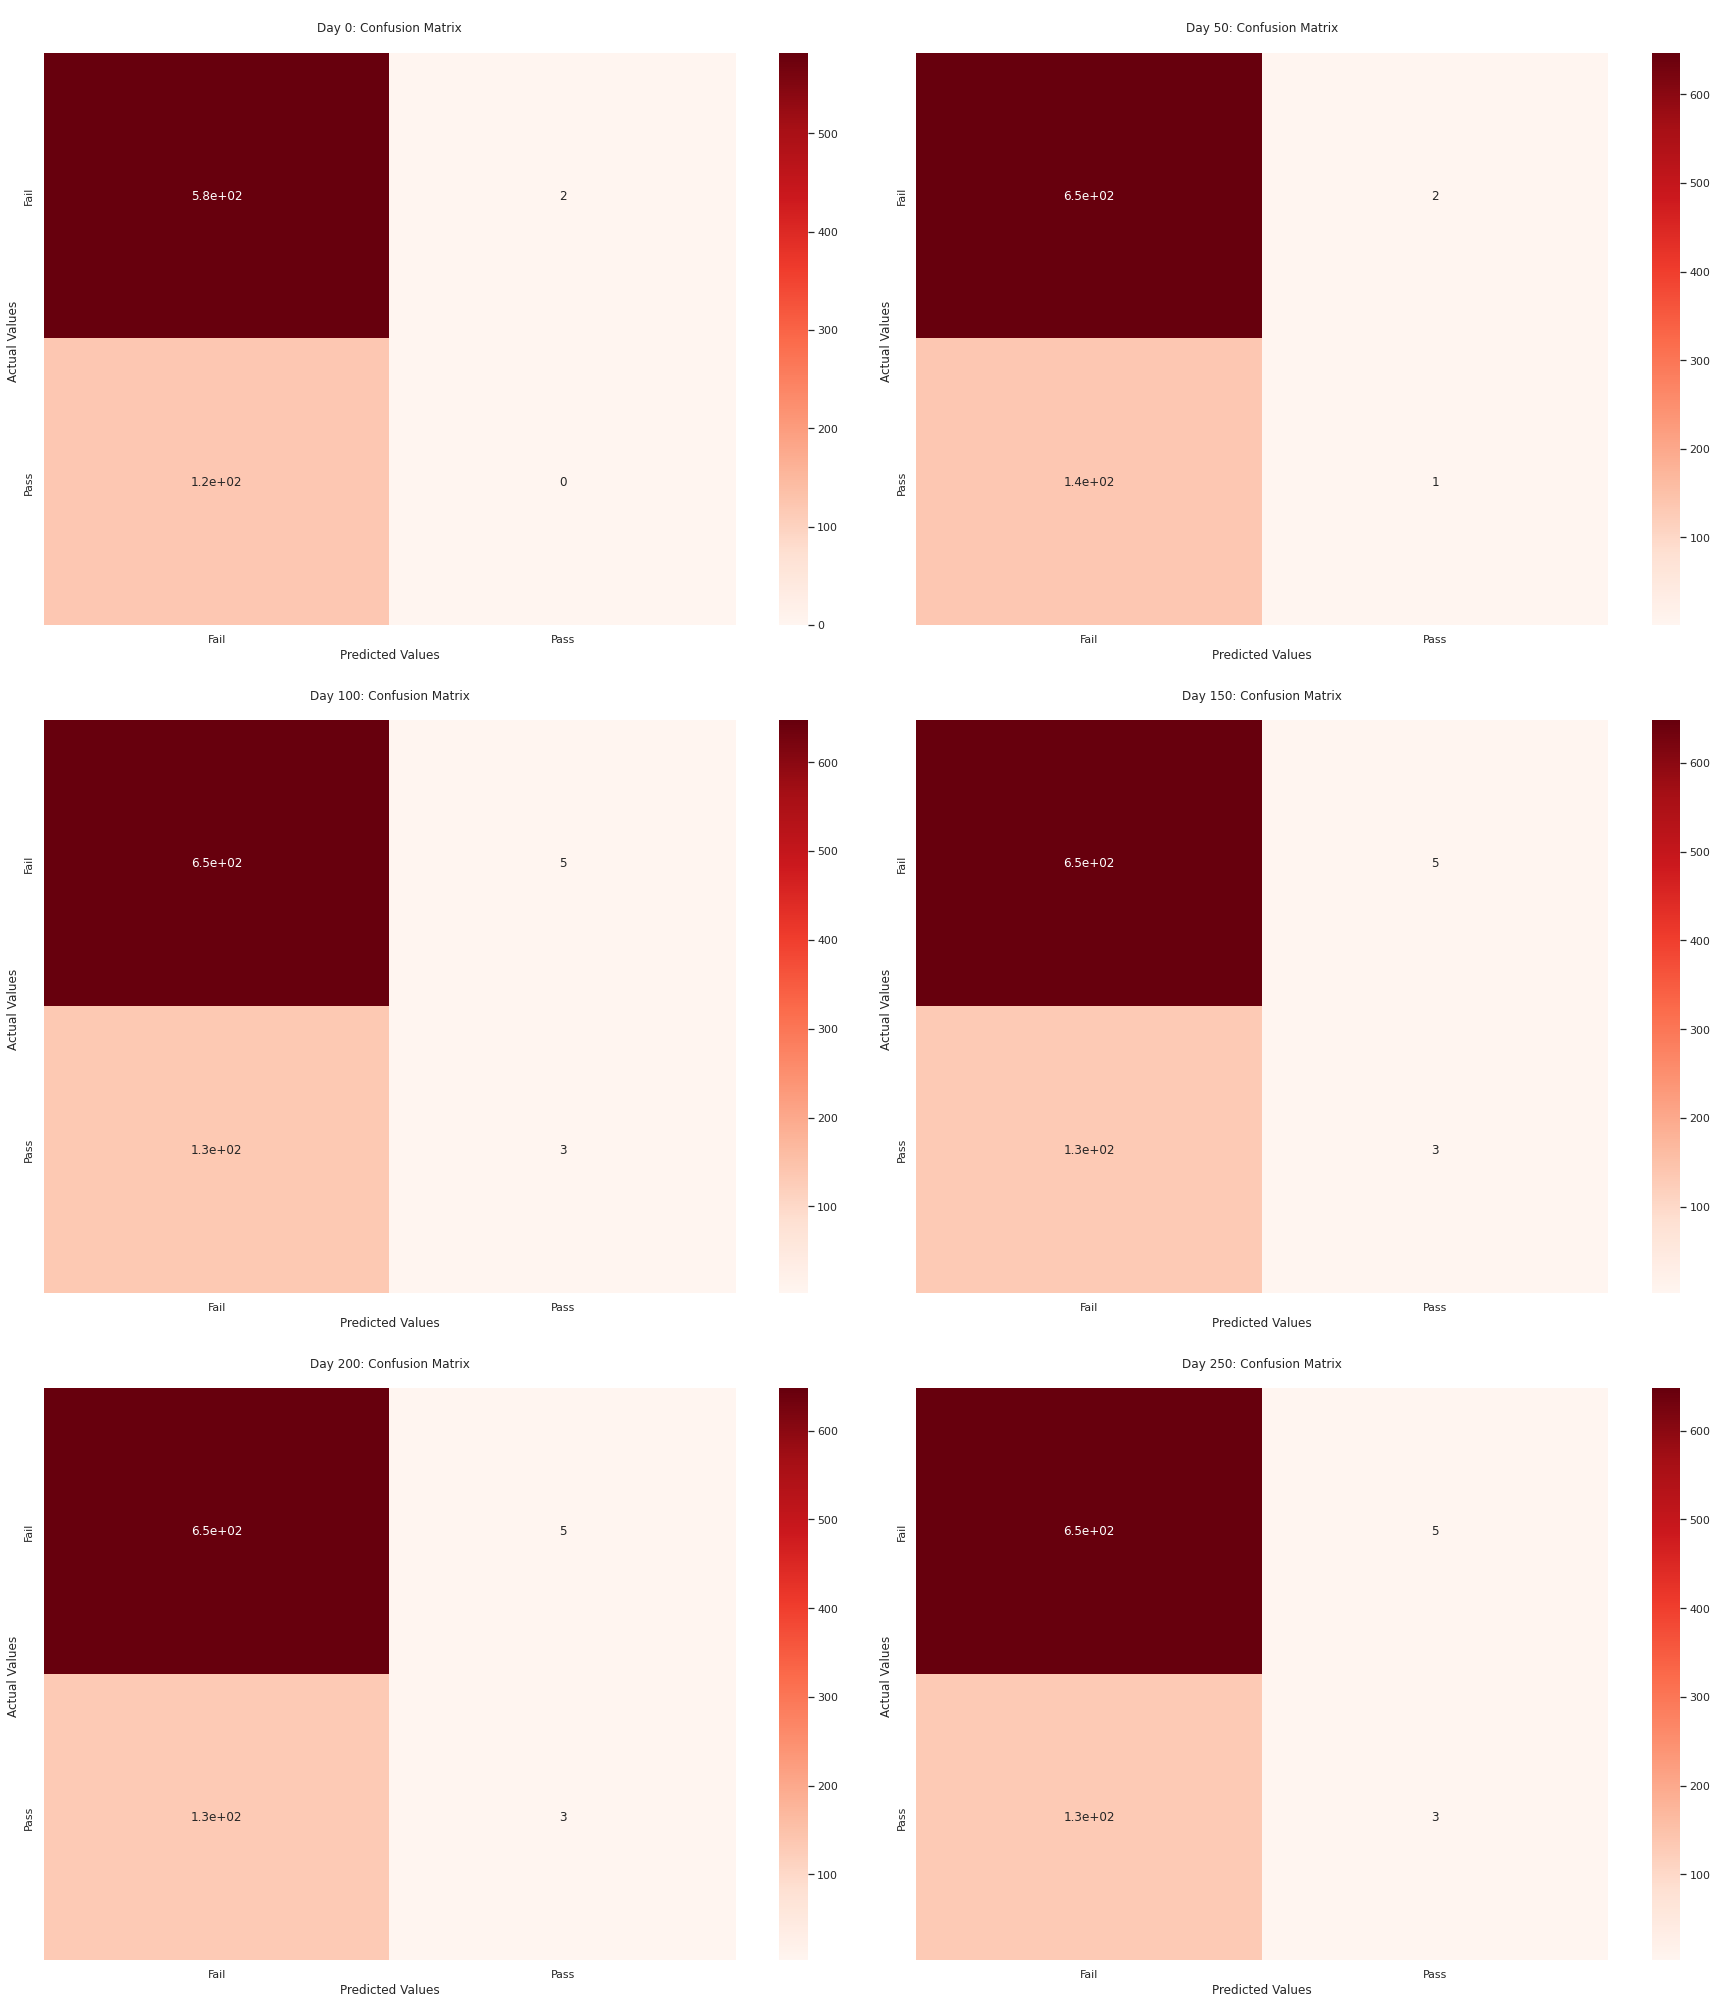

In [ ]:
plot_confusion_matrix(demographic_results_ab)

##### Plot results overview

In [ ]:
demographic_classifier_results = [demographic_results_du, demographic_results_nb, demographic_results_lr, demographic_results_lrw, demographic_results_rf, demographic_results_ab]
demographic_classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

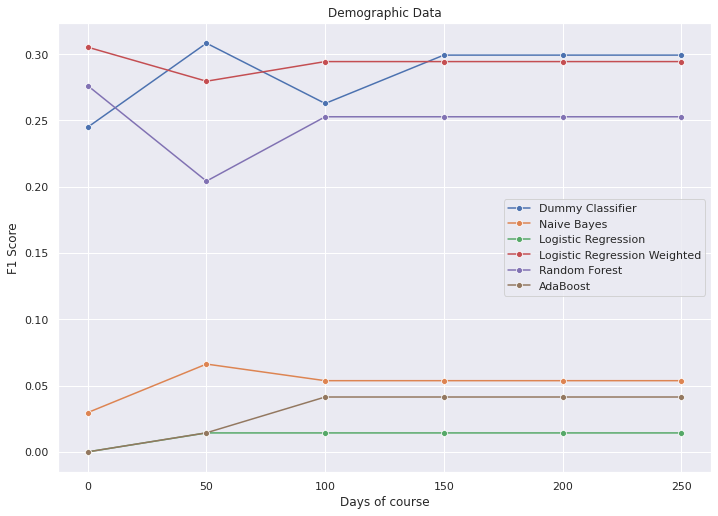

In [ ]:
plot_days_compare(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

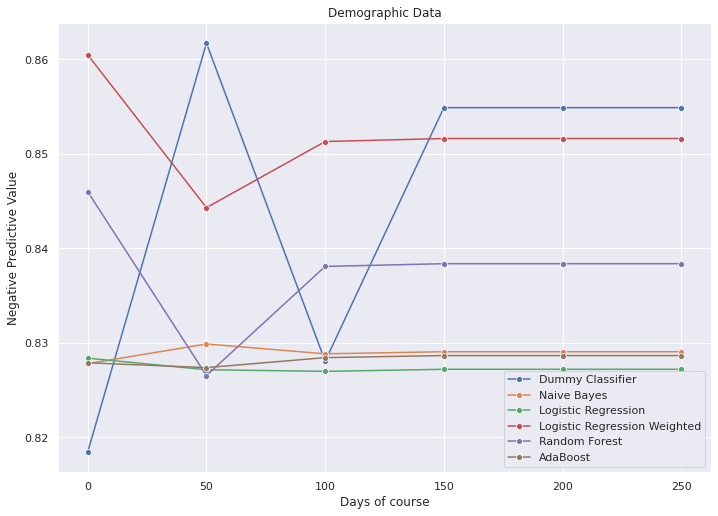

In [ ]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

#### Learning behaviour data

##### Prepare data for prediction

In [ ]:
learning_behaviour_df = {}
for i in df.keys():
  learning_behaviour_df[i] = split_dataframe_by_data_type(df[i], ['learning_behaviour'], include_final_result=True)

In [ ]:
learning_behaviour_df[0]

code_presentation  id_student  dualpane   forumng  oucontent   homepage  \
0                2013J       26915       0.0  2.600000   3.000000   2.333333   
1                2013J       35355       0.0  4.000000   5.500000   5.000000   
2                2013J       42638       1.0  3.843750   7.866667  11.625000   
3                2013J       43564       0.0  3.142857   6.714286   3.333333   
4                2013J       63112       0.0  3.500000   4.833333   1.500000   
...                ...         ...       ...       ...        ...        ...   
1743             2014J     2644404       0.0  0.000000   0.000000   1.000000   
1744             2014J     2654928       0.0  2.888889   2.888889   5.666667   
1745             2014J     2663195       0.0  0.000000   5.000000   2.000000   
1746             2014J     2686053       0.0  1.400000   2.125000   2.375000   
1747             2014J     2686712       0.0  3.444444   4.333333   3.600000   

      quiz  oucollaborate  subpage  url  mean_click  page  resource  \
0      0.0            0.0      1.0  0.0    0.496296   0.0  0.000000   
1      1.0            0.0      1.0  1.0    0.972222   0.0  0.000000   
2      2.0            1.0      3.2  1.5    1.890856   0.0  2.000000   
3      0.0            0.0      2.0  1.0    0.955026   0.0  1.000000   
4      0.0            0.0      1.0  0.0    0.657407   0.0  1.000000   
...    ...            ...      ...  ...         ...   ...       ...   
1743   0.0            0.0      0.0  0.0    0.055556   0.0  0.000000   
1744   1.0            0.0      1.5  1.0    0.895062   0.0  1.166667   
1745   0.0            0.0      3.0  0.0    0.555556   0.0  0.000000   
1746   0.0            0.0      0.0  1.0    0.383333   0.0  0.000000   
1747   0.0            0.0      1.0  0.0    0.770988   0.0  1.500000   

      final_result  
0                1  
1                0  
2                0  
3                0  
4                0  
...            ...  
1743             0  
1744             0  
1745             0  
1746             0  
1747             1  

[1748 rows x 14 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(learning_behaviour_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['dualpane', 'forumng', 'oucontent', 'homepage', 'quiz', 'oucollaborate',
       'subpage', 'url', 'mean_click', 'resource'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'forumng', 'oucontent', 'homepage', 'quiz', 'oucollaborate',
       'subpage', 'url', 'mean_click', 'resource'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'forumng', 'oucontent', 'homepage', 'quiz', 'oucollaborate',
       'subpage', 'url', 'mean_click', 'resource'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'forumng', 'ouwiki', 'oucontent', 'homepage', 'quiz',
       'oucollaborate', 'subpage', 'url', 'mean_click', 'resource'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'forumng', 'ouwiki', 'oucontent', 'homepage', 'quiz',
       'oucollaborate', 'subpage', 'url', 'mean_click', 'page', 'resource'],
      dtype='object')
Index([], dtype='object') Index(['dualpane', 'forumng', 'ouwiki', 'oucon

###### Undersampling

In [ ]:
Y_train[0].value_counts()

0    495
1    117
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 495, 1: 117})
Resample dataset shape Counter({0: 117, 1: 117})
Sampling for day 50
Original dataset shape: Counter({0: 567, 1: 140})
Resample dataset shape Counter({0: 140, 1: 140})
Sampling for day 100
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 150
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 200
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 250
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train[i].index)
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test[i].index)

In [ ]:
X_train[250]

forumng    ouwiki      quiz   subpage  mean_click
0    0.282143  0.277846  0.452830  0.103448    0.095676
1    0.304085  0.490201  0.237371  0.141659    0.121984
2    0.344211  0.469626  0.432704  0.121511    0.121009
3    0.426316  0.400959  0.312668  0.141762    0.108041
4    0.710119  0.291155  0.388970  0.136163    0.130542
..        ...       ...       ...       ...         ...
704  0.166667  0.000000  0.540881  0.098522    0.080185
705  0.533582  0.556047  0.303774  0.145096    0.154009
706  0.458448  0.400959  0.395655  0.110345    0.148508
707  0.228571  0.312298  0.522013  0.142380    0.116919
708  0.618328  0.672482  0.363636  0.081505    0.131996

[709 rows x 5 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

learning_behaviour_results_du = []
learning_behaviour_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.431
Best parameters set:
Accuracy: 0.475177304964539, F1 Score: 0.24489795918367346, Precision: 0.16260162601626016, Recall: 0.49586776859504134


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.432
Best parameters set:
Accuracy: 0.5197452229299363, F1 Score: 0.30825688073394497, Precision: 0.20537897310513448, Recall: 0.6176470588235294


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.448
Best parameters set:
Accuracy: 0.4879594423320659, F1 Score: 0.26277372262773724, Precision: 0.17518248175182483, Recall: 0.5255474452554745


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.44

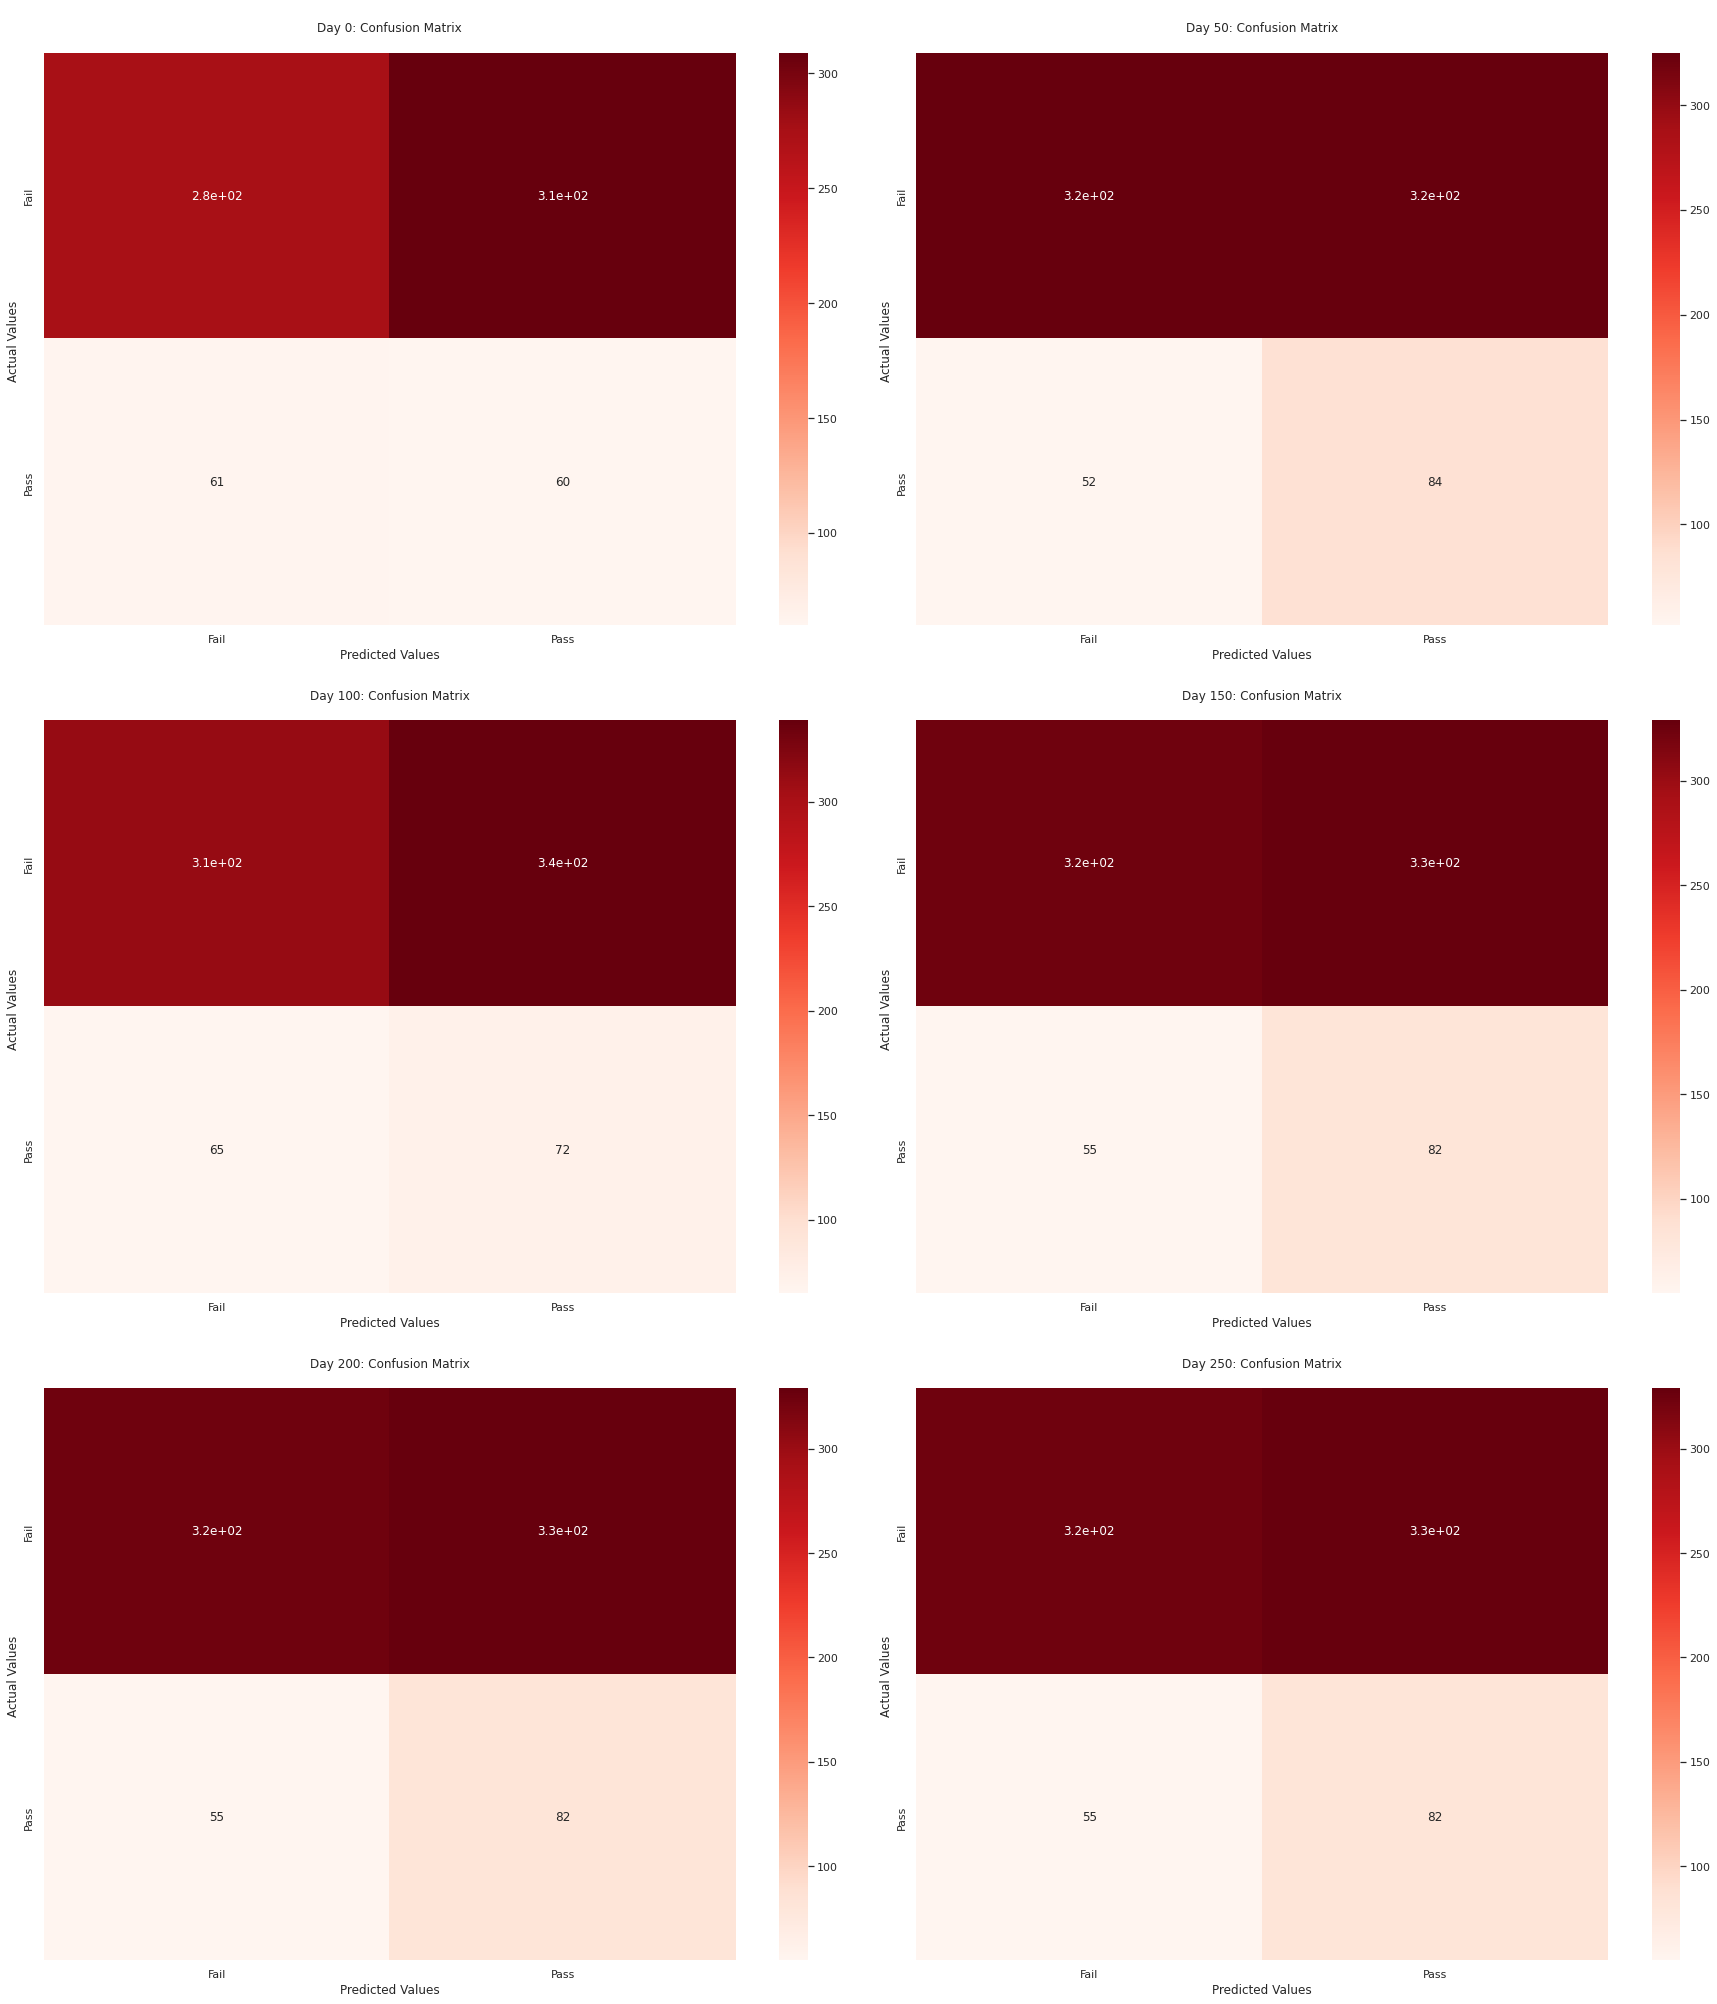

In [ ]:
plot_confusion_matrix(learning_behaviour_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

learning_behaviour_results_nb = []
learning_behaviour_features_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_nb.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.460
Best parameters set:
Accuracy: 0.5361702127659574, F1 Score: 0.33401221995926683, Precision: 0.22162162162162163, Recall: 0.6776859504132231


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.529
Best parameters set:
Accuracy: 0.732484076433121, F1 Score: 0.2708333333333333, Precision: 0.2565789473684211, Recall: 0.2867647058823529


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.514
Best parameters set:
Accuracy: 0.6717363751584284, F1 Score: 0.3129973474801061, Precision: 0.24583333333333332, Recall: 0.4306569343065693


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.736
Be

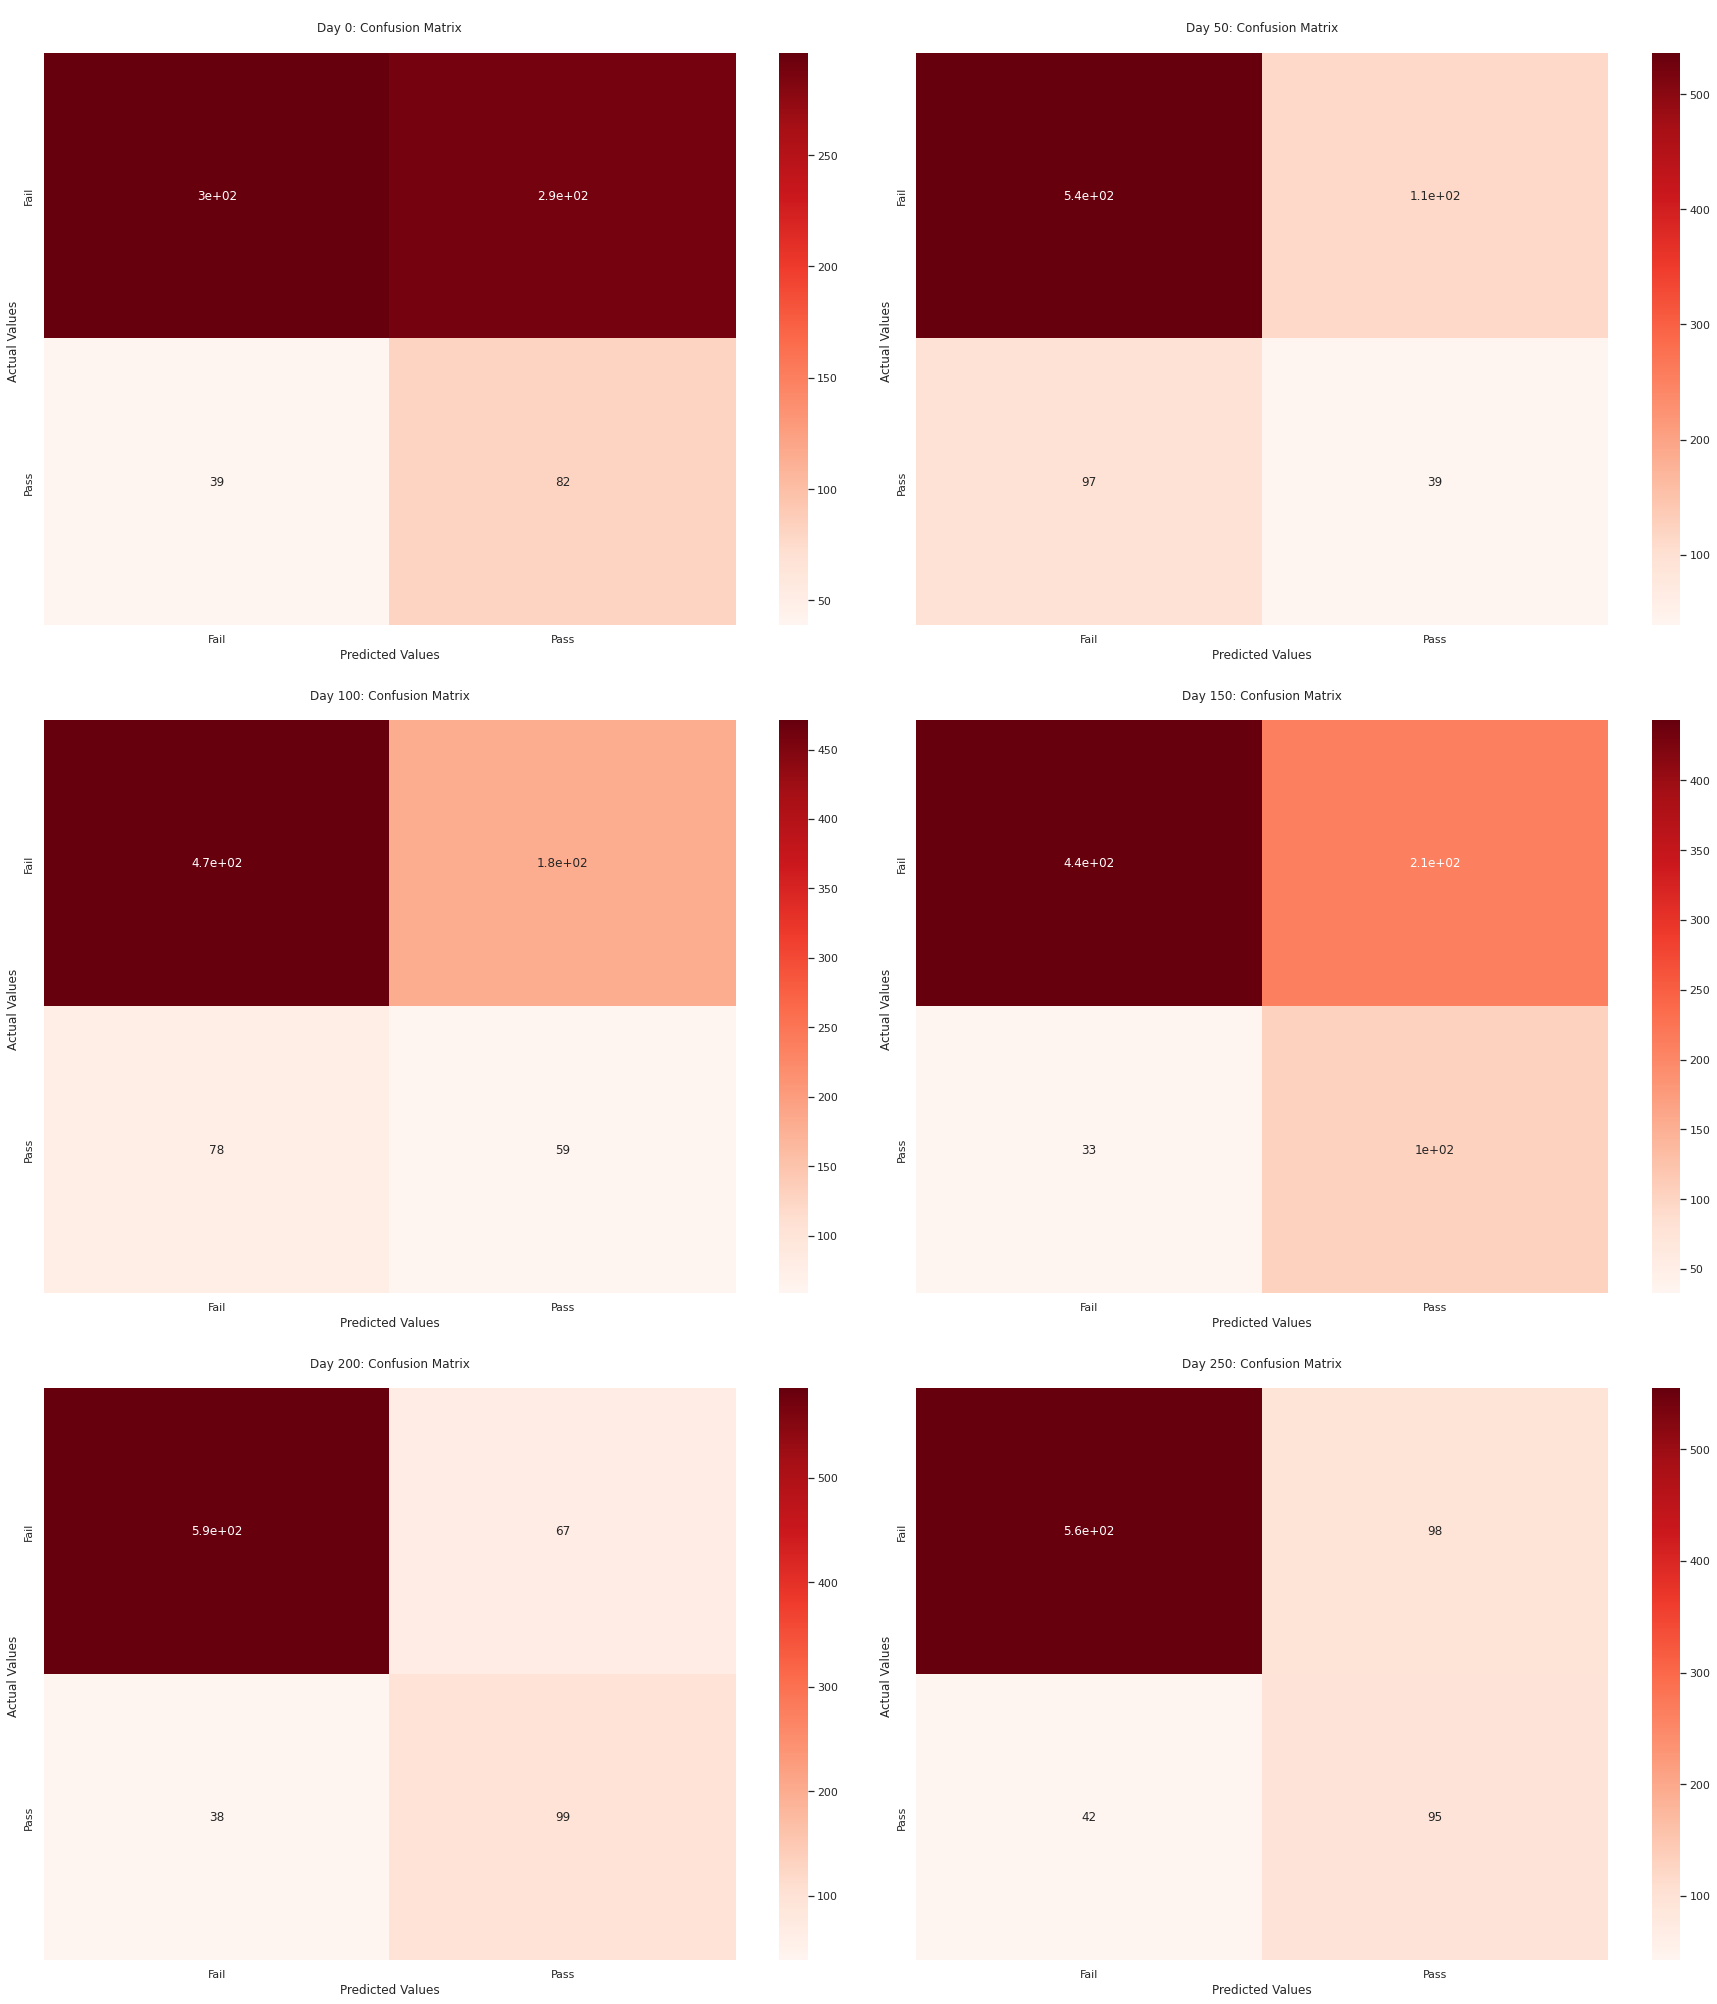

In [ ]:
plot_confusion_matrix(learning_behaviour_results_nb)

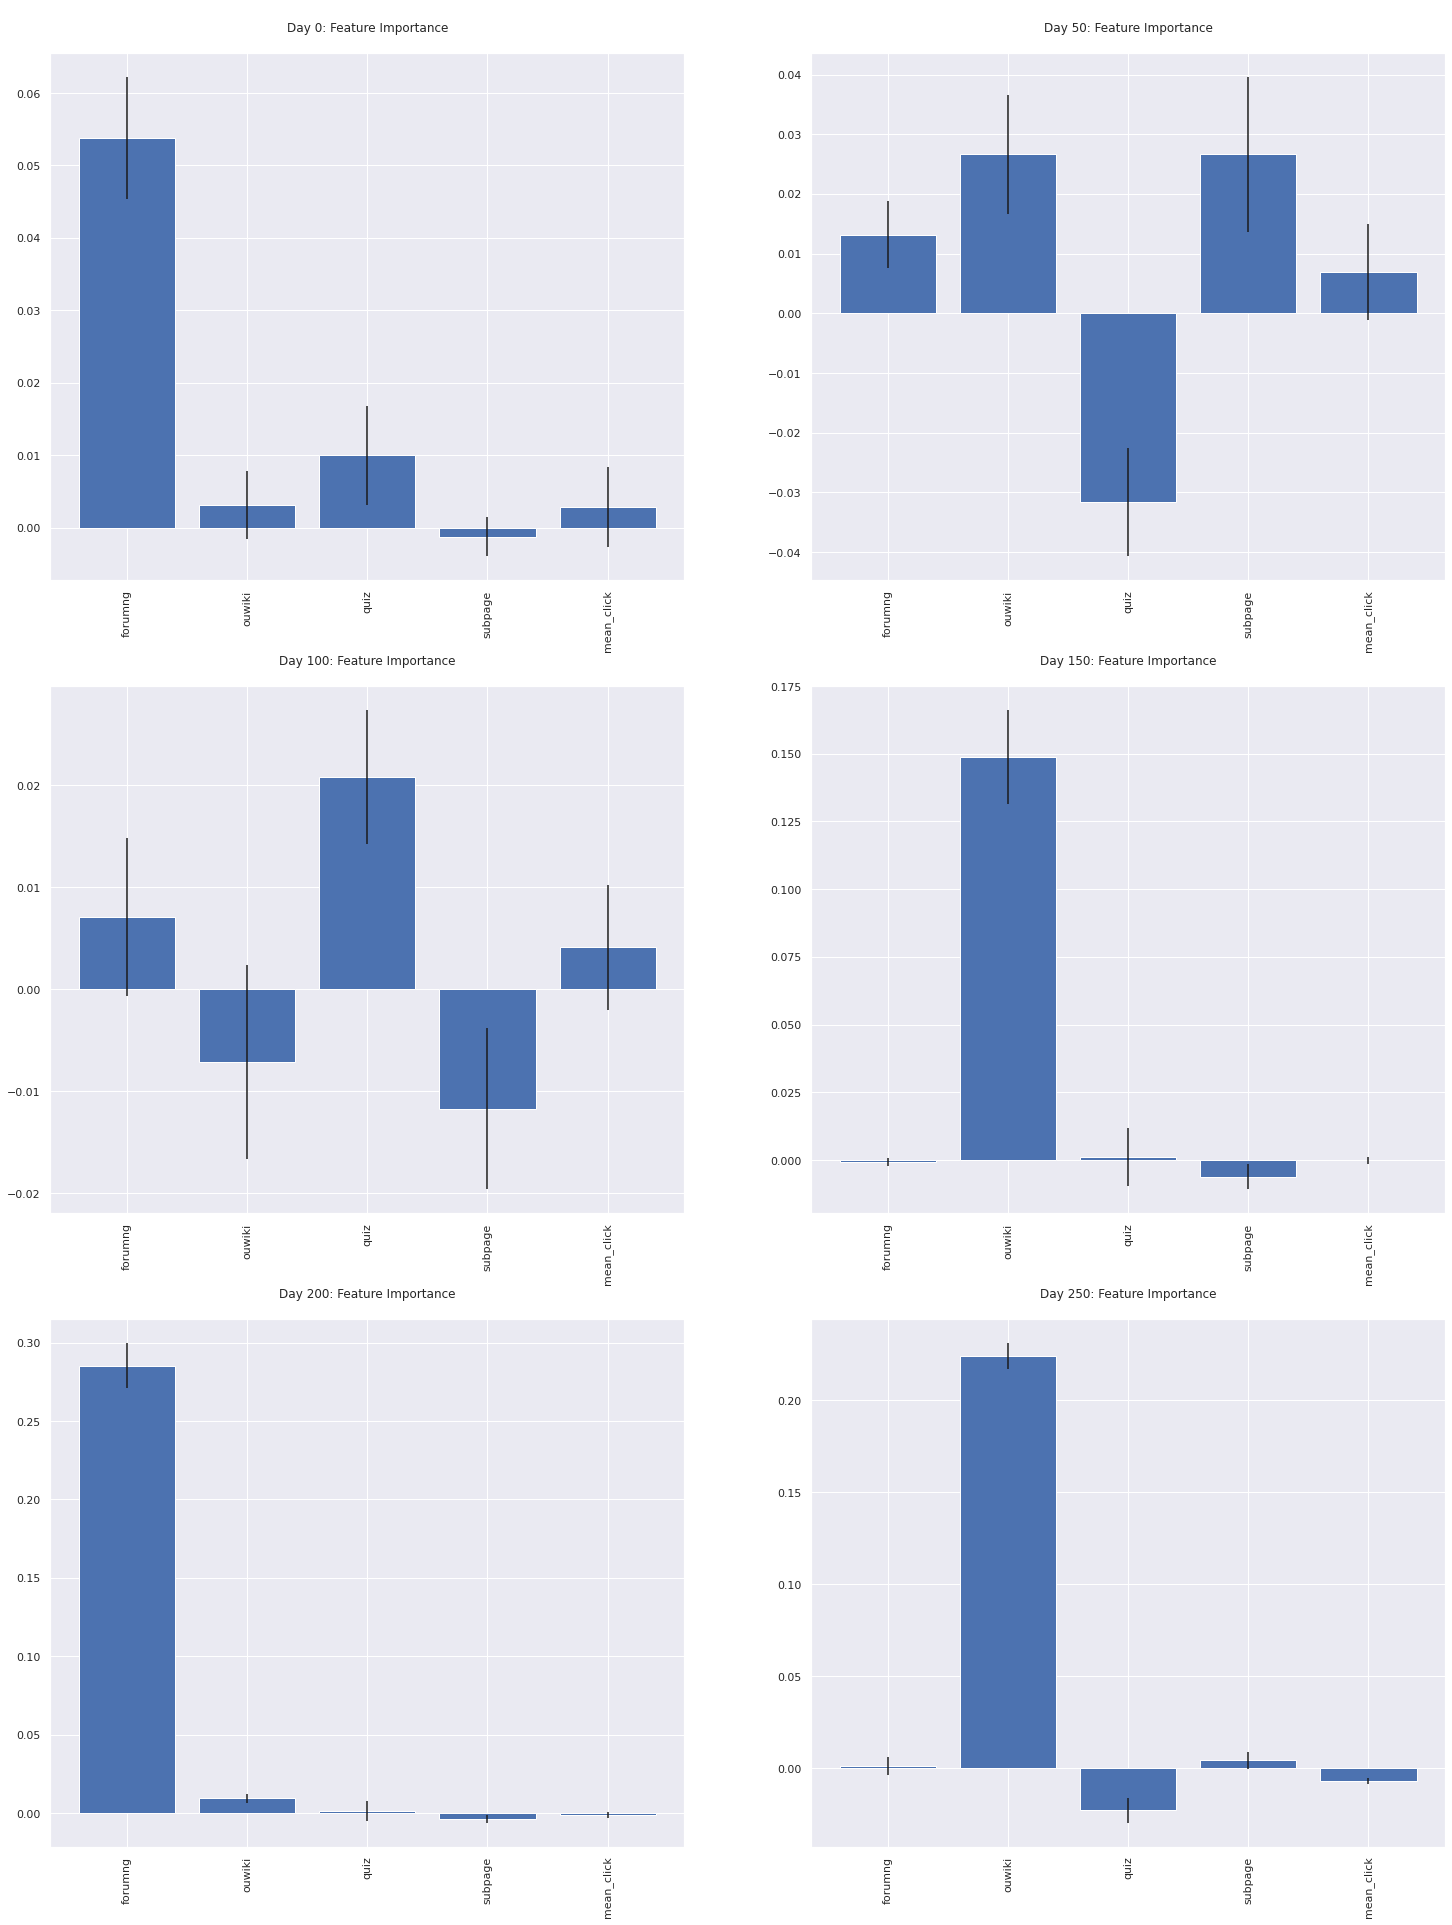

In [ ]:
plot_feature_importance(learning_behaviour_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

learning_behaviour_results_lr = []
learning_behiviour_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.447
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.8283687943262411, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.494
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8267515923566879, F1 Score: 0.04225352112676056, Precision: 0.5, Recall: 0.022058823529411766


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.491
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.826362484157161, F1 Score: 0.08053691275167786, Precision: 0.5, Recall: 0.043795620437956206


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.720
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8227848101265823, F1 Score: 0.3577981651376147, Precision: 0.48148148148148145, Recall: 0.2846715328467153


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0

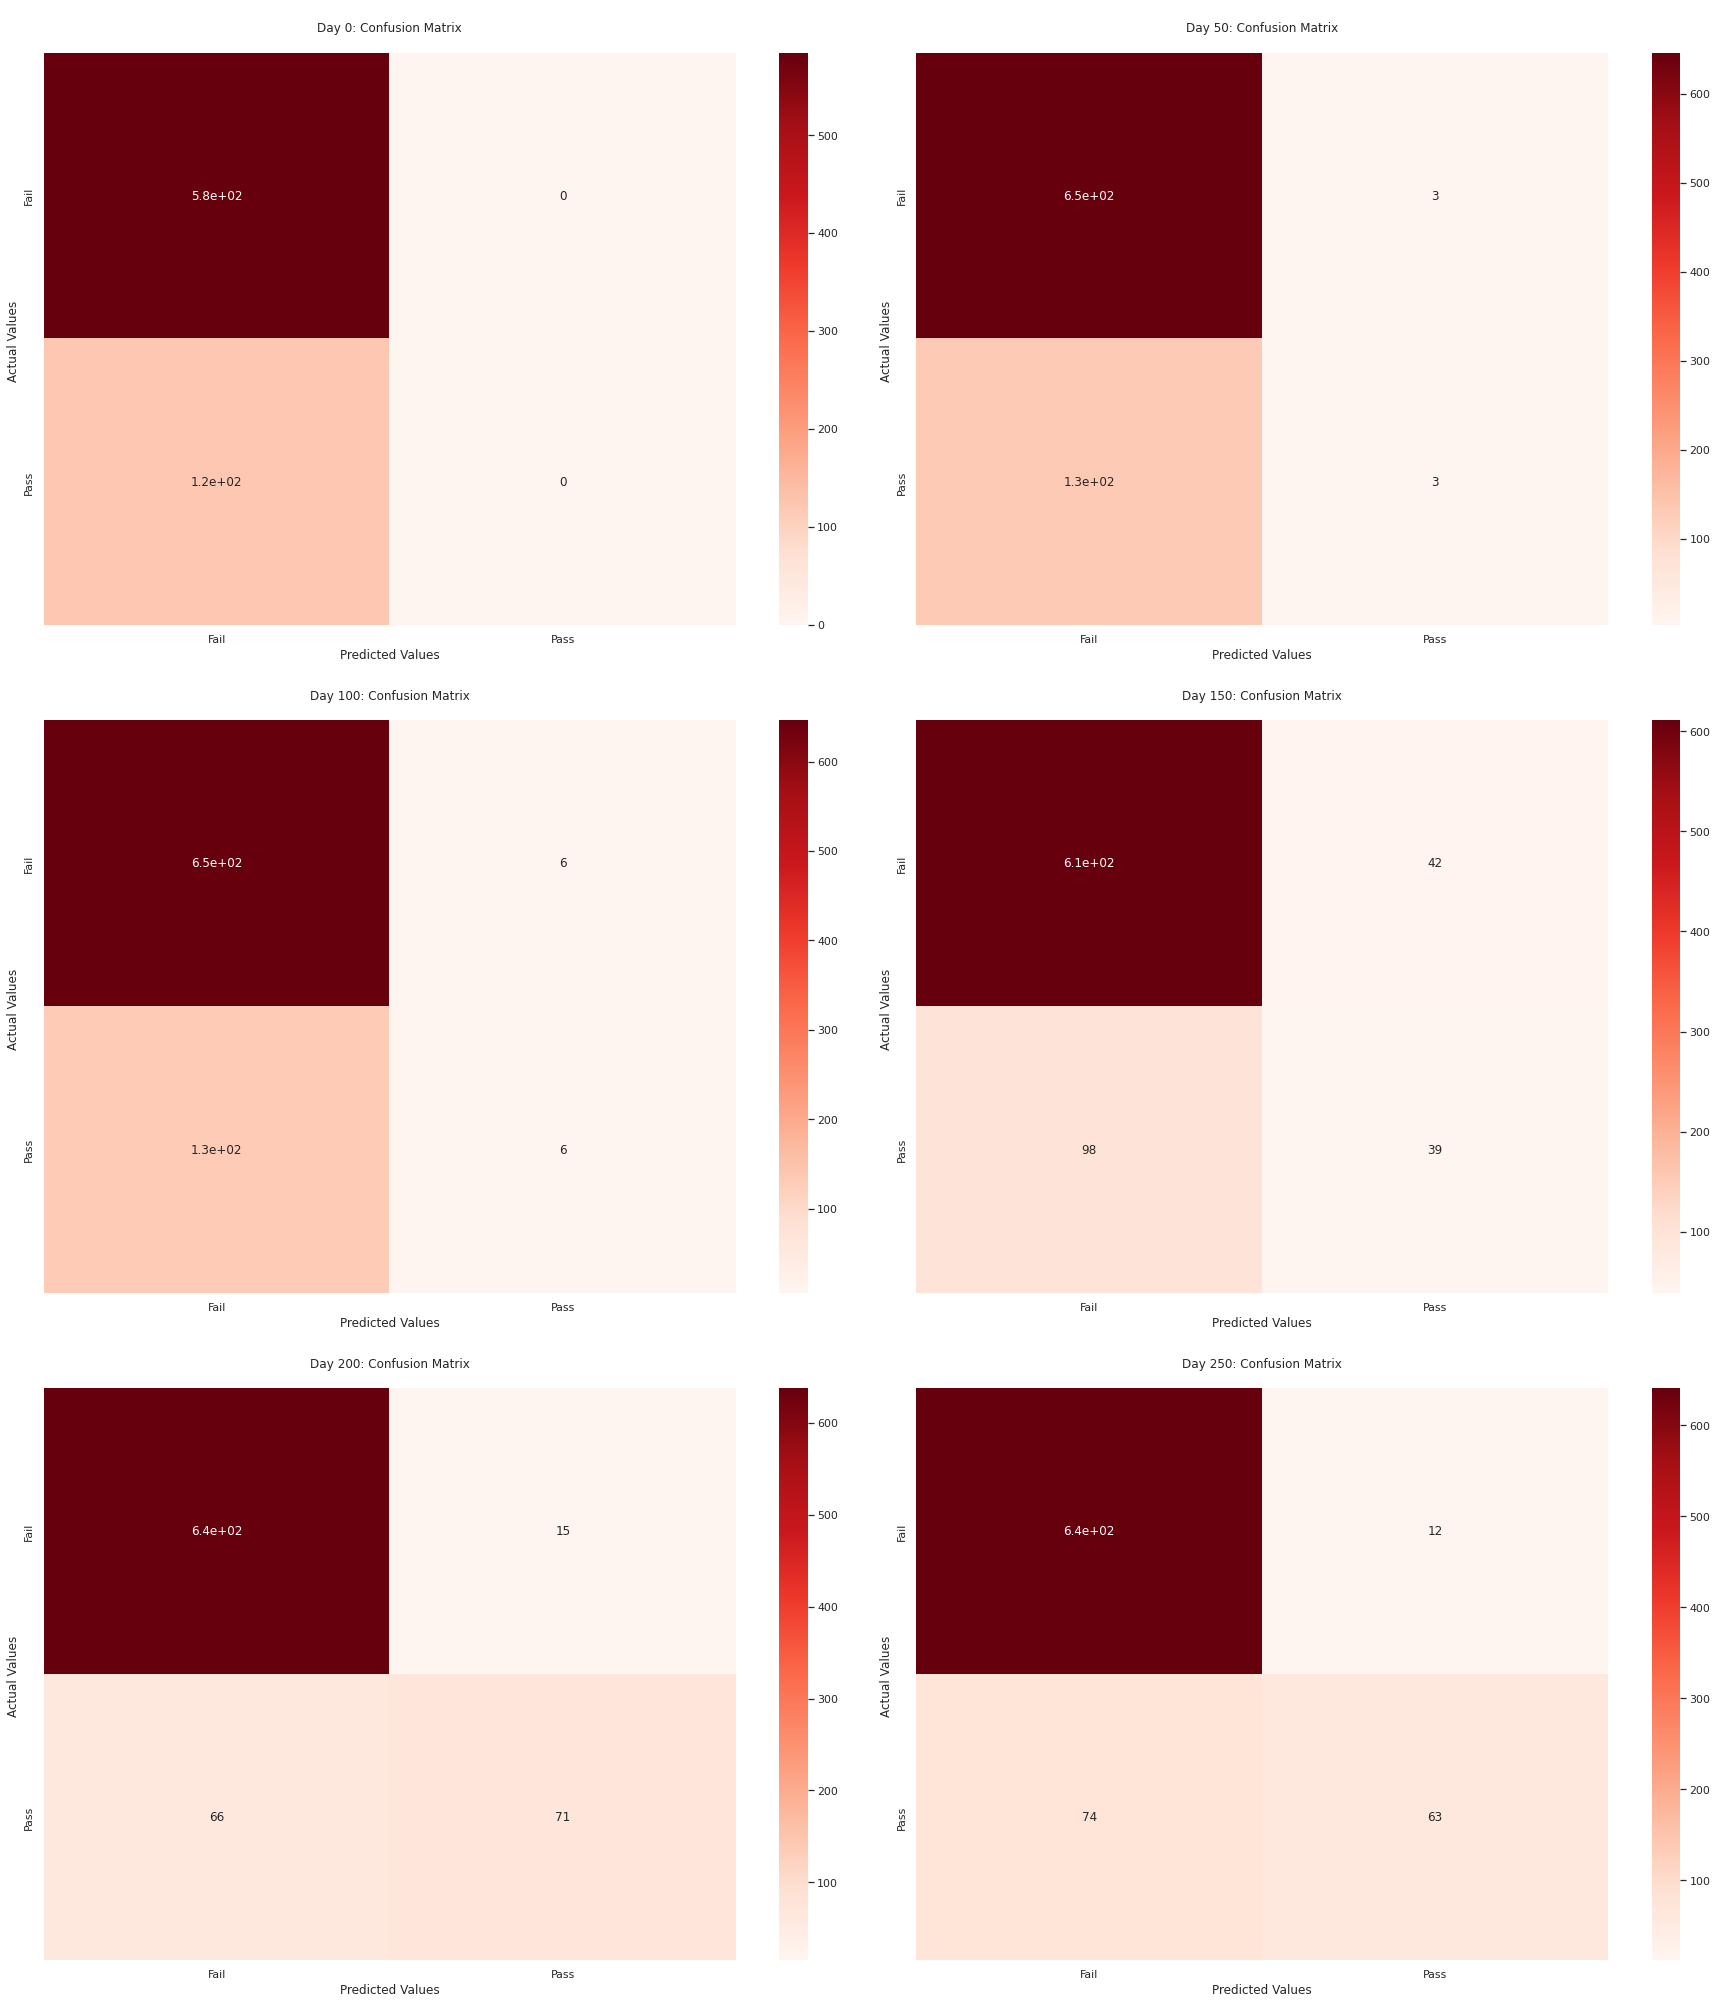

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lr)

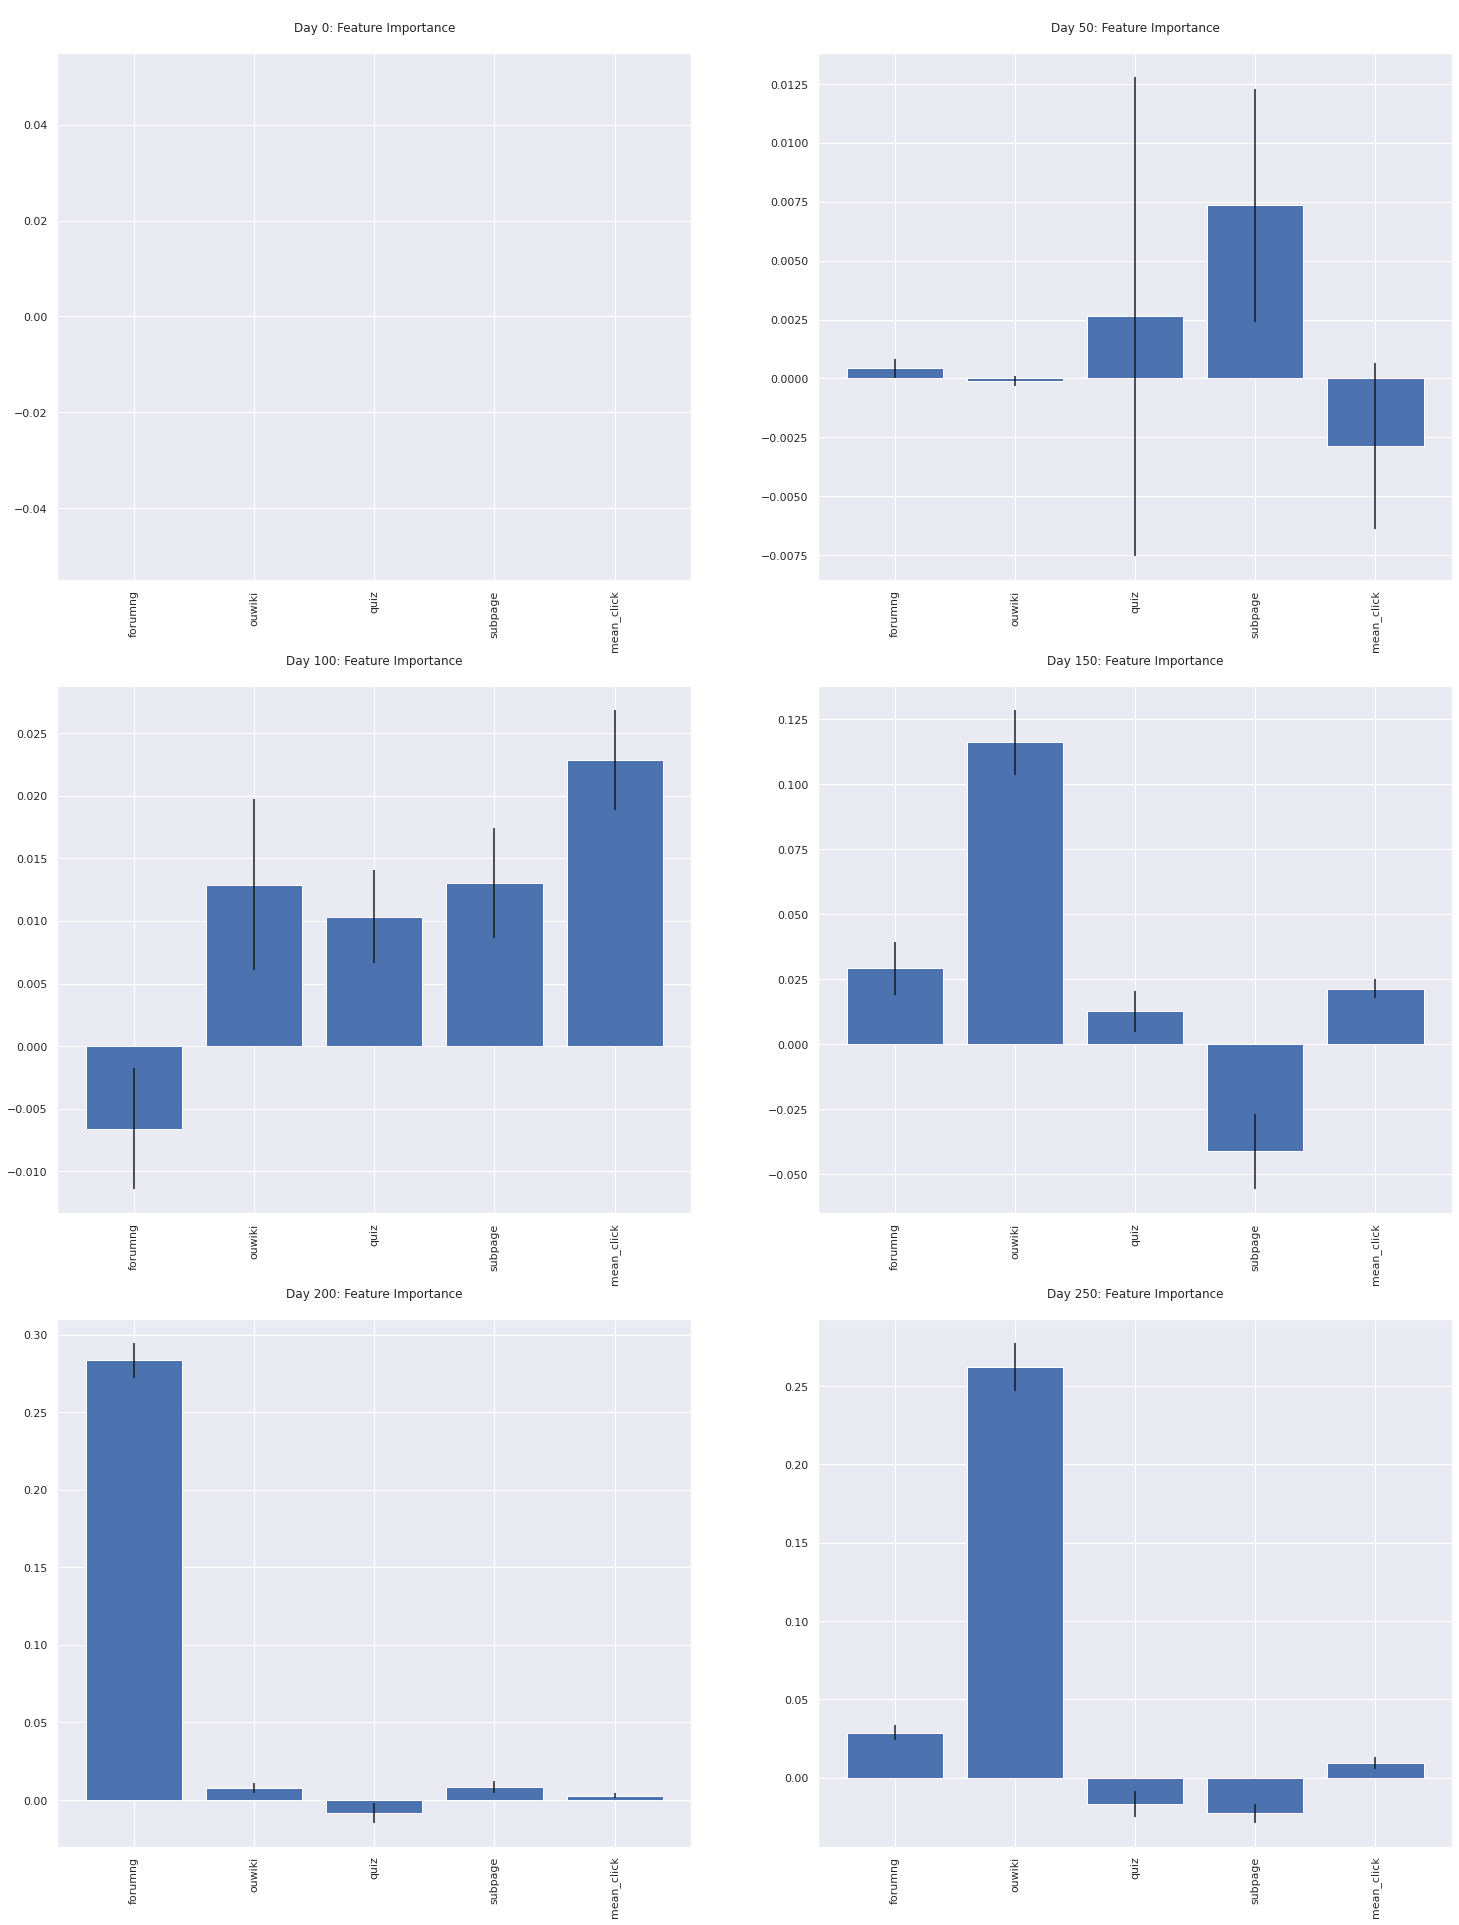

In [ ]:
plot_feature_importance(learning_behiviour_features_lr)

##### WeightedLogisticRegression

In [ ]:
learning_behaviour_results_lrw = []
learning_behaviour_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_lrw.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.4907801418439716, F1 Score: 0.3289719626168224, Precision: 0.21256038647342995, Recall: 0.7272727272727273


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.517
Best parameters set:
Accuracy: 0.7006369426751592, F1 Score: 0.37994722955145116, Precision: 0.2962962962962963, Recall: 0.5294117647058824


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.546
Best parameters set:
Accuracy: 0.6996197718631179, F1 Score: 0.33983286908078, Precision: 0.2747747747747748, Recall: 0.44525547445255476


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.726
Bes

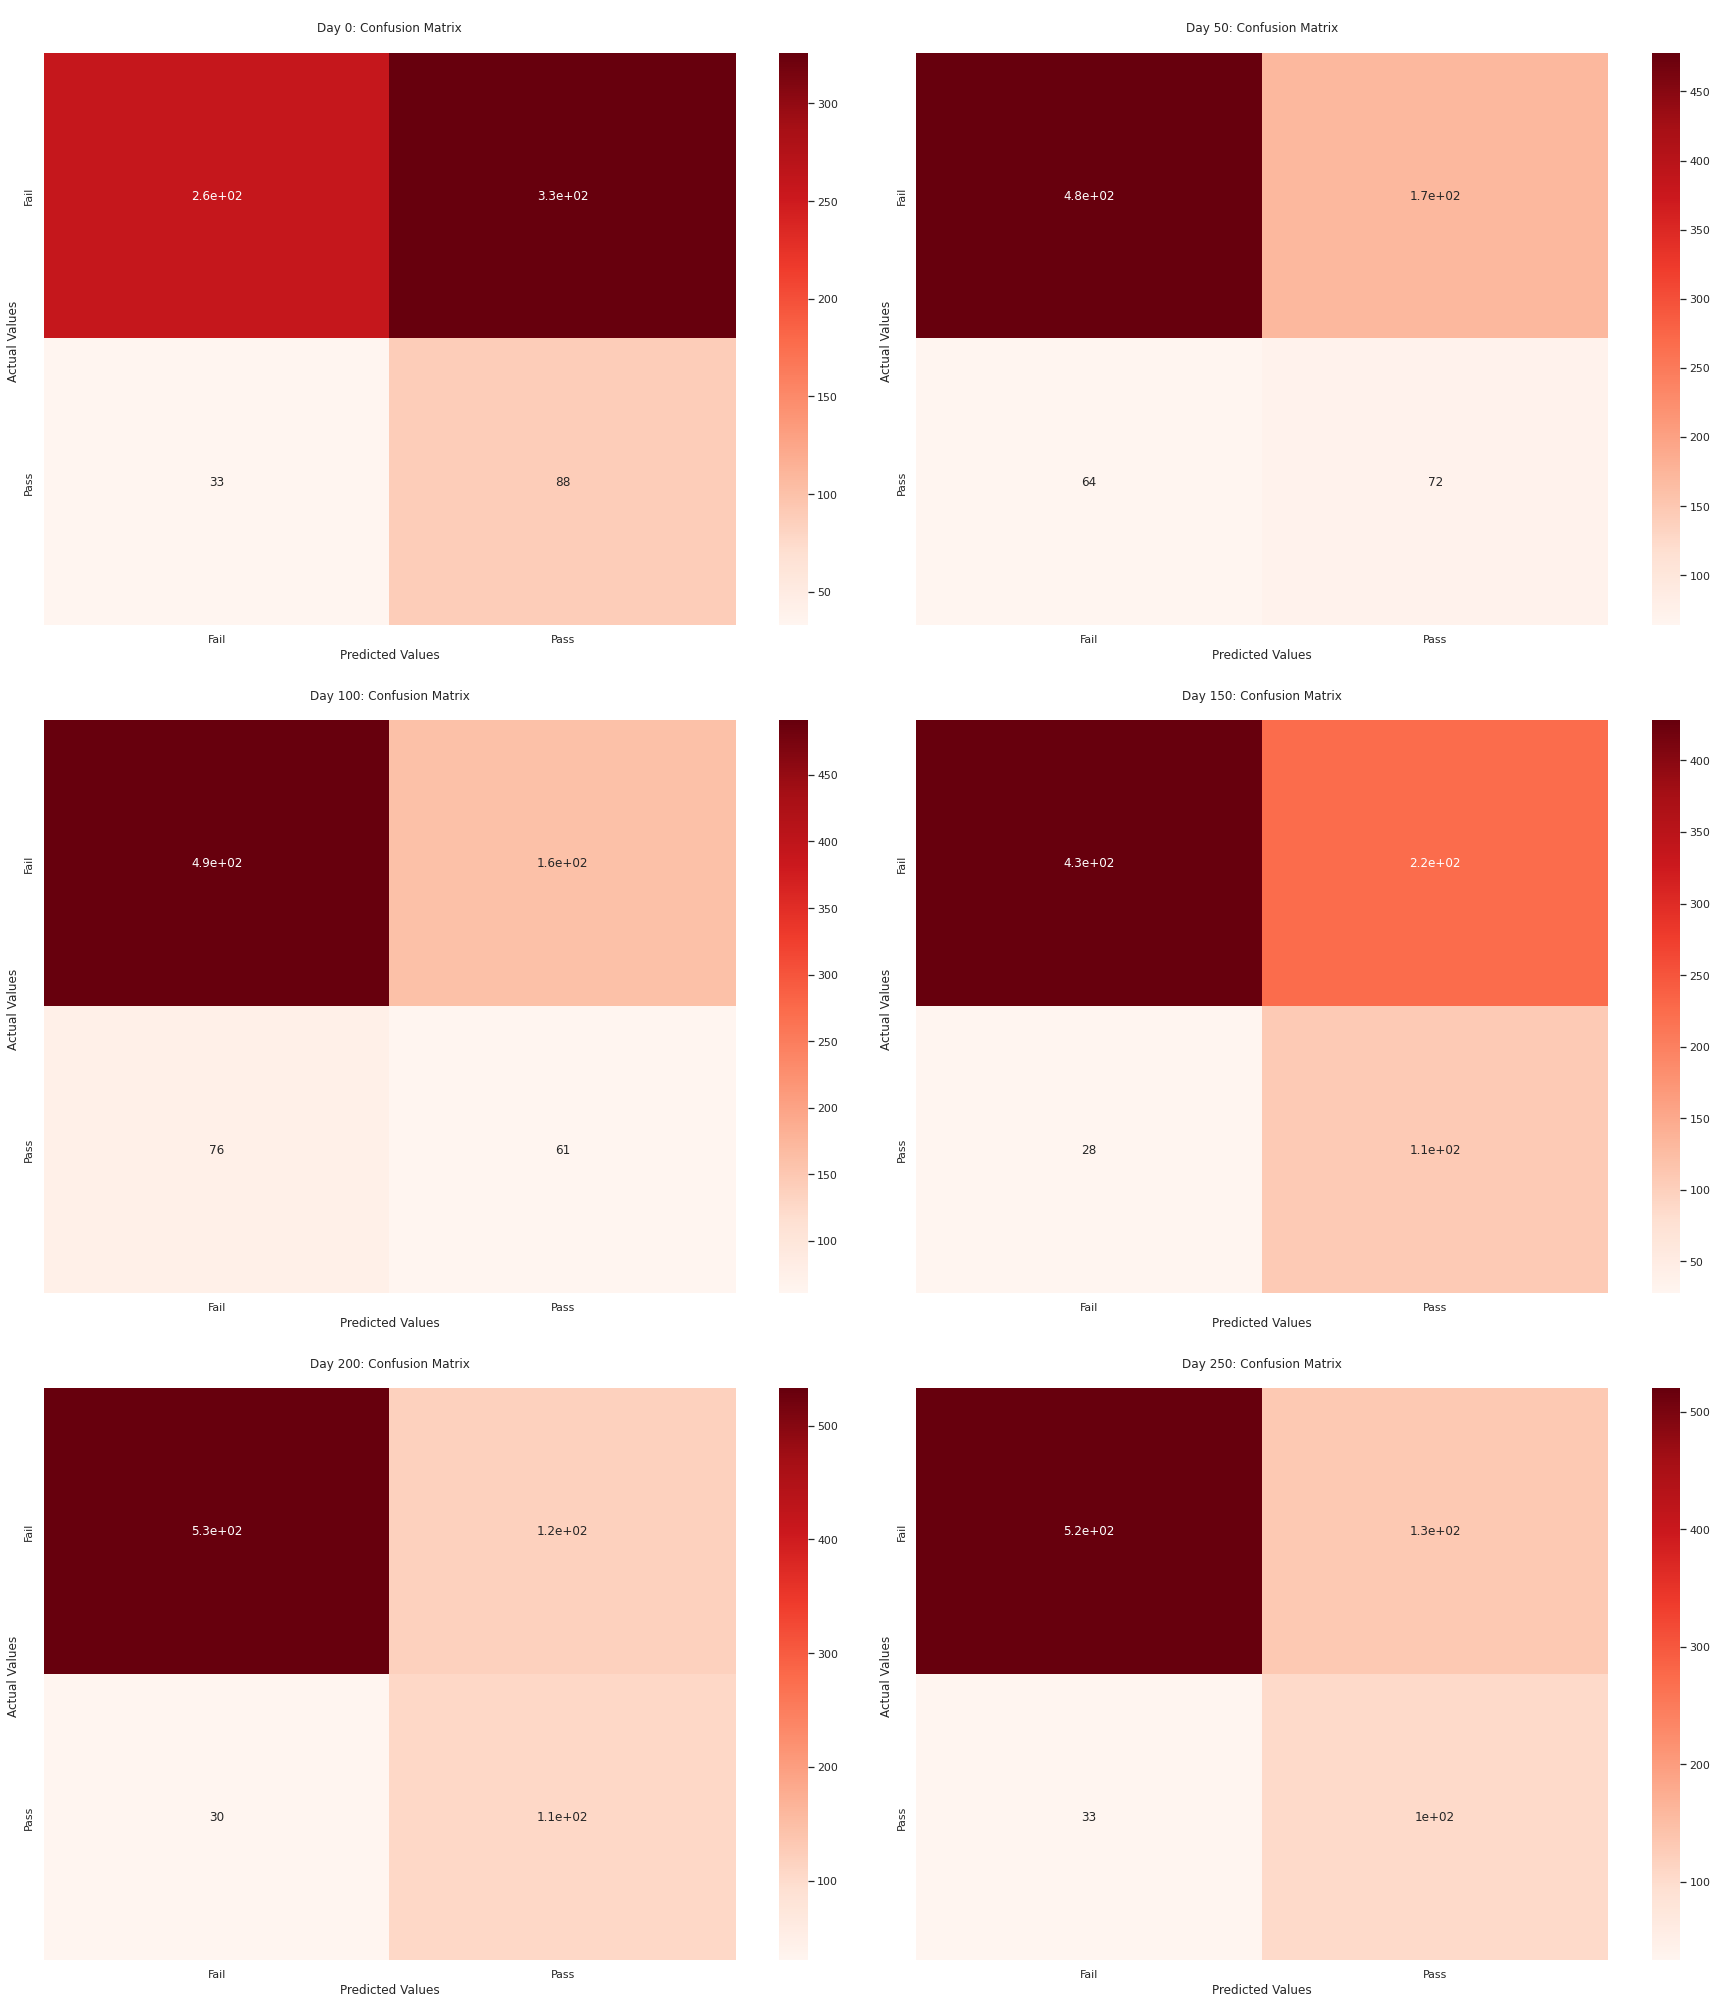

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lrw)

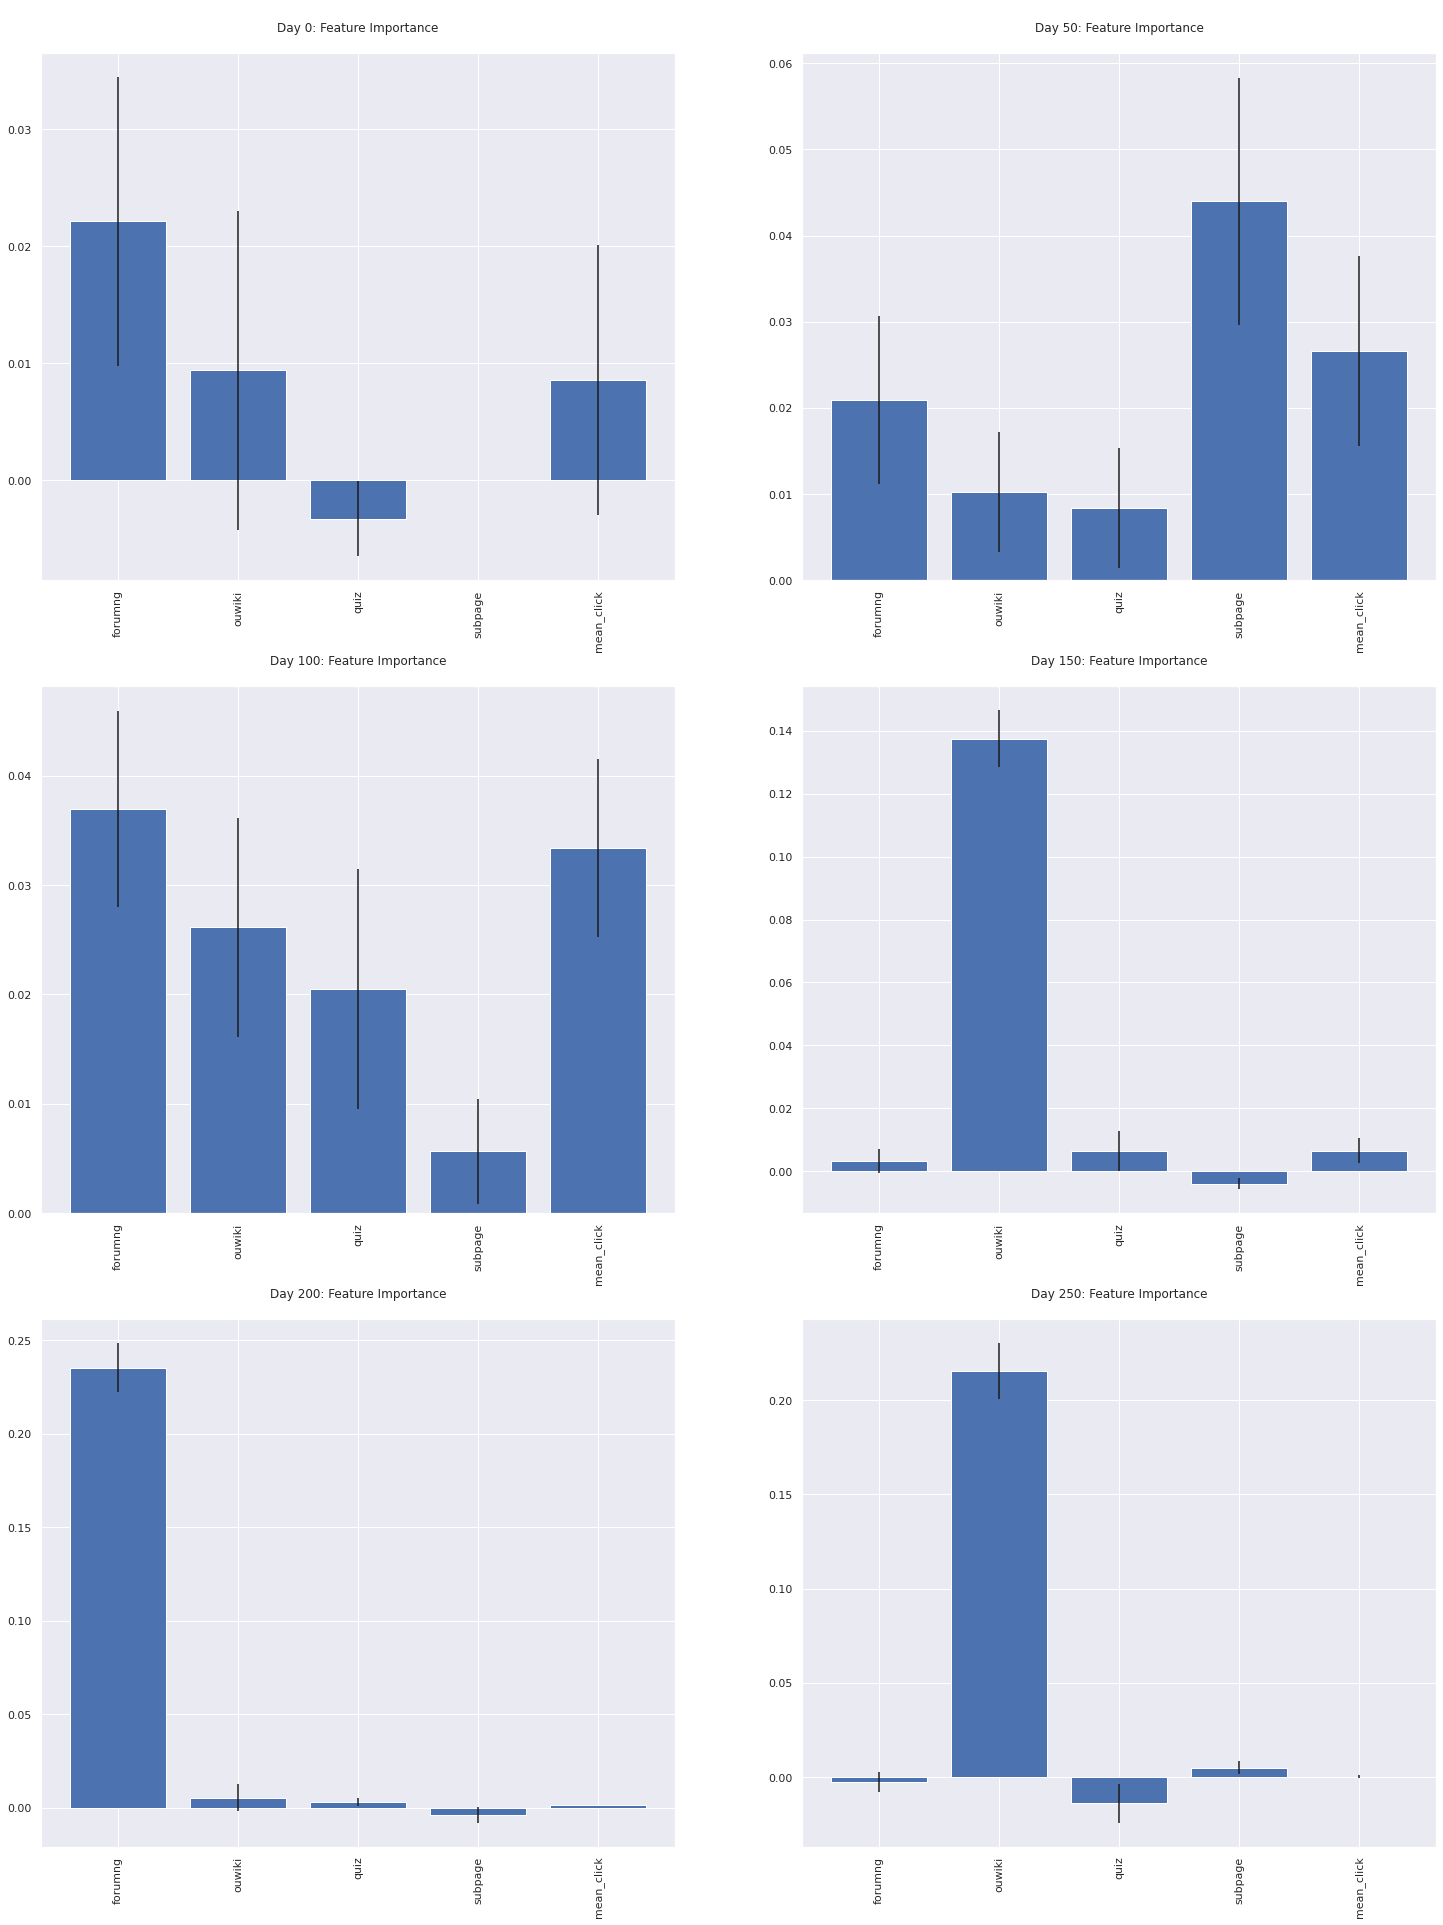

In [ ]:
plot_feature_importance(learning_behaviour_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

learning_behaviour_results_rf = []
learning_behaviour_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.543
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.7673758865248227, F1 Score: 0.18811881188118815, Precision: 0.2345679012345679, Recall: 0.15702479338842976


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.496
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.8191082802547771, F1 Score: 0.06578947368421054, Precision: 0.3125, Recall: 0.03676470588235294


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.527
Best parameters set:
	clf__n_estimators: 90
Ac

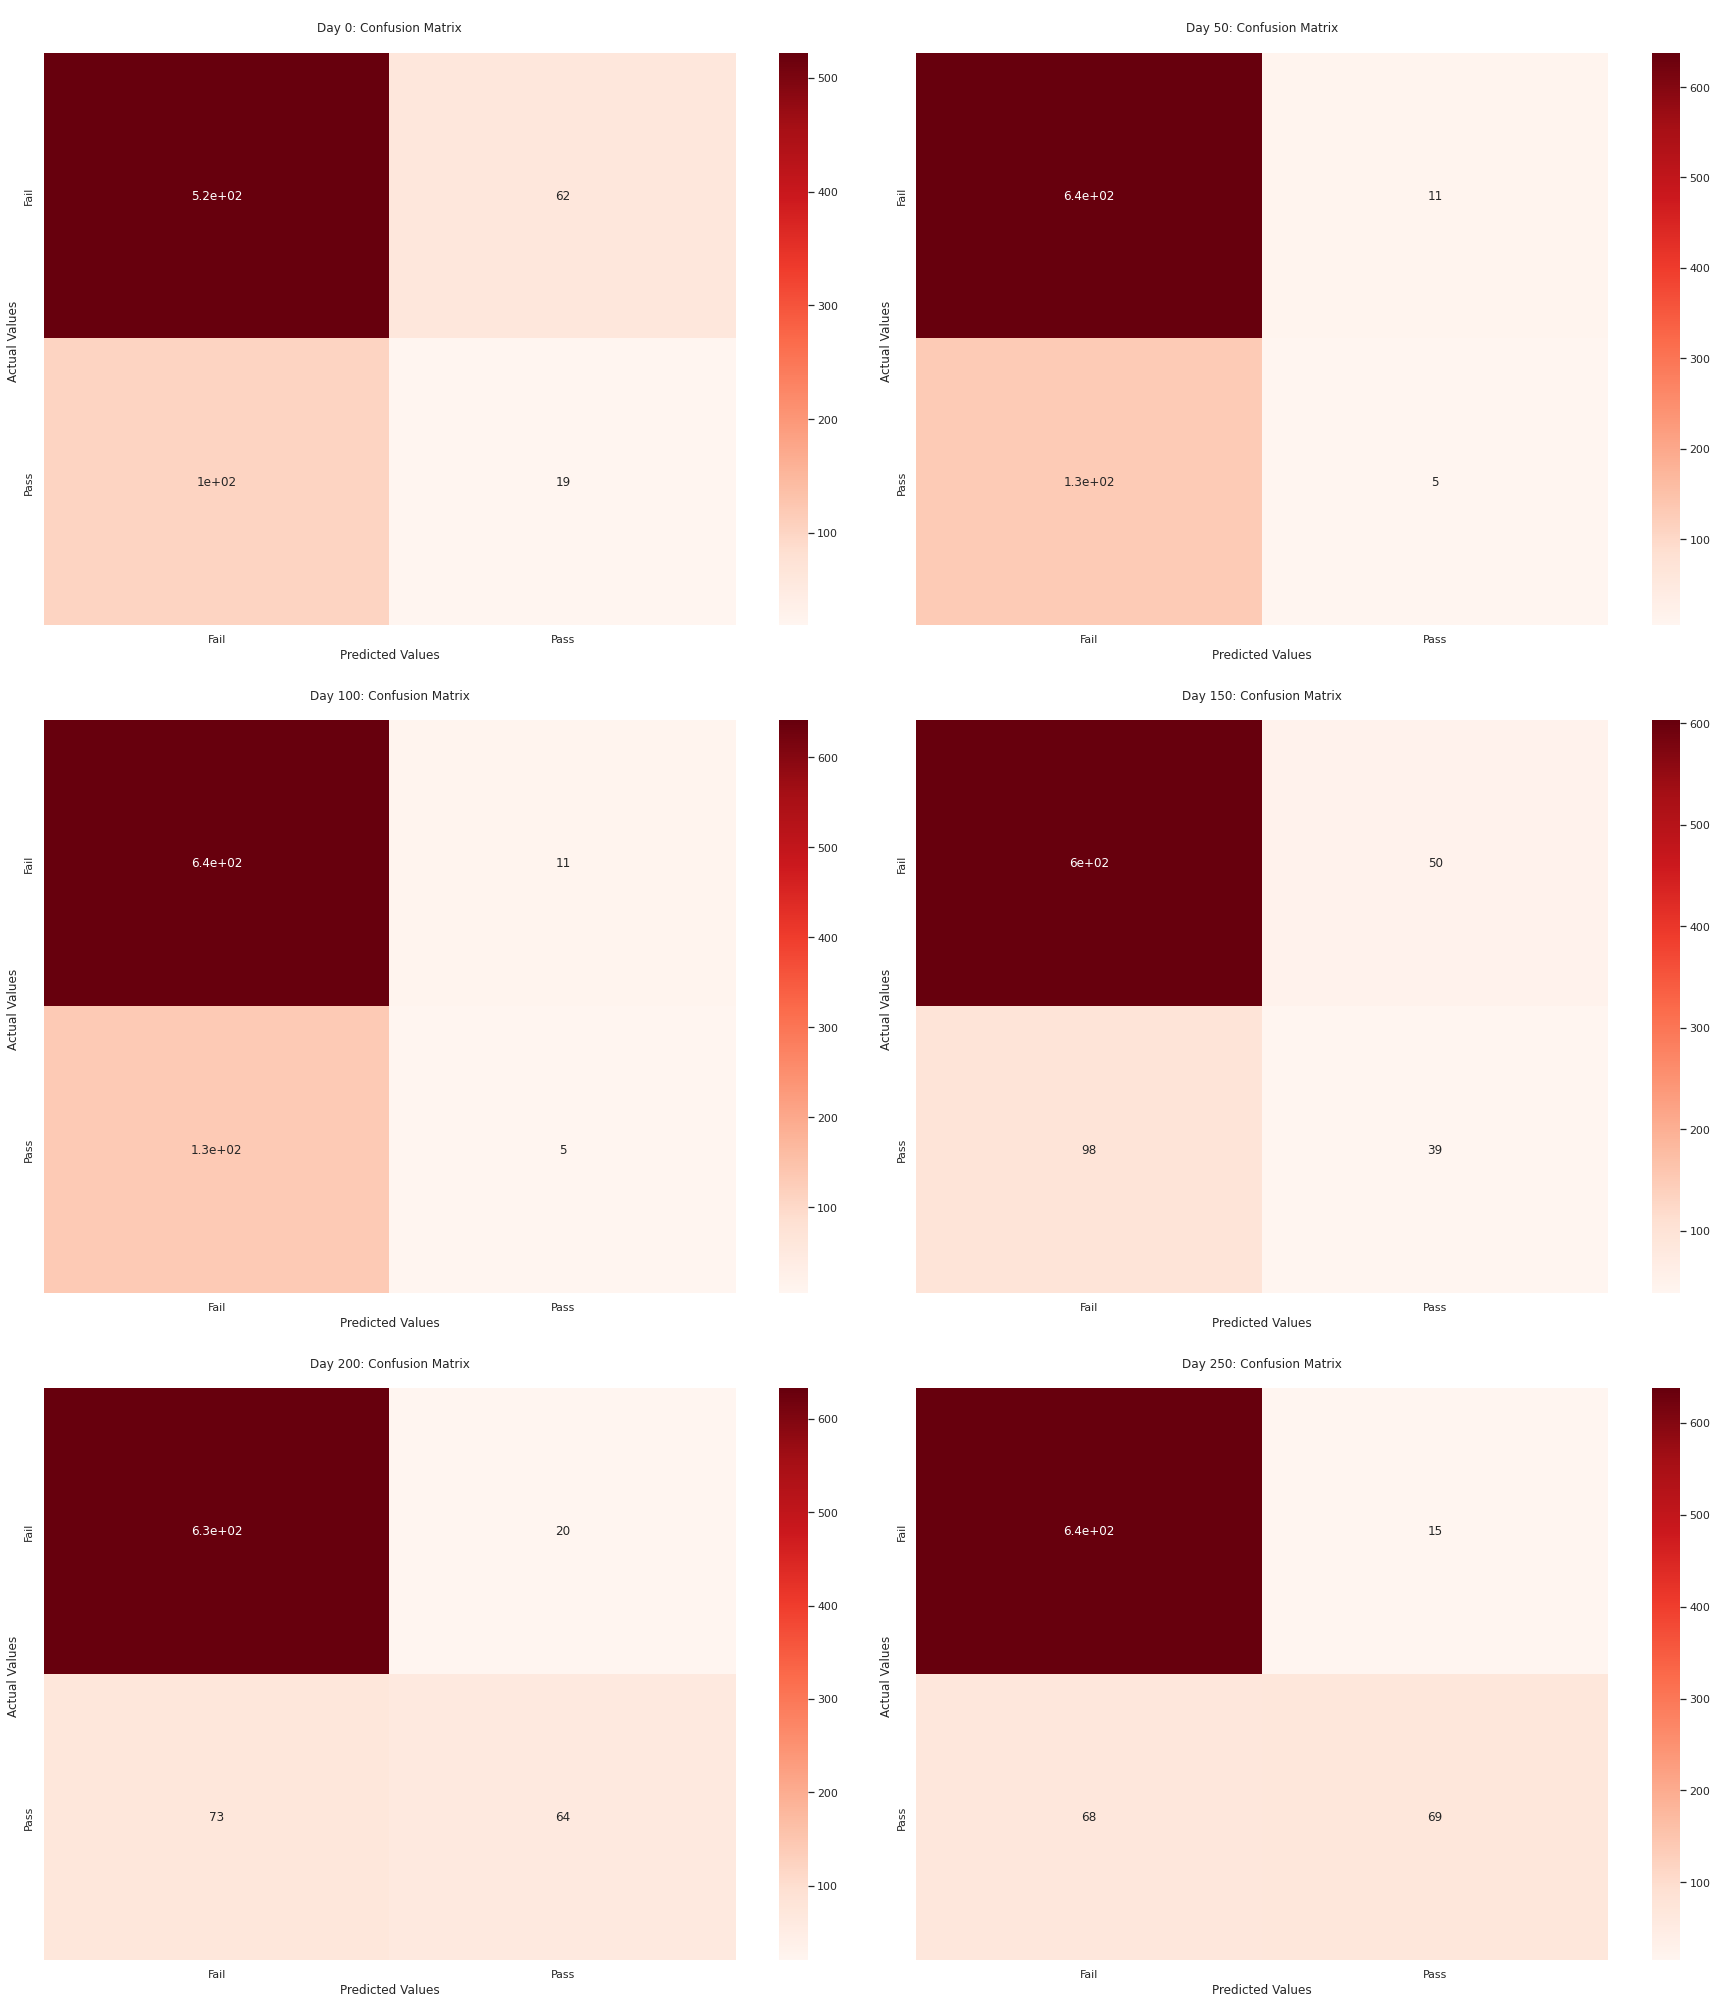

In [ ]:
plot_confusion_matrix(learning_behaviour_results_rf)

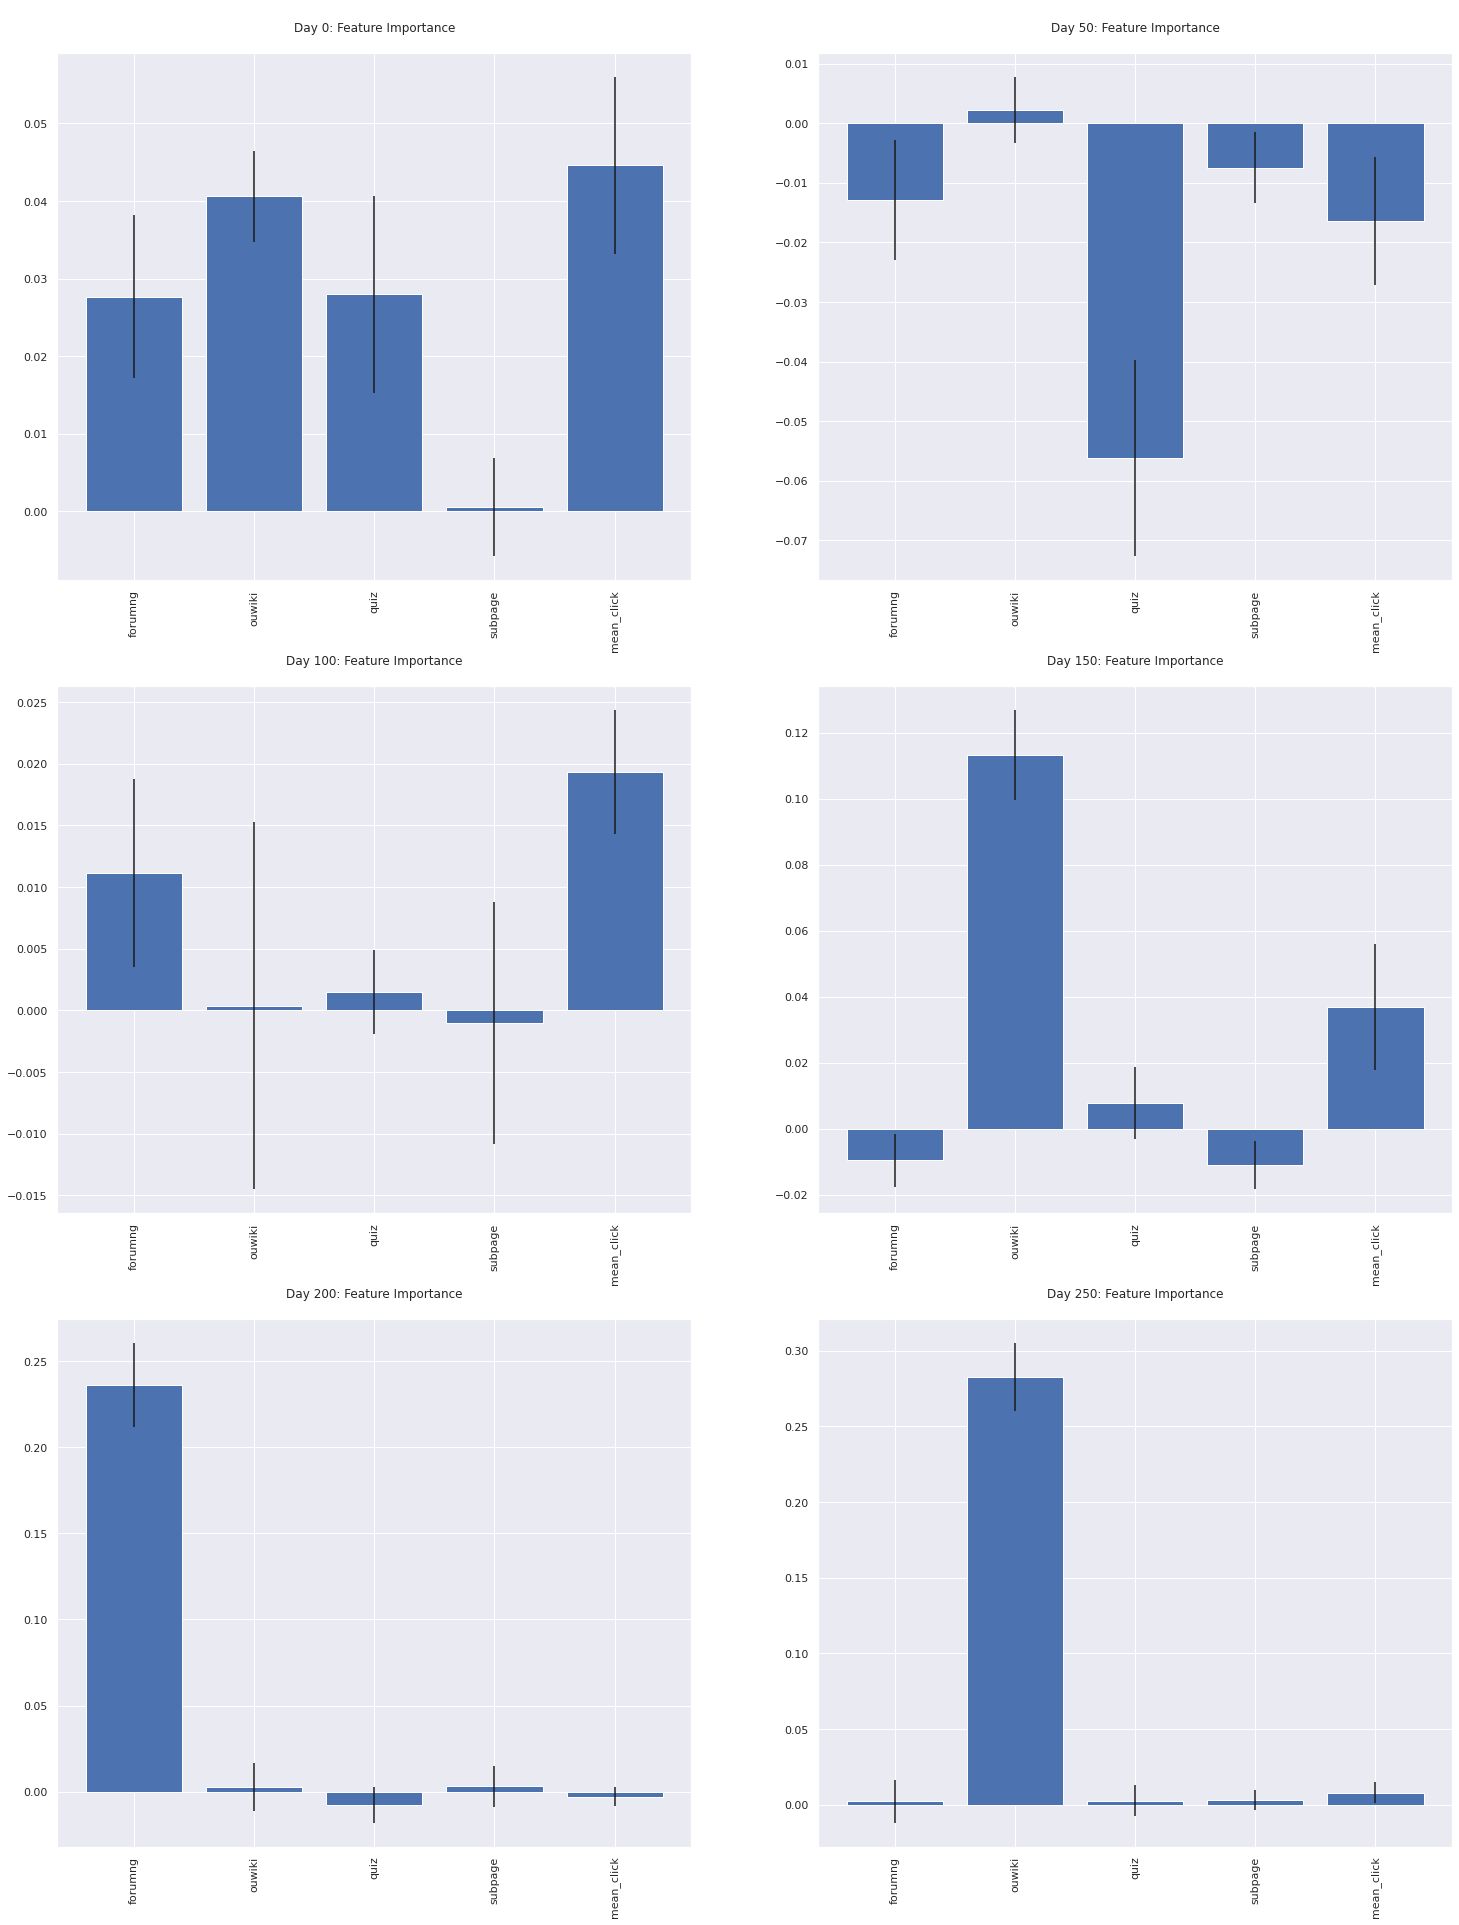

In [ ]:
plot_feature_importance(learning_behaviour_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

learning_behaviour_results_ab = []
learning_behiviour_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_ab.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.508
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.774468085106383, F1 Score: 0.15873015873015872, Precision: 0.22058823529411764, Recall: 0.12396694214876033


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.541
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.7936305732484077, F1 Score: 0.06896551724137931, Precision: 0.15789473684210525, Recall: 0.04411764705882353


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.553
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.799746514575

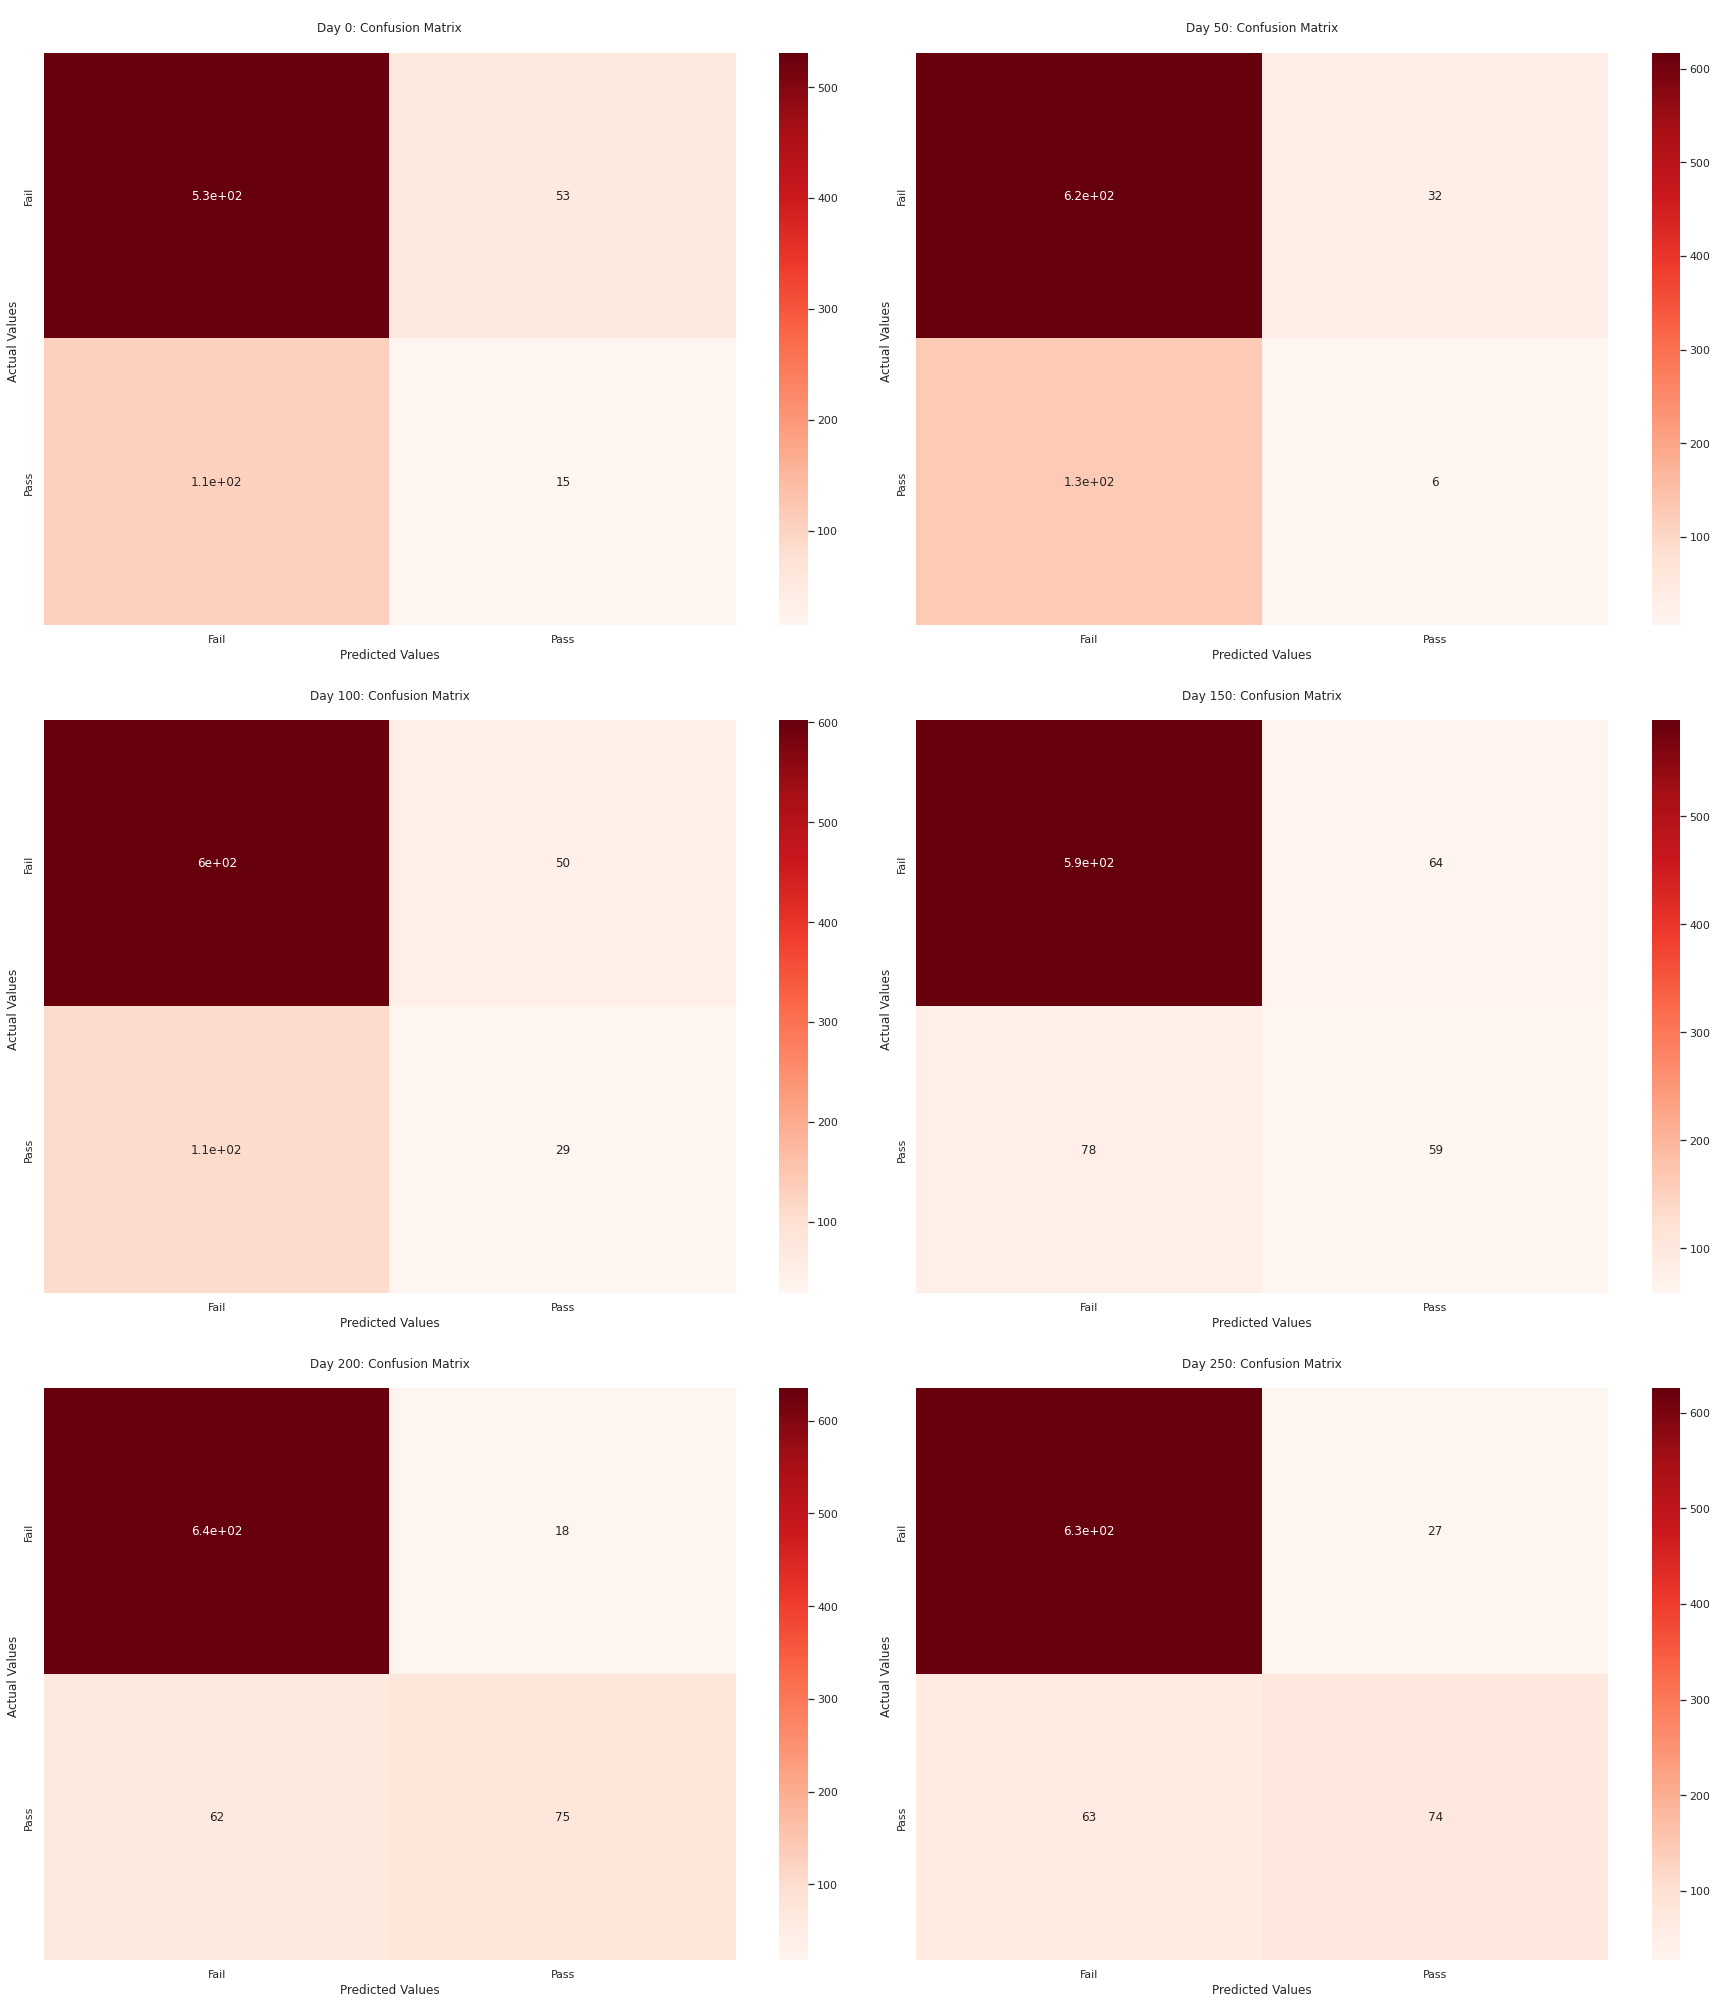

In [ ]:
plot_confusion_matrix(learning_behaviour_results_ab)

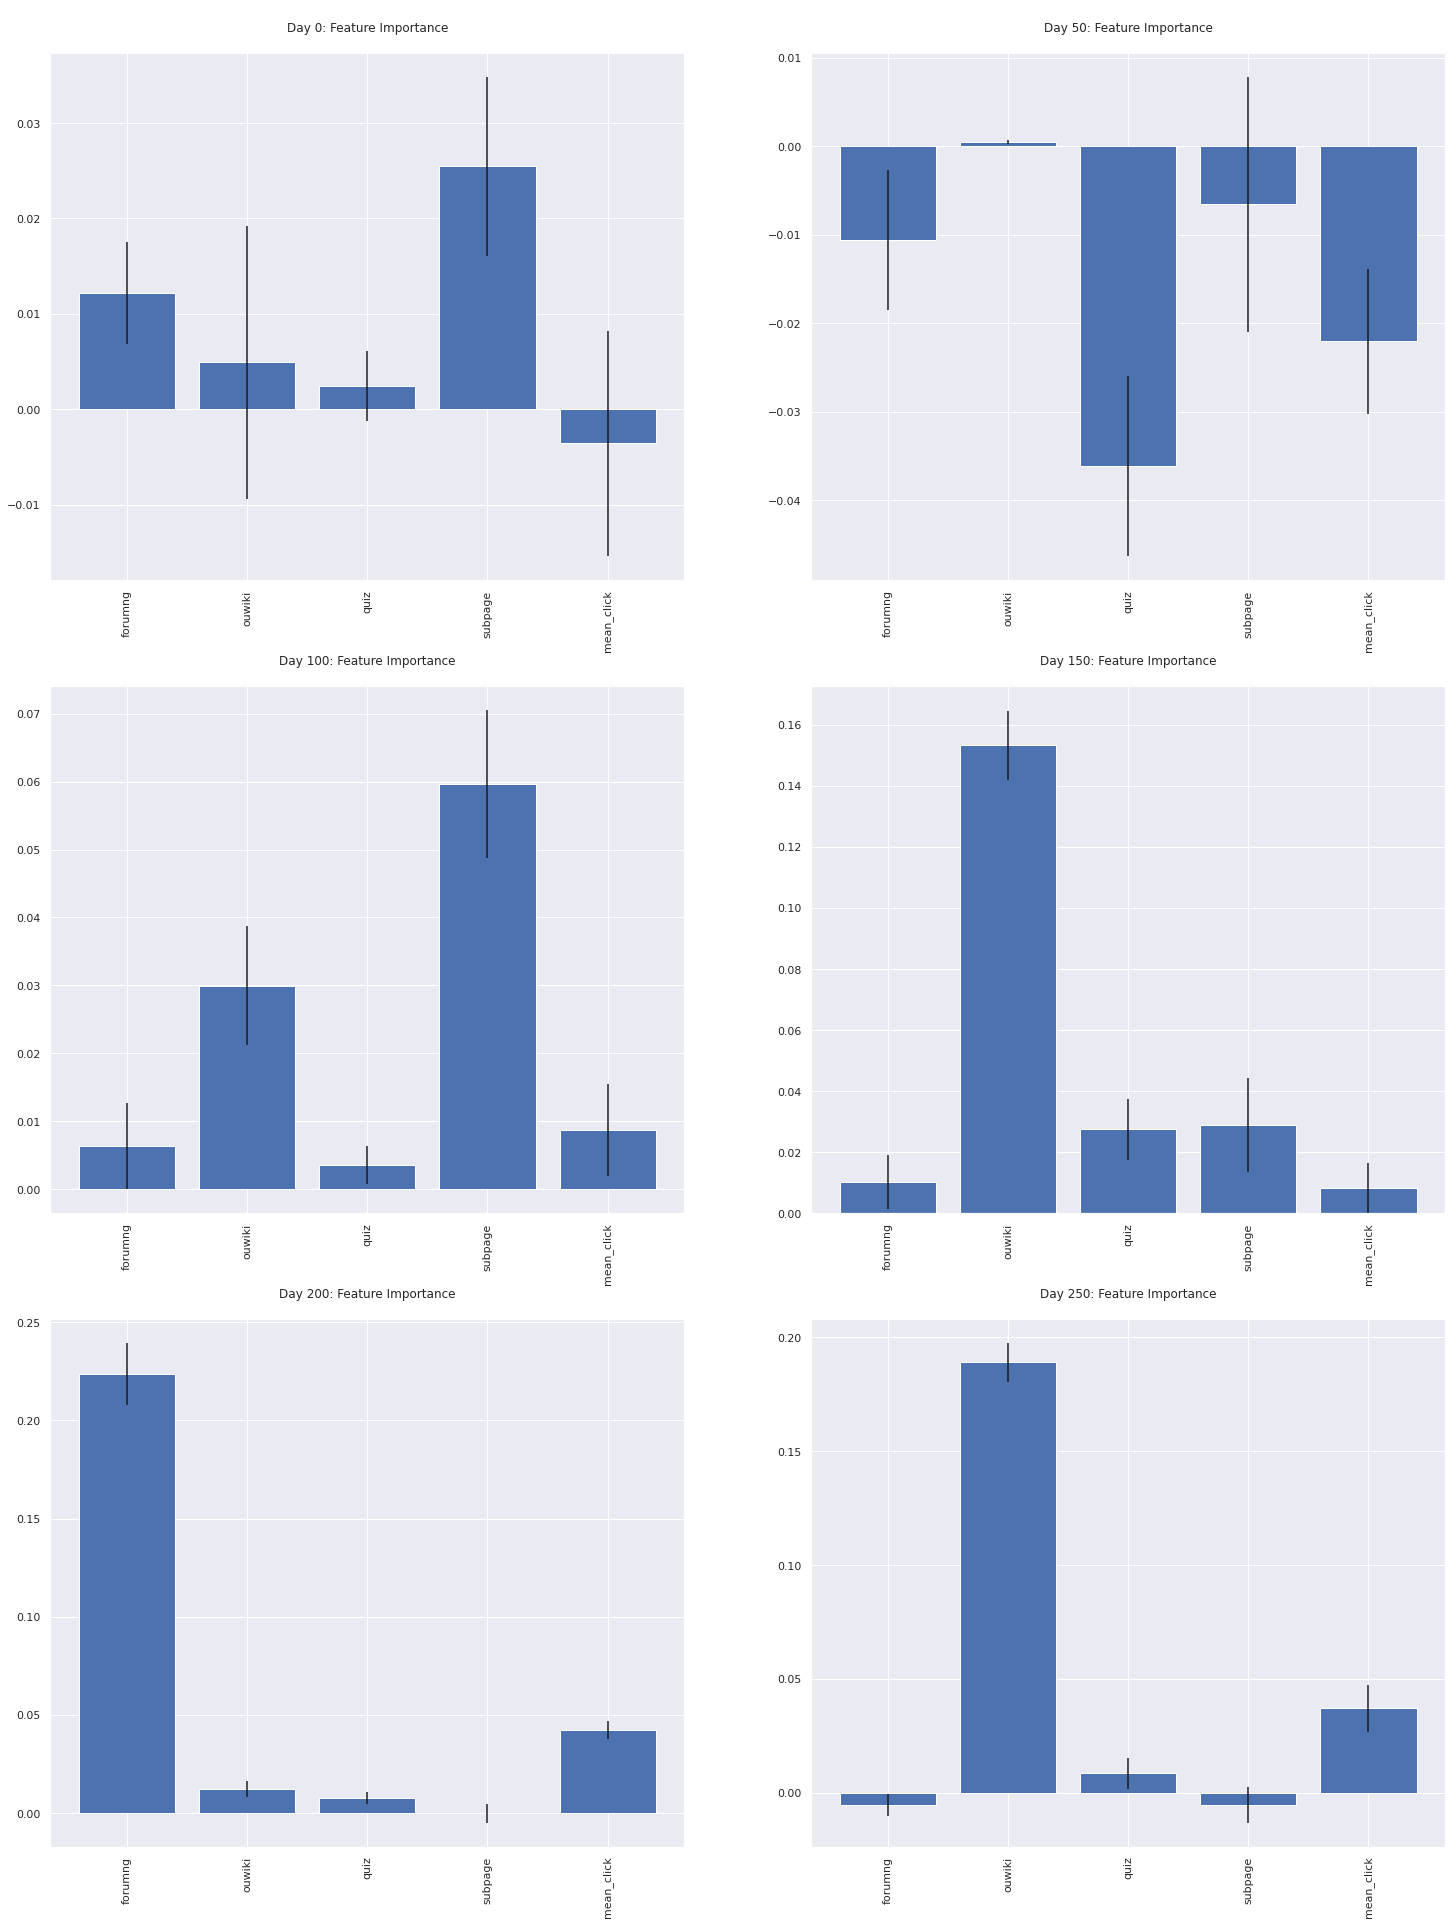

In [ ]:
plot_feature_importance(learning_behiviour_features_ab)

##### Plot results overview

In [ ]:
learning_behaviour_classifier_results = [learning_behaviour_results_du, learning_behaviour_results_nb, learning_behaviour_results_lr, learning_behaviour_results_lrw, learning_behaviour_results_rf, learning_behaviour_results_ab]
learning_behaviour_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

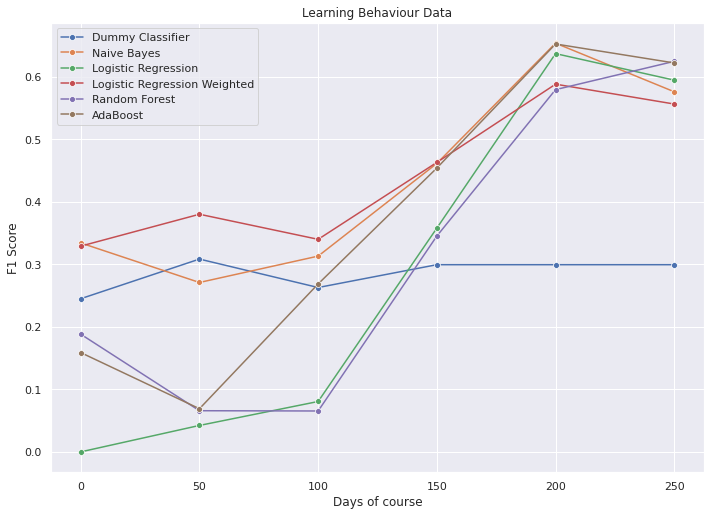

In [ ]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

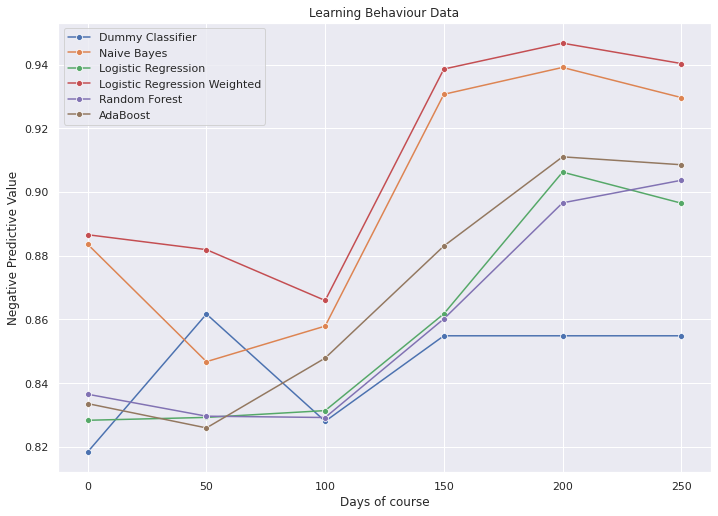

In [ ]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

#### Performance data

##### Prepare data for prediction

In [ ]:
performance_df = {}
for i in list(df.keys())[1:]:
  performance_df[i] = split_dataframe_by_data_type(df[i], ['performance'], include_final_result=True)

In [ ]:
performance_df[50]

code_presentation  id_student  weighted_score  score  final_result
0                2013J       35355          13.846   86.0             0
1                2013J       42638          13.363   83.0             0
2                2013J       43564          15.134   94.0             0
3                2013J       54062          12.558   78.0             0
4                2013J       63112          14.168   88.0             0
...                ...         ...             ...    ...           ...
1943             2014J     2644404          14.007   87.0             0
1944             2014J     2654928          14.651   91.0             0
1945             2014J     2663195          14.651   91.0             0
1946             2014J     2686053          13.846   86.0             0
1947             2014J     2686712          16.100  100.0             1

[1948 rows x 5 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(performance_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')


In [ ]:
X_train[50]

weighted_score     score
0          0.810811  0.810811
1          0.770270  0.770270
2          0.918919  0.918919
3          0.702703  0.702703
4          0.837838  0.837838
..              ...       ...
702        0.554054  0.554054
703        0.527027  0.527027
704        0.770270  0.770270
705        0.743243  0.743243
706        0.472973  0.472973

[707 rows x 2 columns]

###### Undersampling

In [ ]:
Y_train[50].value_counts()

0    567
1    140
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in list(df.keys())[1:]:

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 50
Original dataset shape: Counter({0: 567, 1: 140})
Resample dataset shape Counter({0: 140, 1: 140})
Sampling for day 100
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 150
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 200
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 250
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 141, 1: 141})


##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

performance_results_du = []
performance_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_du.append([acc, f1, prec, recall, conf])
  performance_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.432
Best parameters set:
Accuracy: 0.5197452229299363, F1 Score: 0.30825688073394497, Precision: 0.20537897310513448, Recall: 0.6176470588235294


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.448
Best parameters set:
Accuracy: 0.4879594423320659, F1 Score: 0.26277372262773724, Precision: 0.17518248175182483, Recall: 0.5255474452554745


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.448
Best parameters set:
Accuracy: 0.5139240506329114, F1 Score: 0.29927007299270075, Precision: 0.19951338199513383, Recall: 0.5985401459854015


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.

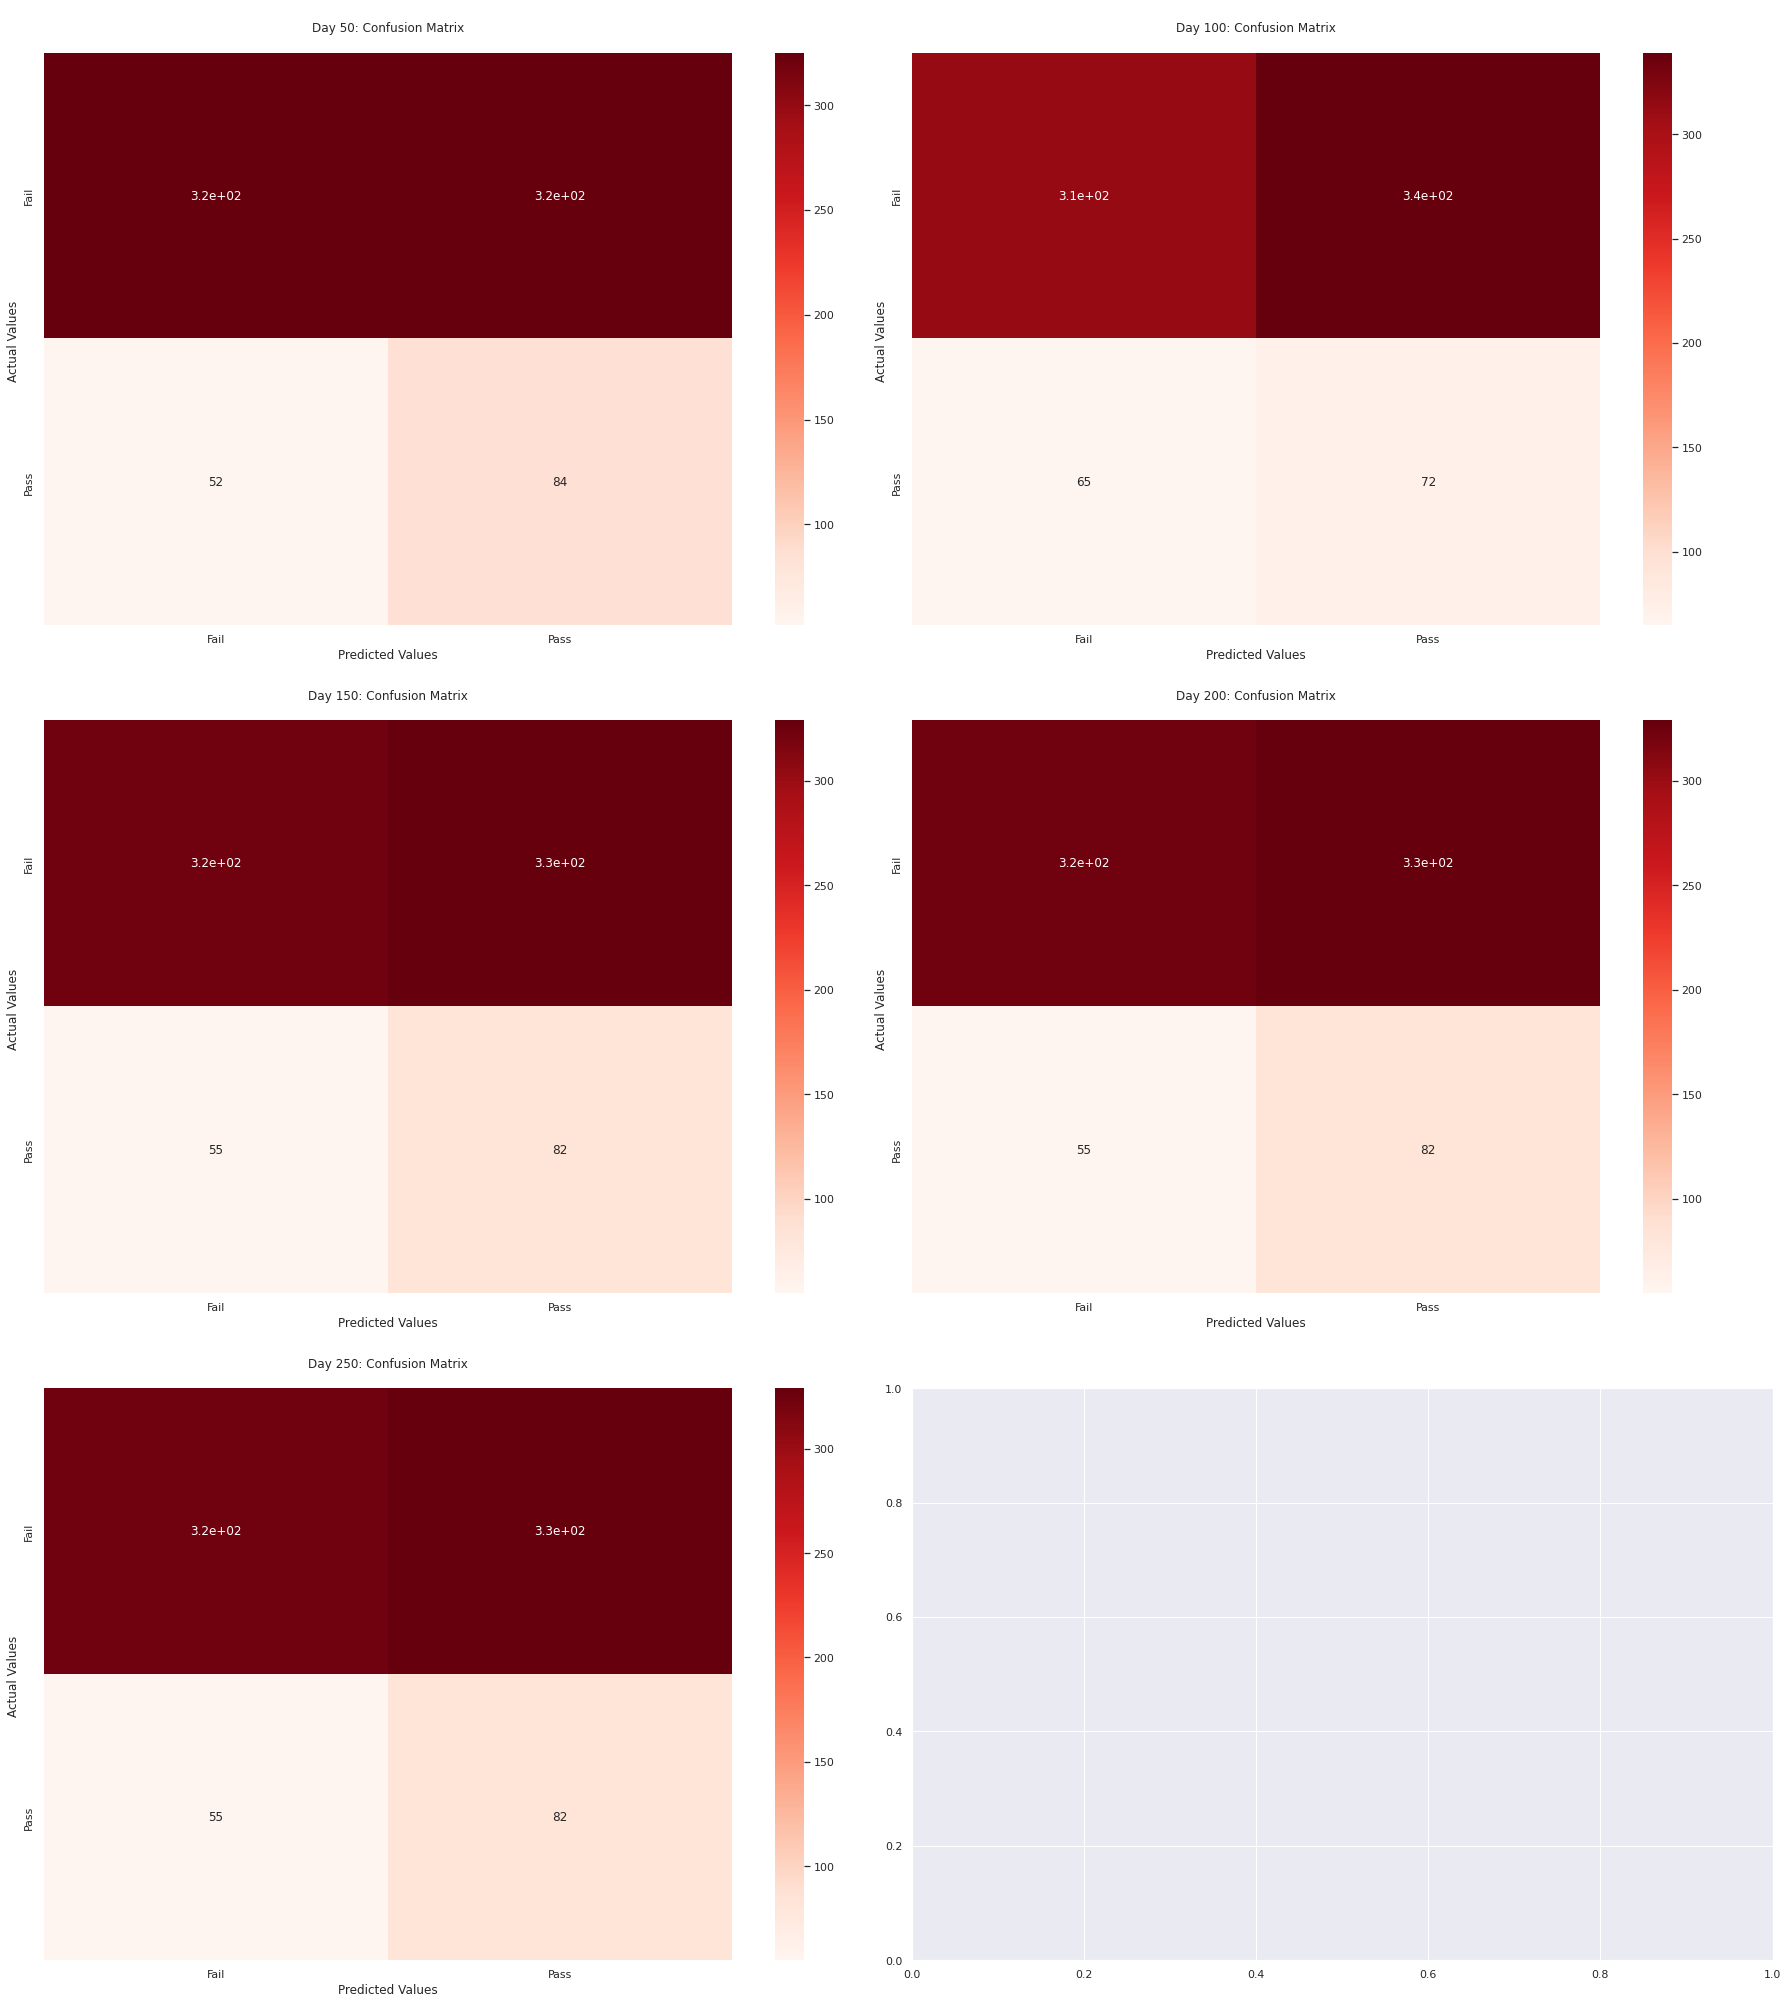

In [ ]:
plot_confusion_matrix(performance_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

performance_results_nb = []
performance_features_nb = []

performance_predict_proba_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])

  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_nb.append([acc, f1, prec, recall, conf])
  performance_features_nb.append([tuned_model, X_test[i], Y_test[i]])

  performance_predict_proba_nb.append(predictions_proba)

  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.445
Best parameters set:
Accuracy: 0.8267515923566879, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.708
Best parameters set:
Accuracy: 0.8542458808618505, F1 Score: 0.3850267379679144, Precision: 0.72, Recall: 0.26277372262773724


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.812
Best parameters set:
Accuracy: 0.8886075949367088, F1 Score: 0.6173913043478261, Precision: 0.7634408602150538, Recall: 0.5182481751824818


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.832
Best parameters set:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9088607594936708, F1 Score: 0.7049180327868853, Precision: 0.8037383177570093, Recall: 0.6277372262773723


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.832
Best parameters set:
Accuracy: 0.9088607594936708, F1 Score: 0.7049180327868853, Precision: 0.8037383177570093, Recall: 0.6277372262773723




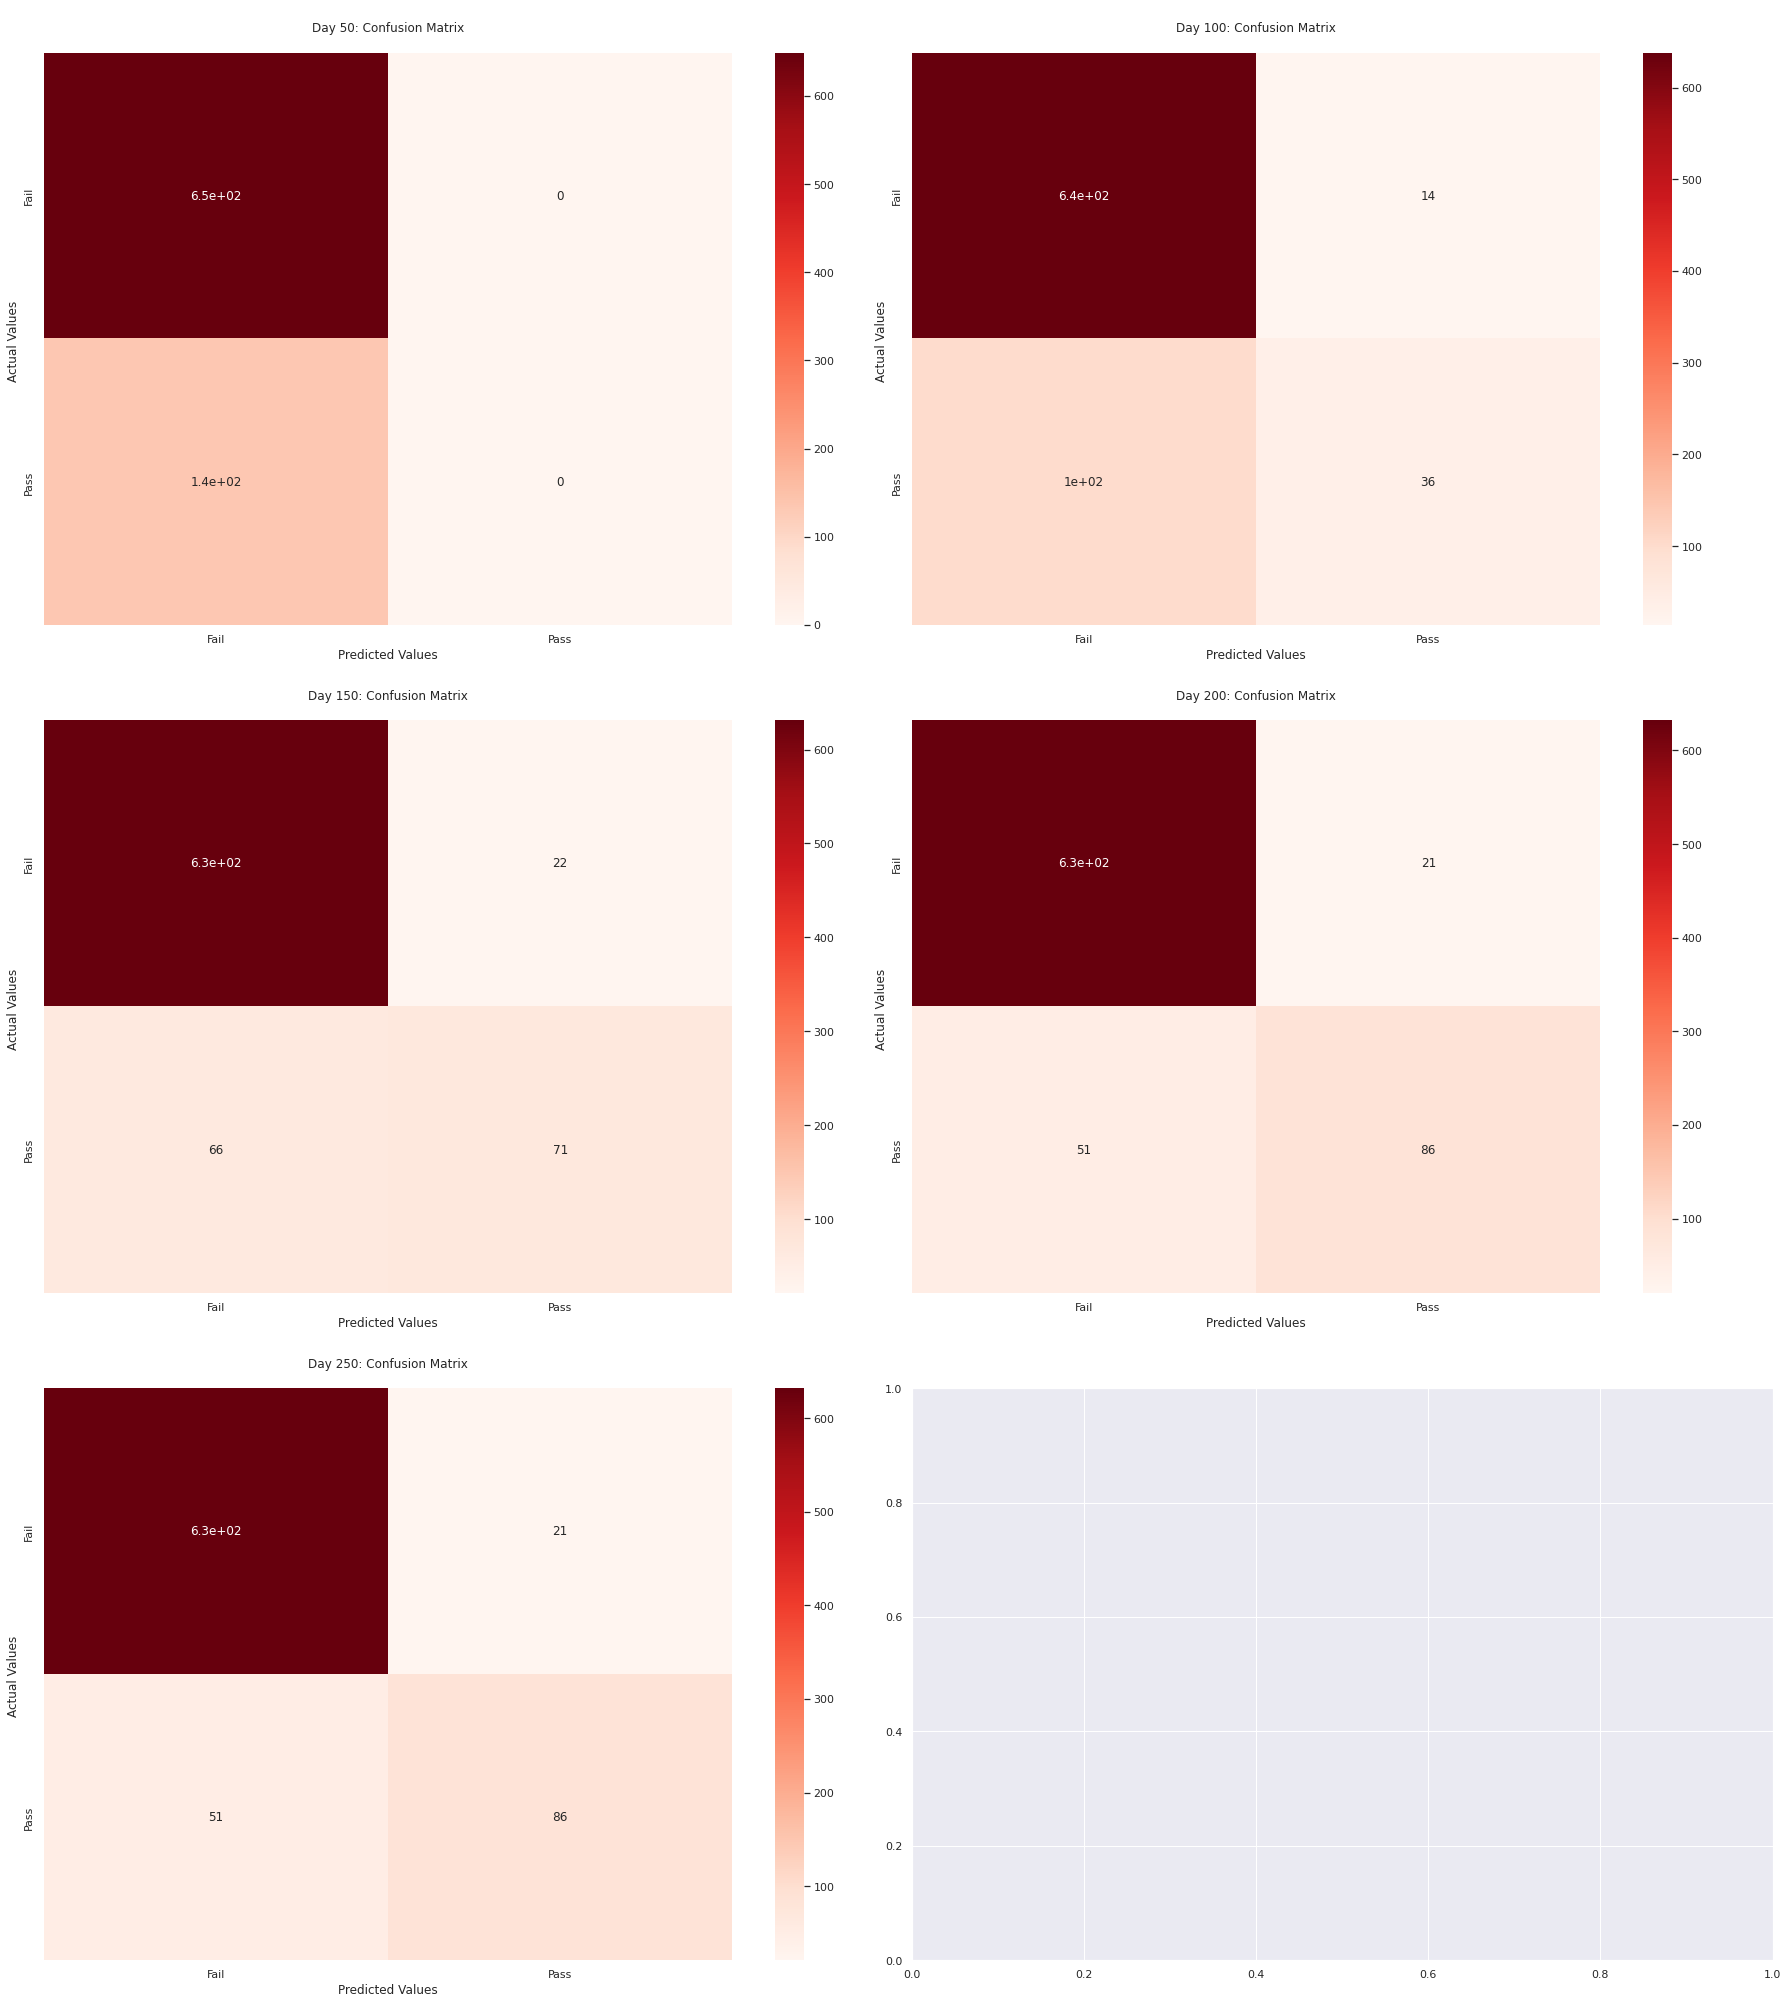

In [ ]:
plot_confusion_matrix(performance_results_nb)

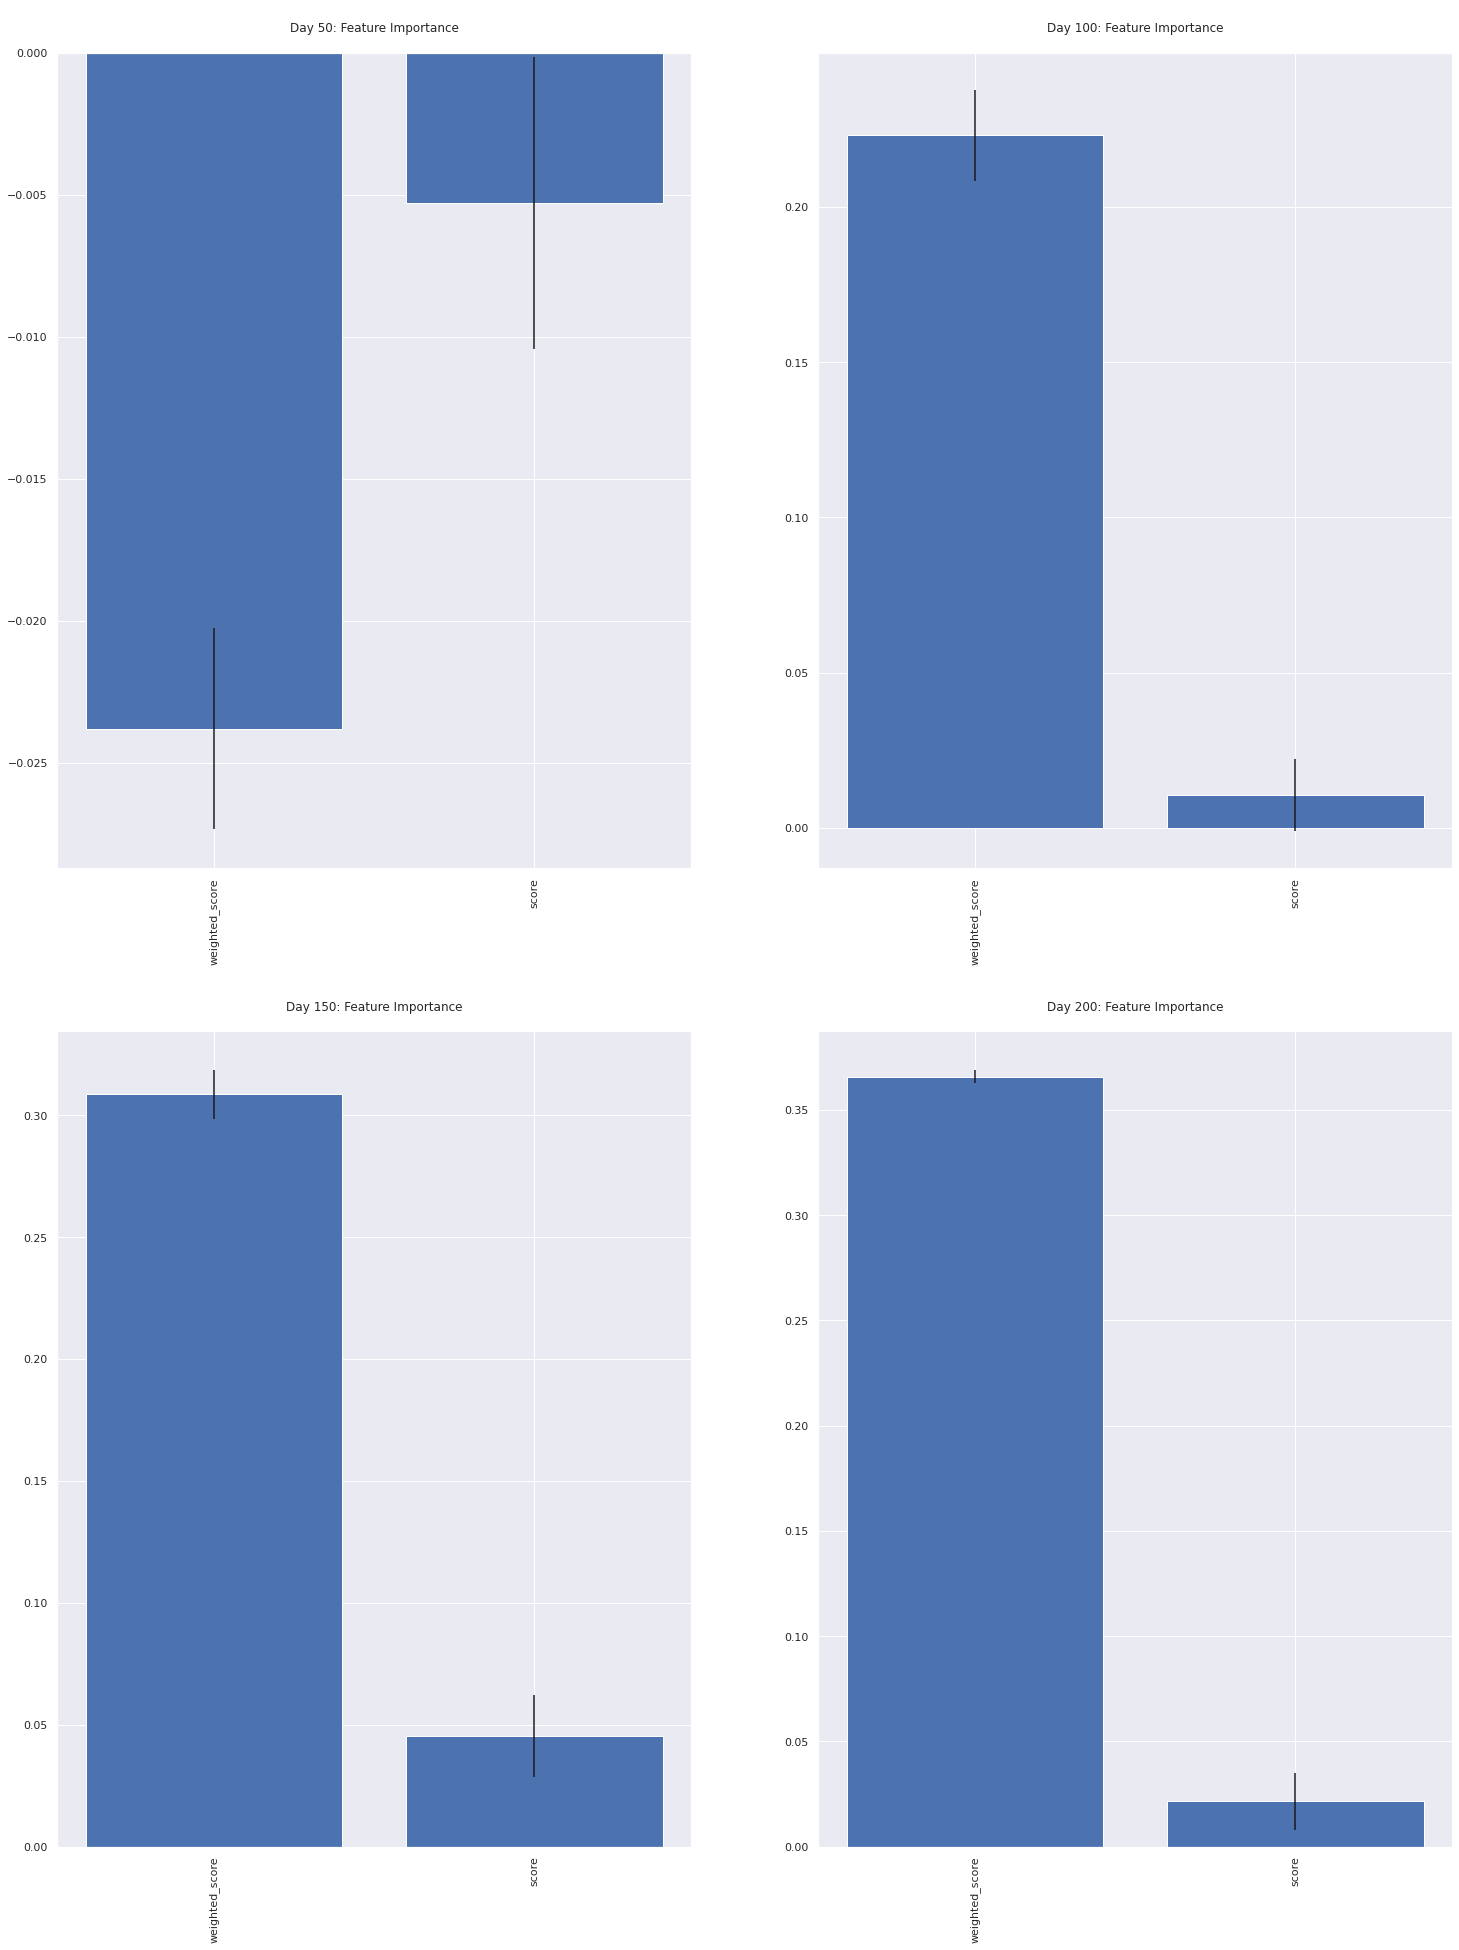

In [ ]:
plot_feature_importance(performance_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

performance_results_lr = []
performance_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lr.append([acc, f1, prec, recall, conf])
  performance_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.653
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8394904458598726, F1 Score: 0.2840909090909091, Precision: 0.625, Recall: 0.18382352941176472


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.745
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8542458808618505, F1 Score: 0.42211055276381915, Precision: 0.6774193548387096, Recall: 0.30656934306569344


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.821
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8987341772151899, F1 Score: 0.6666666666666667, Precision: 0.7766990291262136, Recall: 0.583941605839416


D

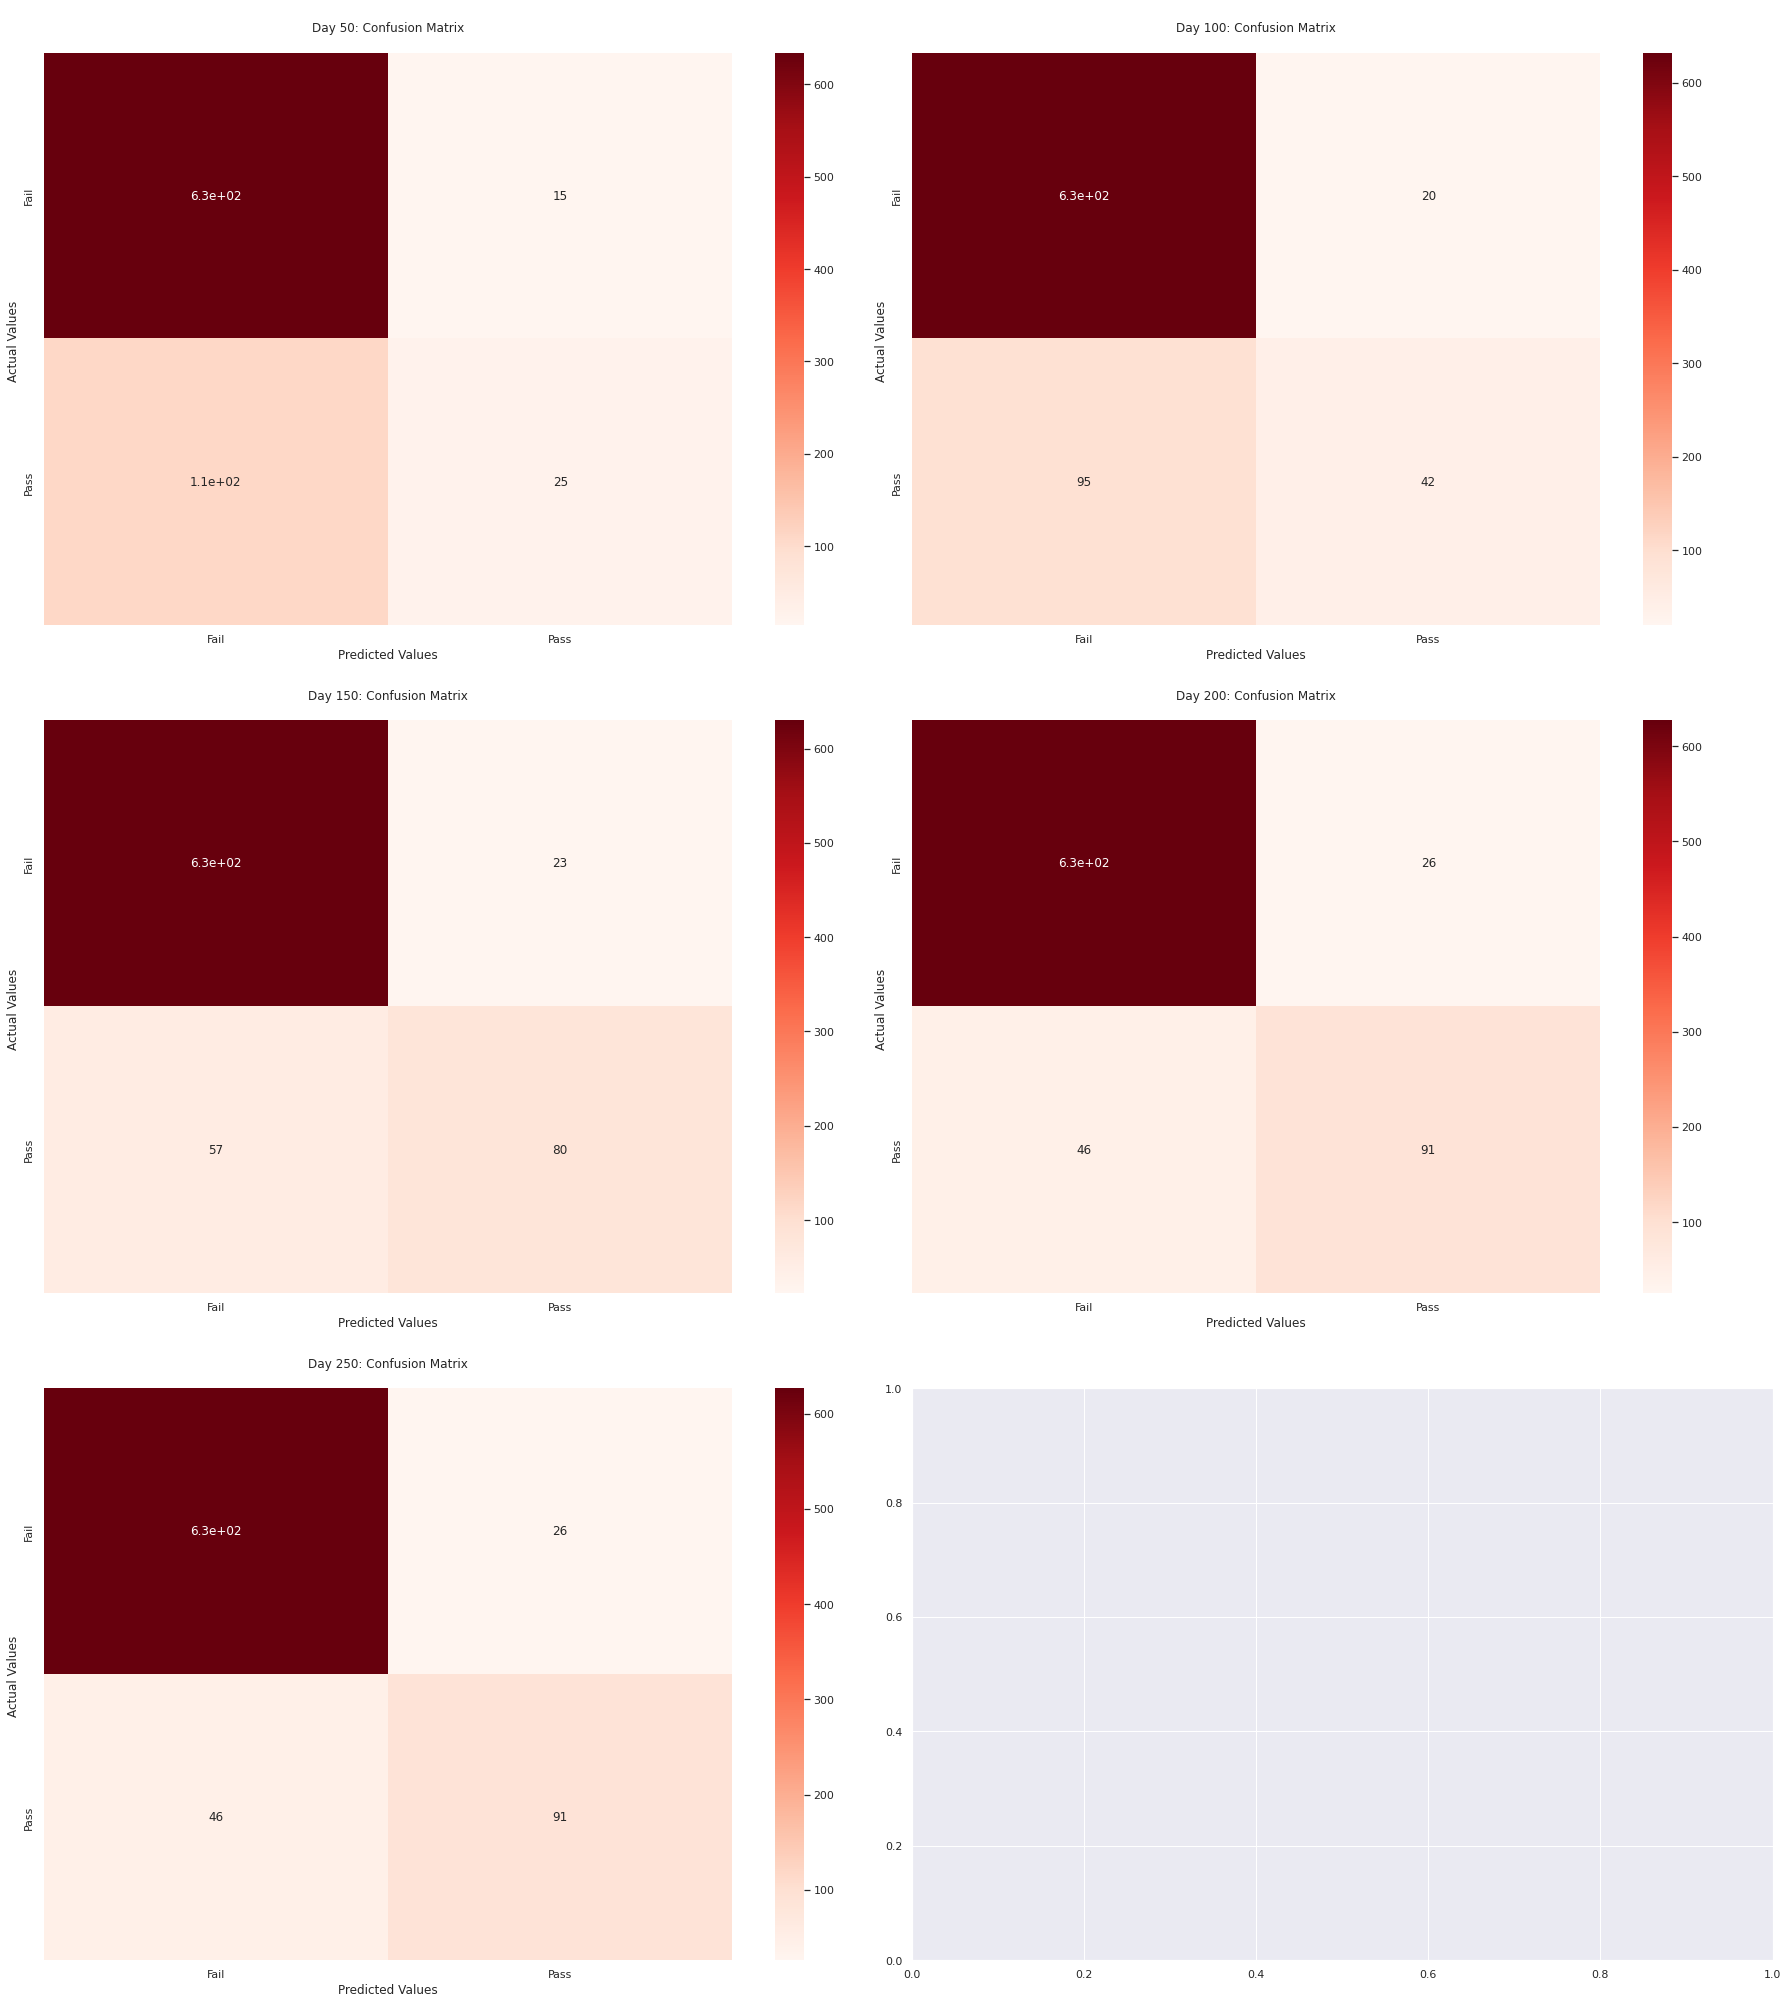

In [ ]:
plot_confusion_matrix(performance_results_lr)

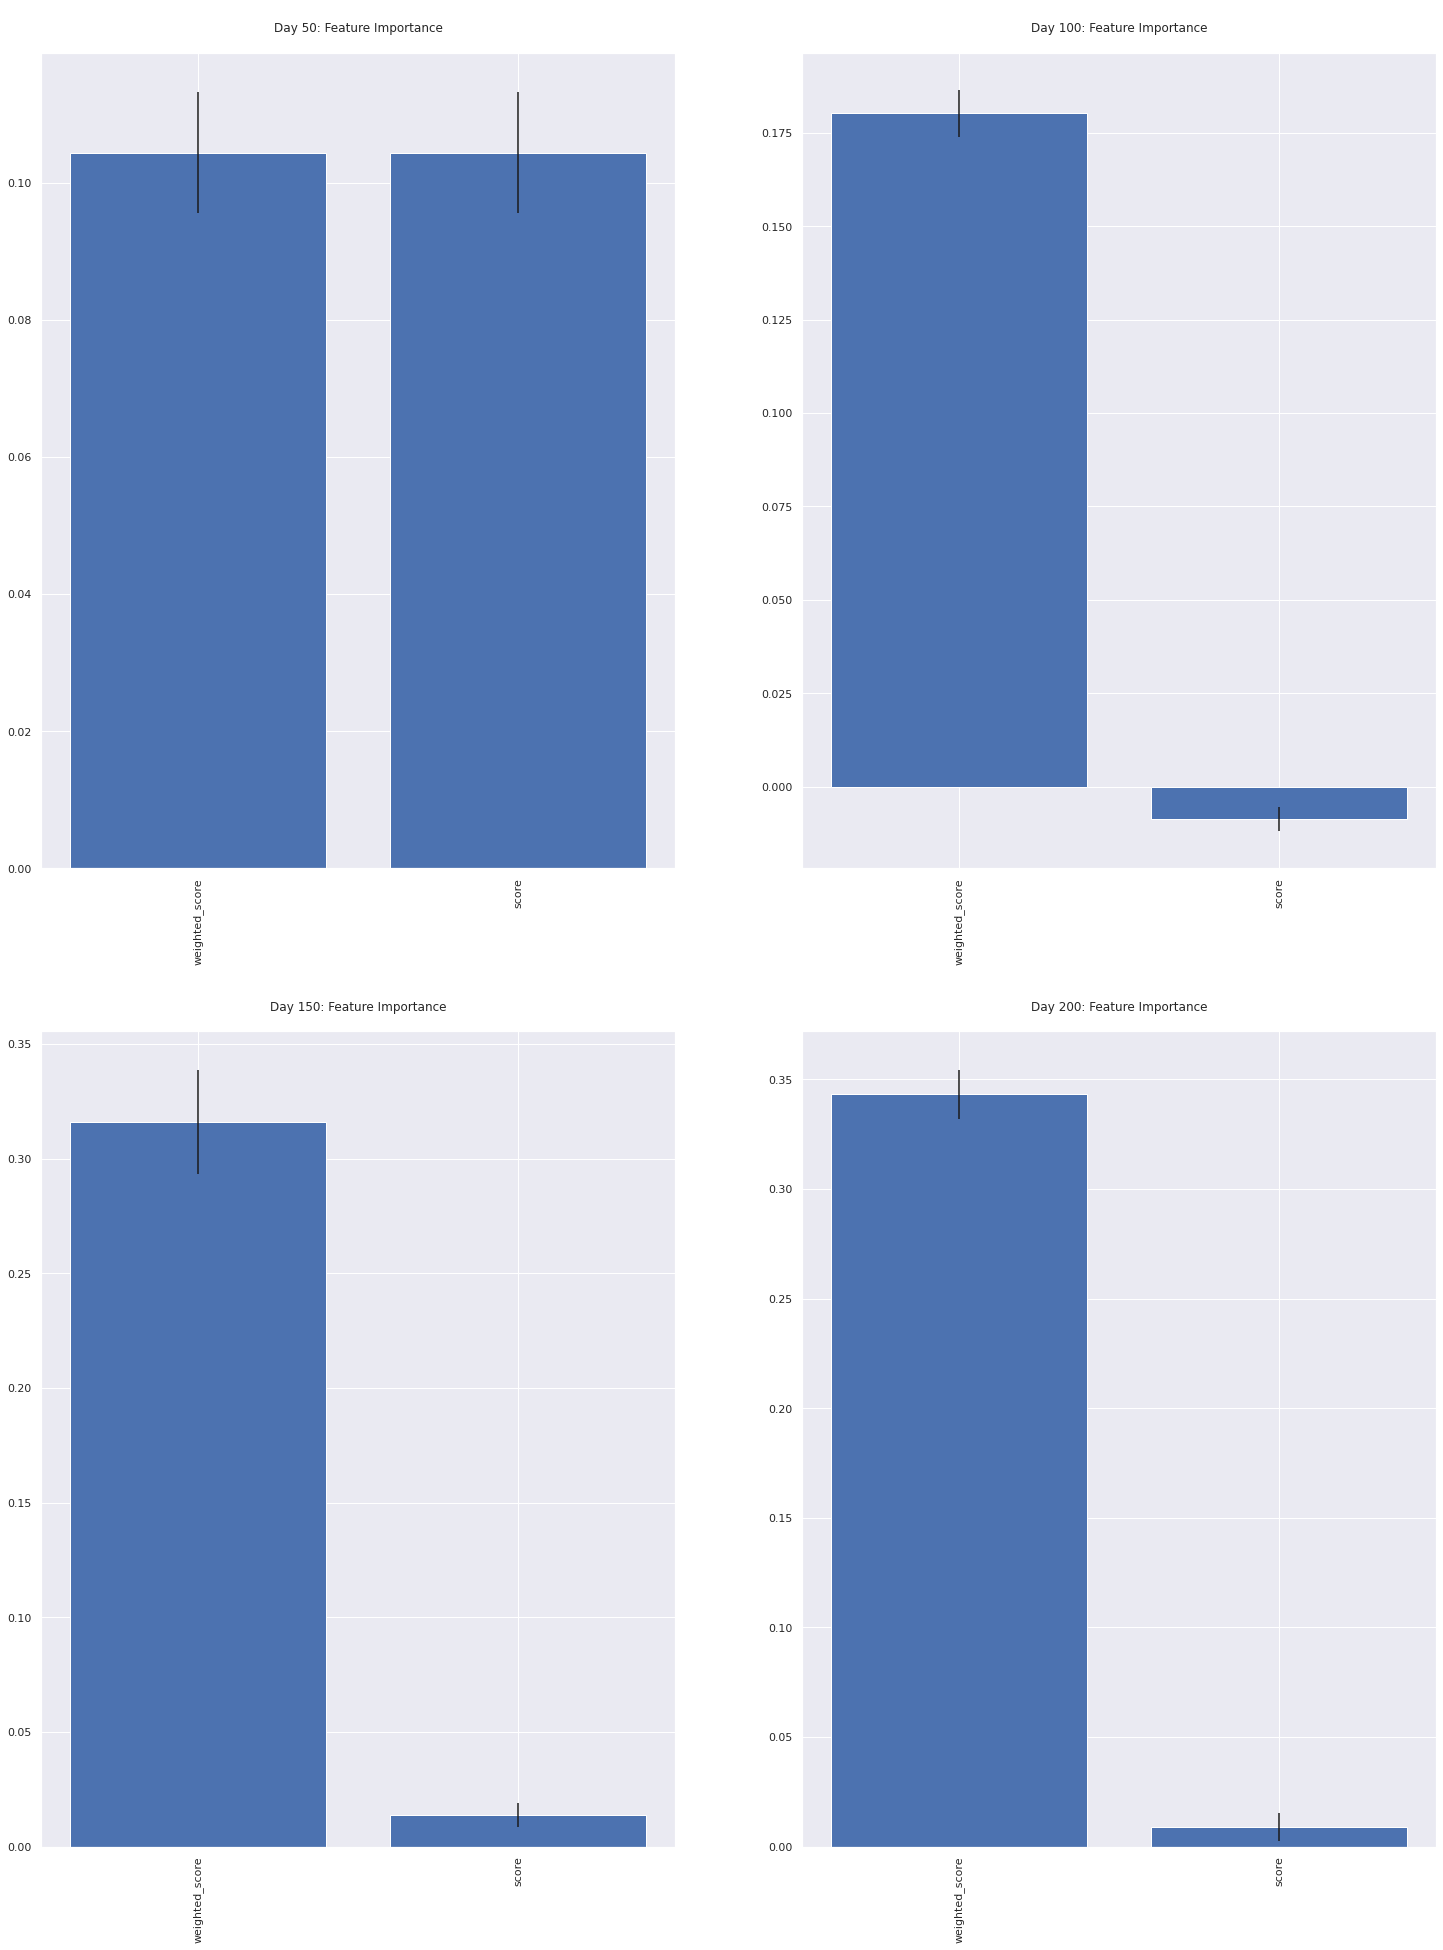

In [ ]:
plot_feature_importance(performance_features_lr)

##### WeightedLogisticRegression

In [ ]:
performance_results_lrw = []
performance_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
  
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lrw.append([acc, f1, prec, recall, conf])
  performance_features_lrw.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.665
Best parameters set:
Accuracy: 0.7656050955414013, F1 Score: 0.39869281045751637, Precision: 0.3588235294117647, Recall: 0.4485294117647059


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.756
Best parameters set:
Accuracy: 0.8250950570342205, F1 Score: 0.5035971223021583, Precision: 0.49645390070921985, Recall: 0.5109489051094891


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.818
Best parameters set:
Accuracy: 0.8620253164556962, F1 Score: 0.6305084745762712, Precision: 0.5886075949367089, Recall: 0.6788321167883211


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.849


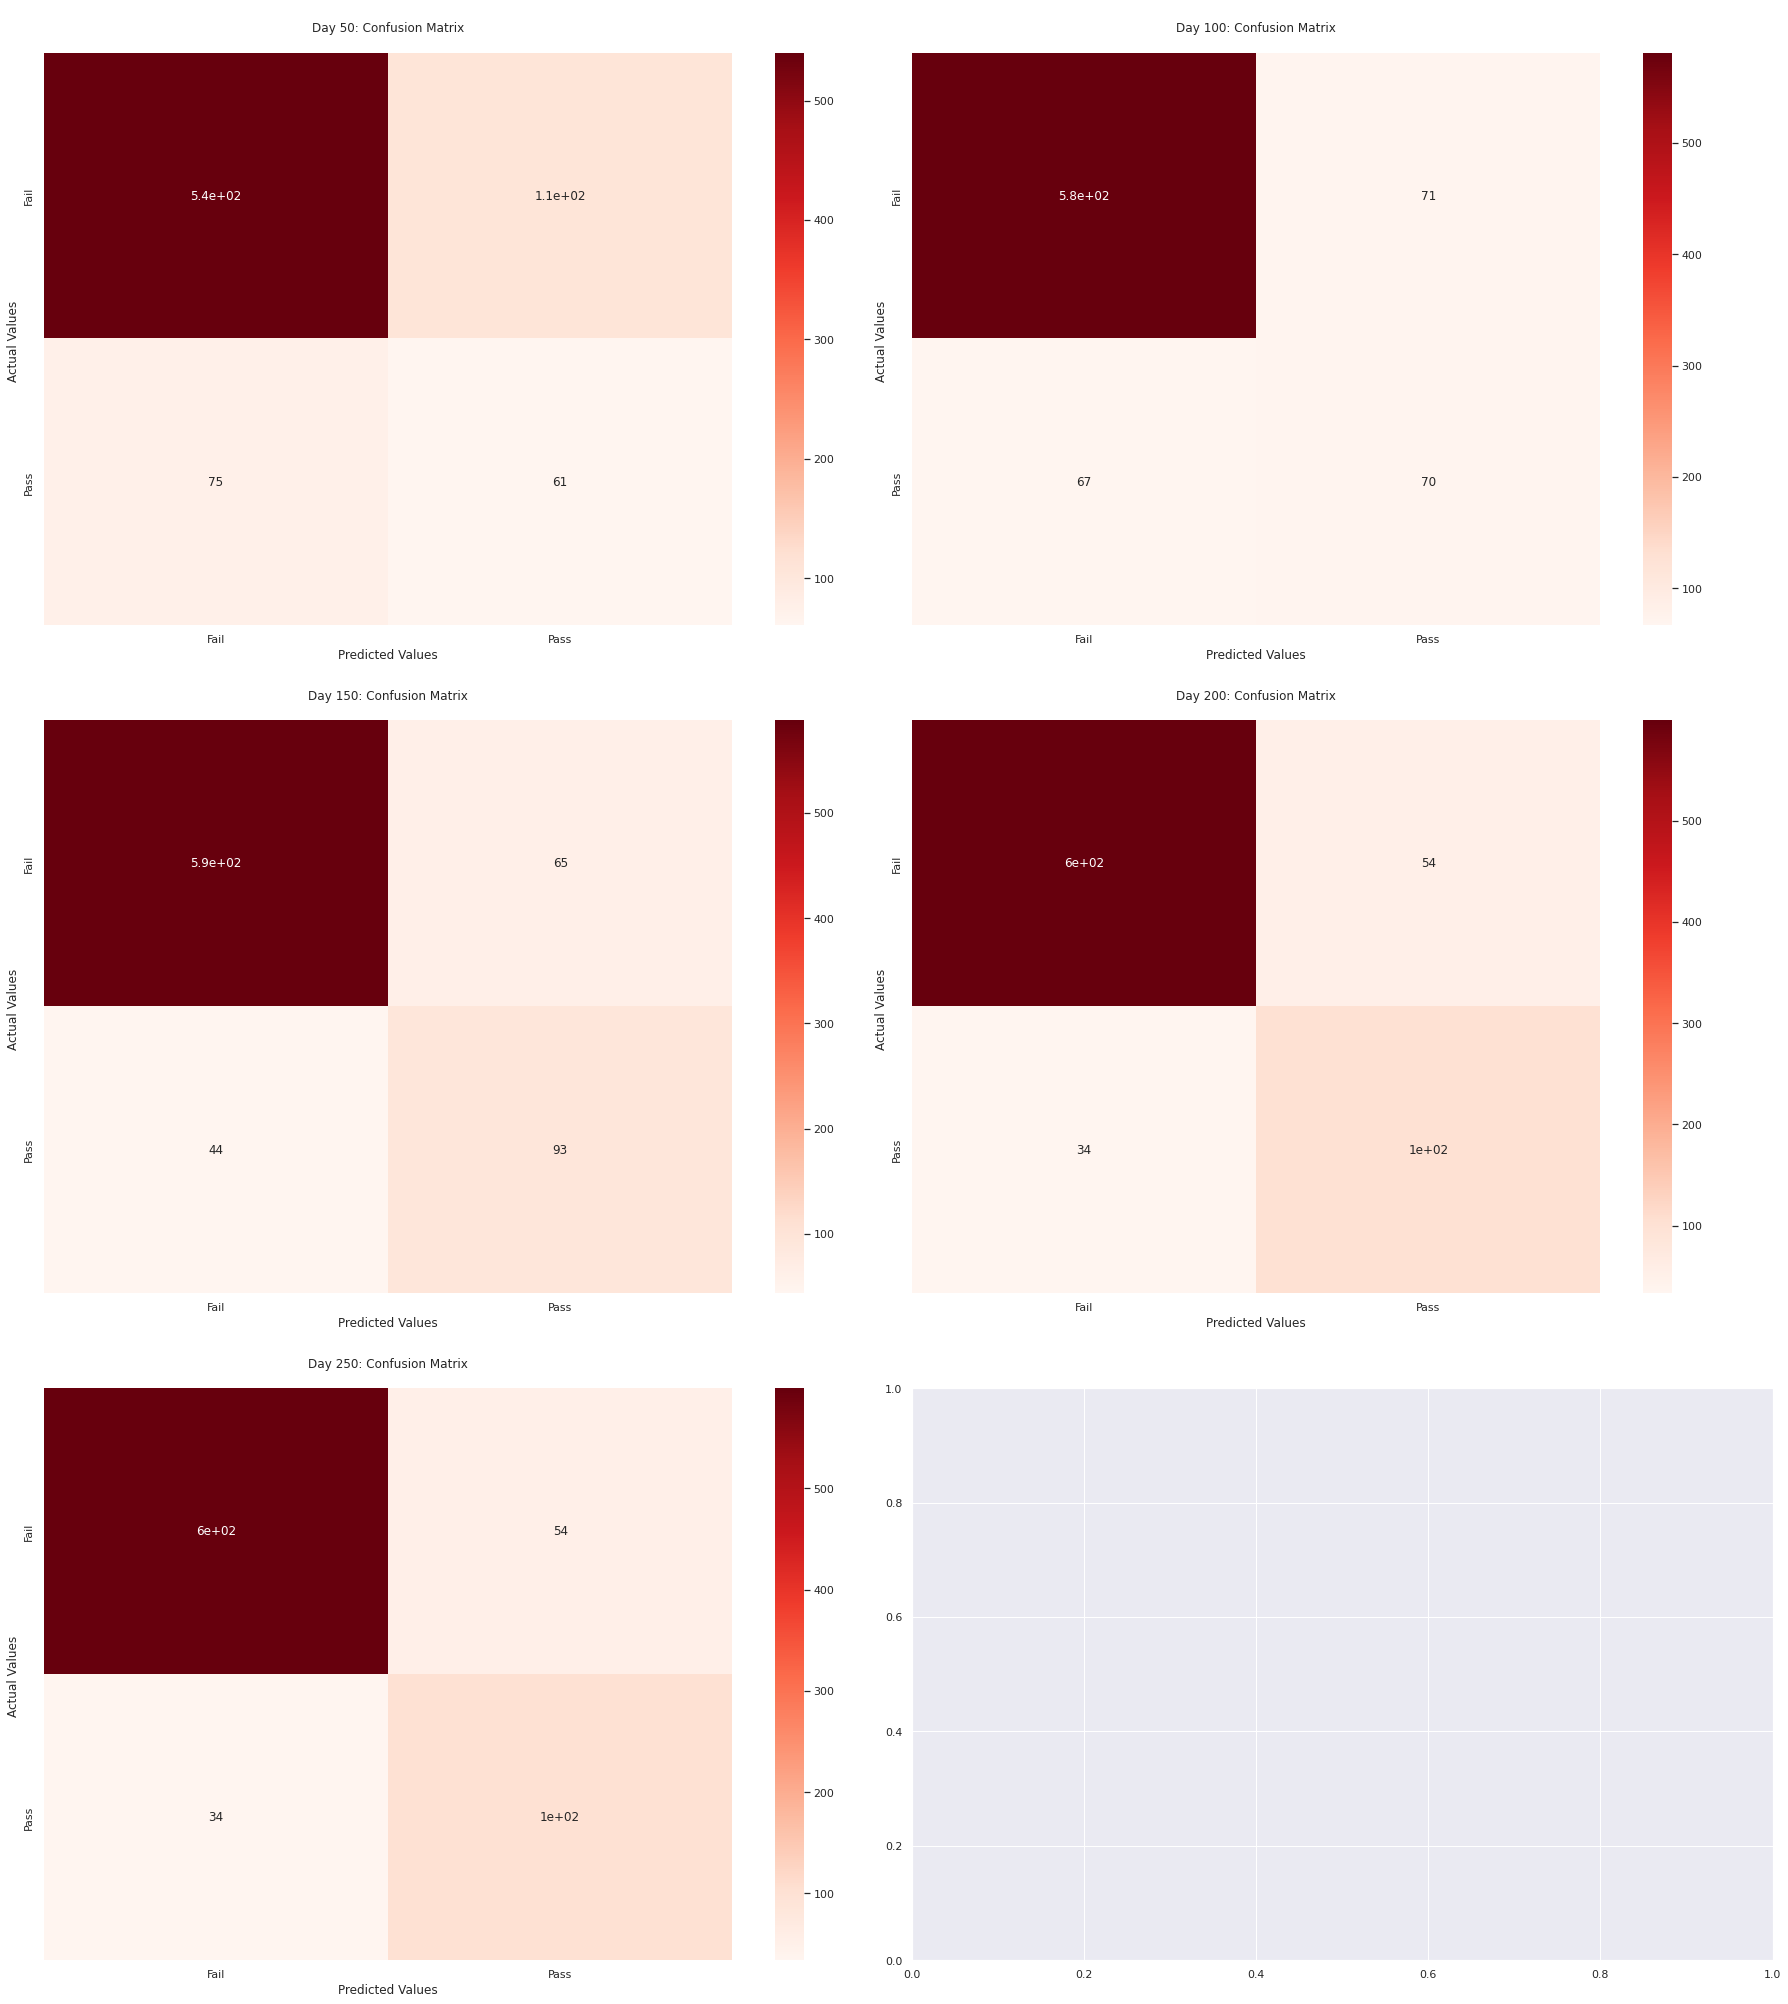

In [ ]:
plot_confusion_matrix(performance_results_lrw)

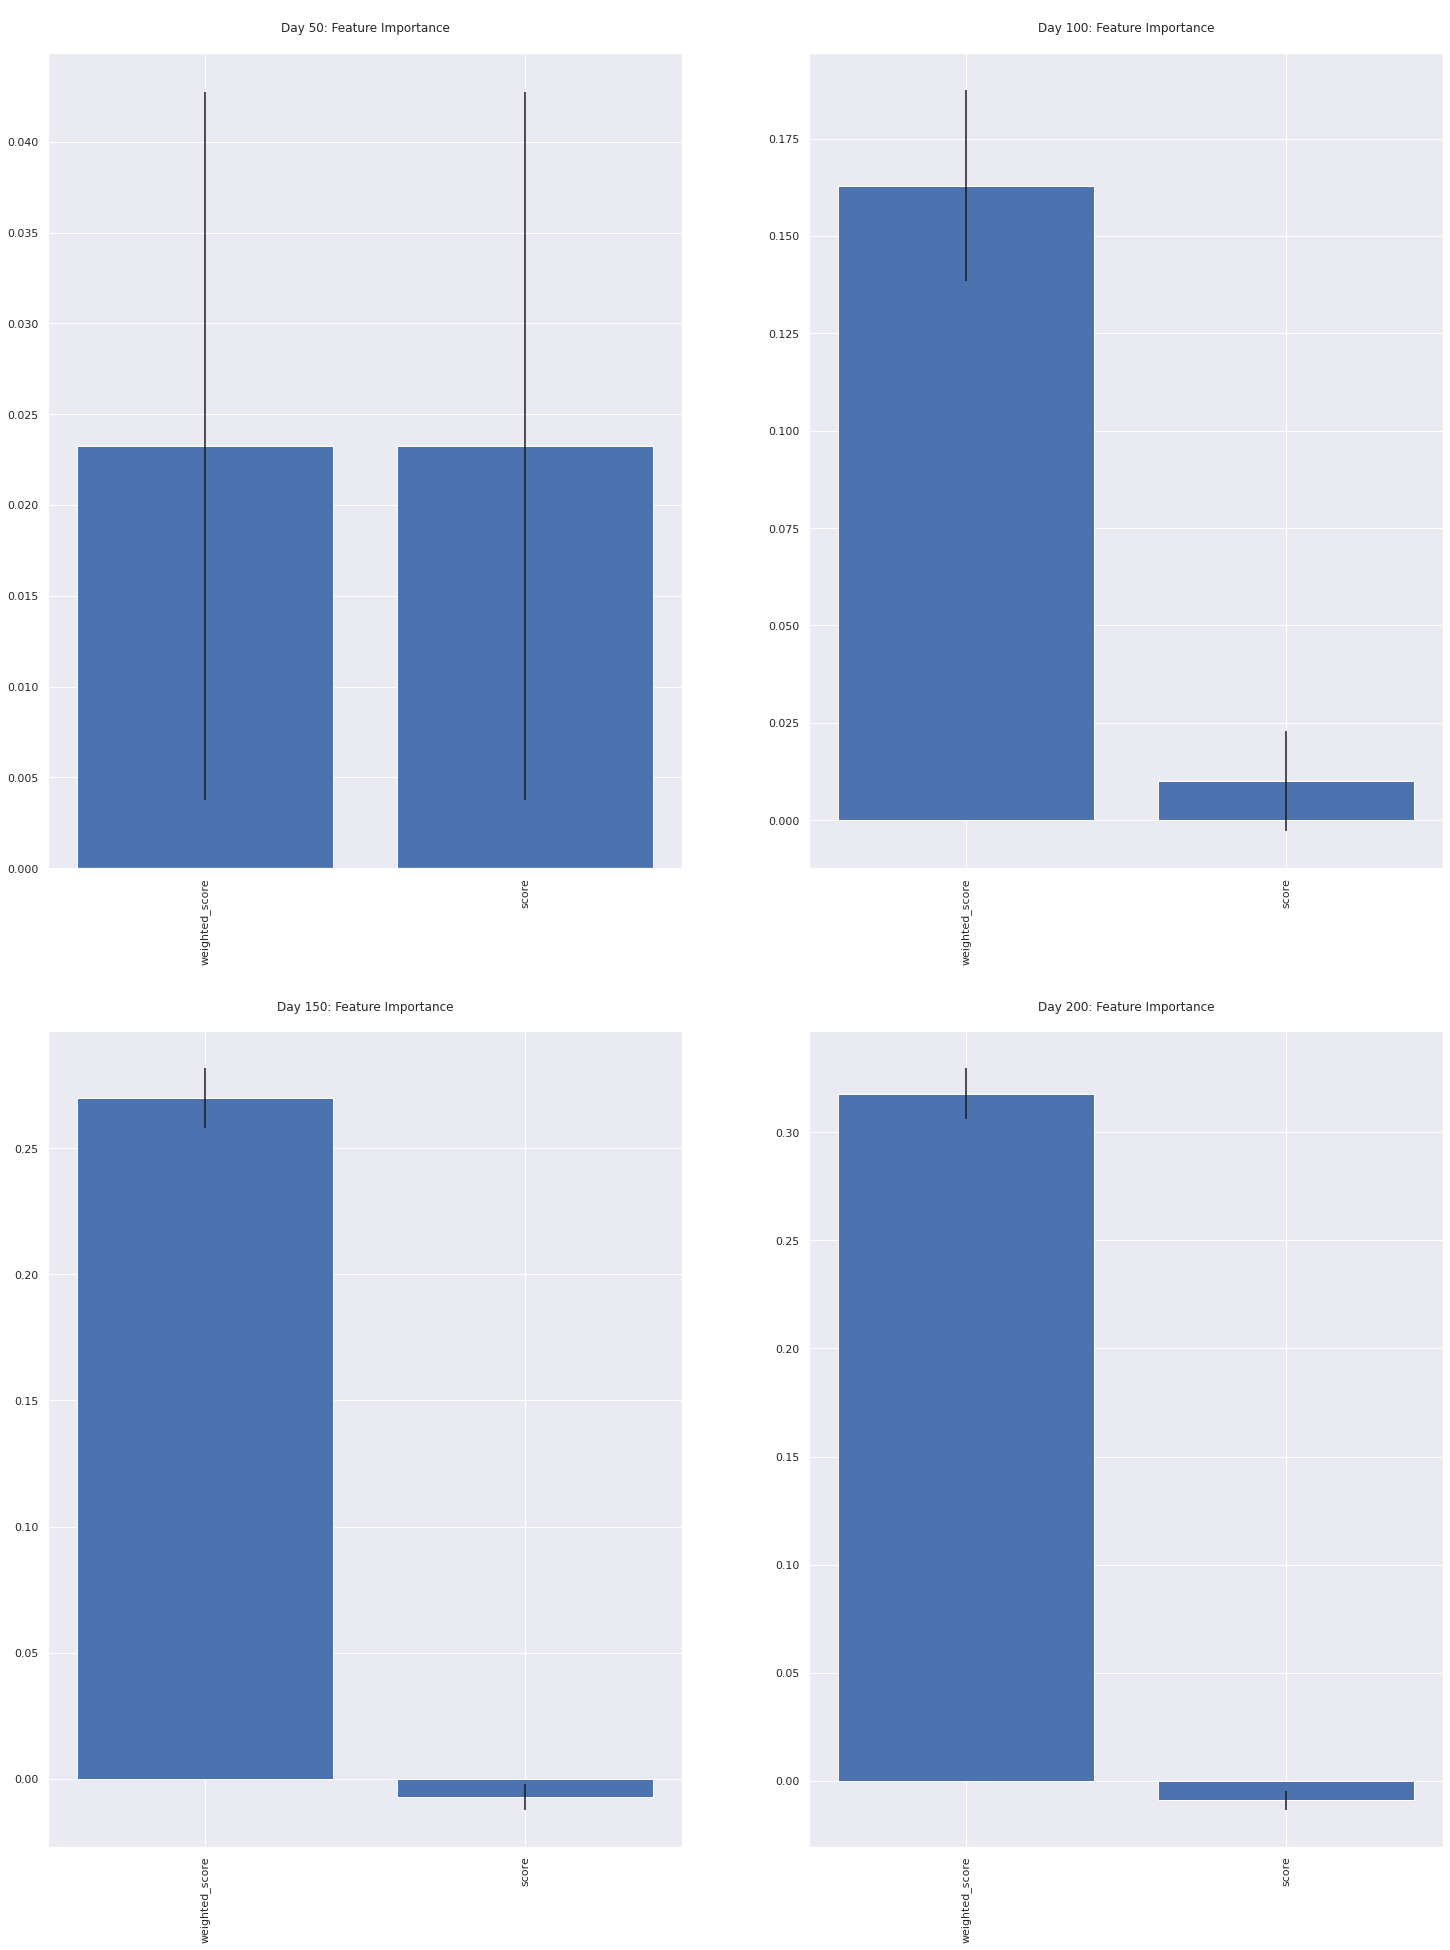

In [ ]:
plot_feature_importance(performance_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

performance_results_rf = []
performance_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_rf.append([acc, f1, prec, recall, conf])
  performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.618
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.802547770700637, F1 Score: 0.36213991769547327, Precision: 0.411214953271028, Recall: 0.3235294117647059


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.724
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.8086185044359949, F1 Score: 0.3836734693877551, Precision: 0.4351851851851852, Recall: 0.34306569343065696


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.788
Best parameters set:
	clf__n_estimato

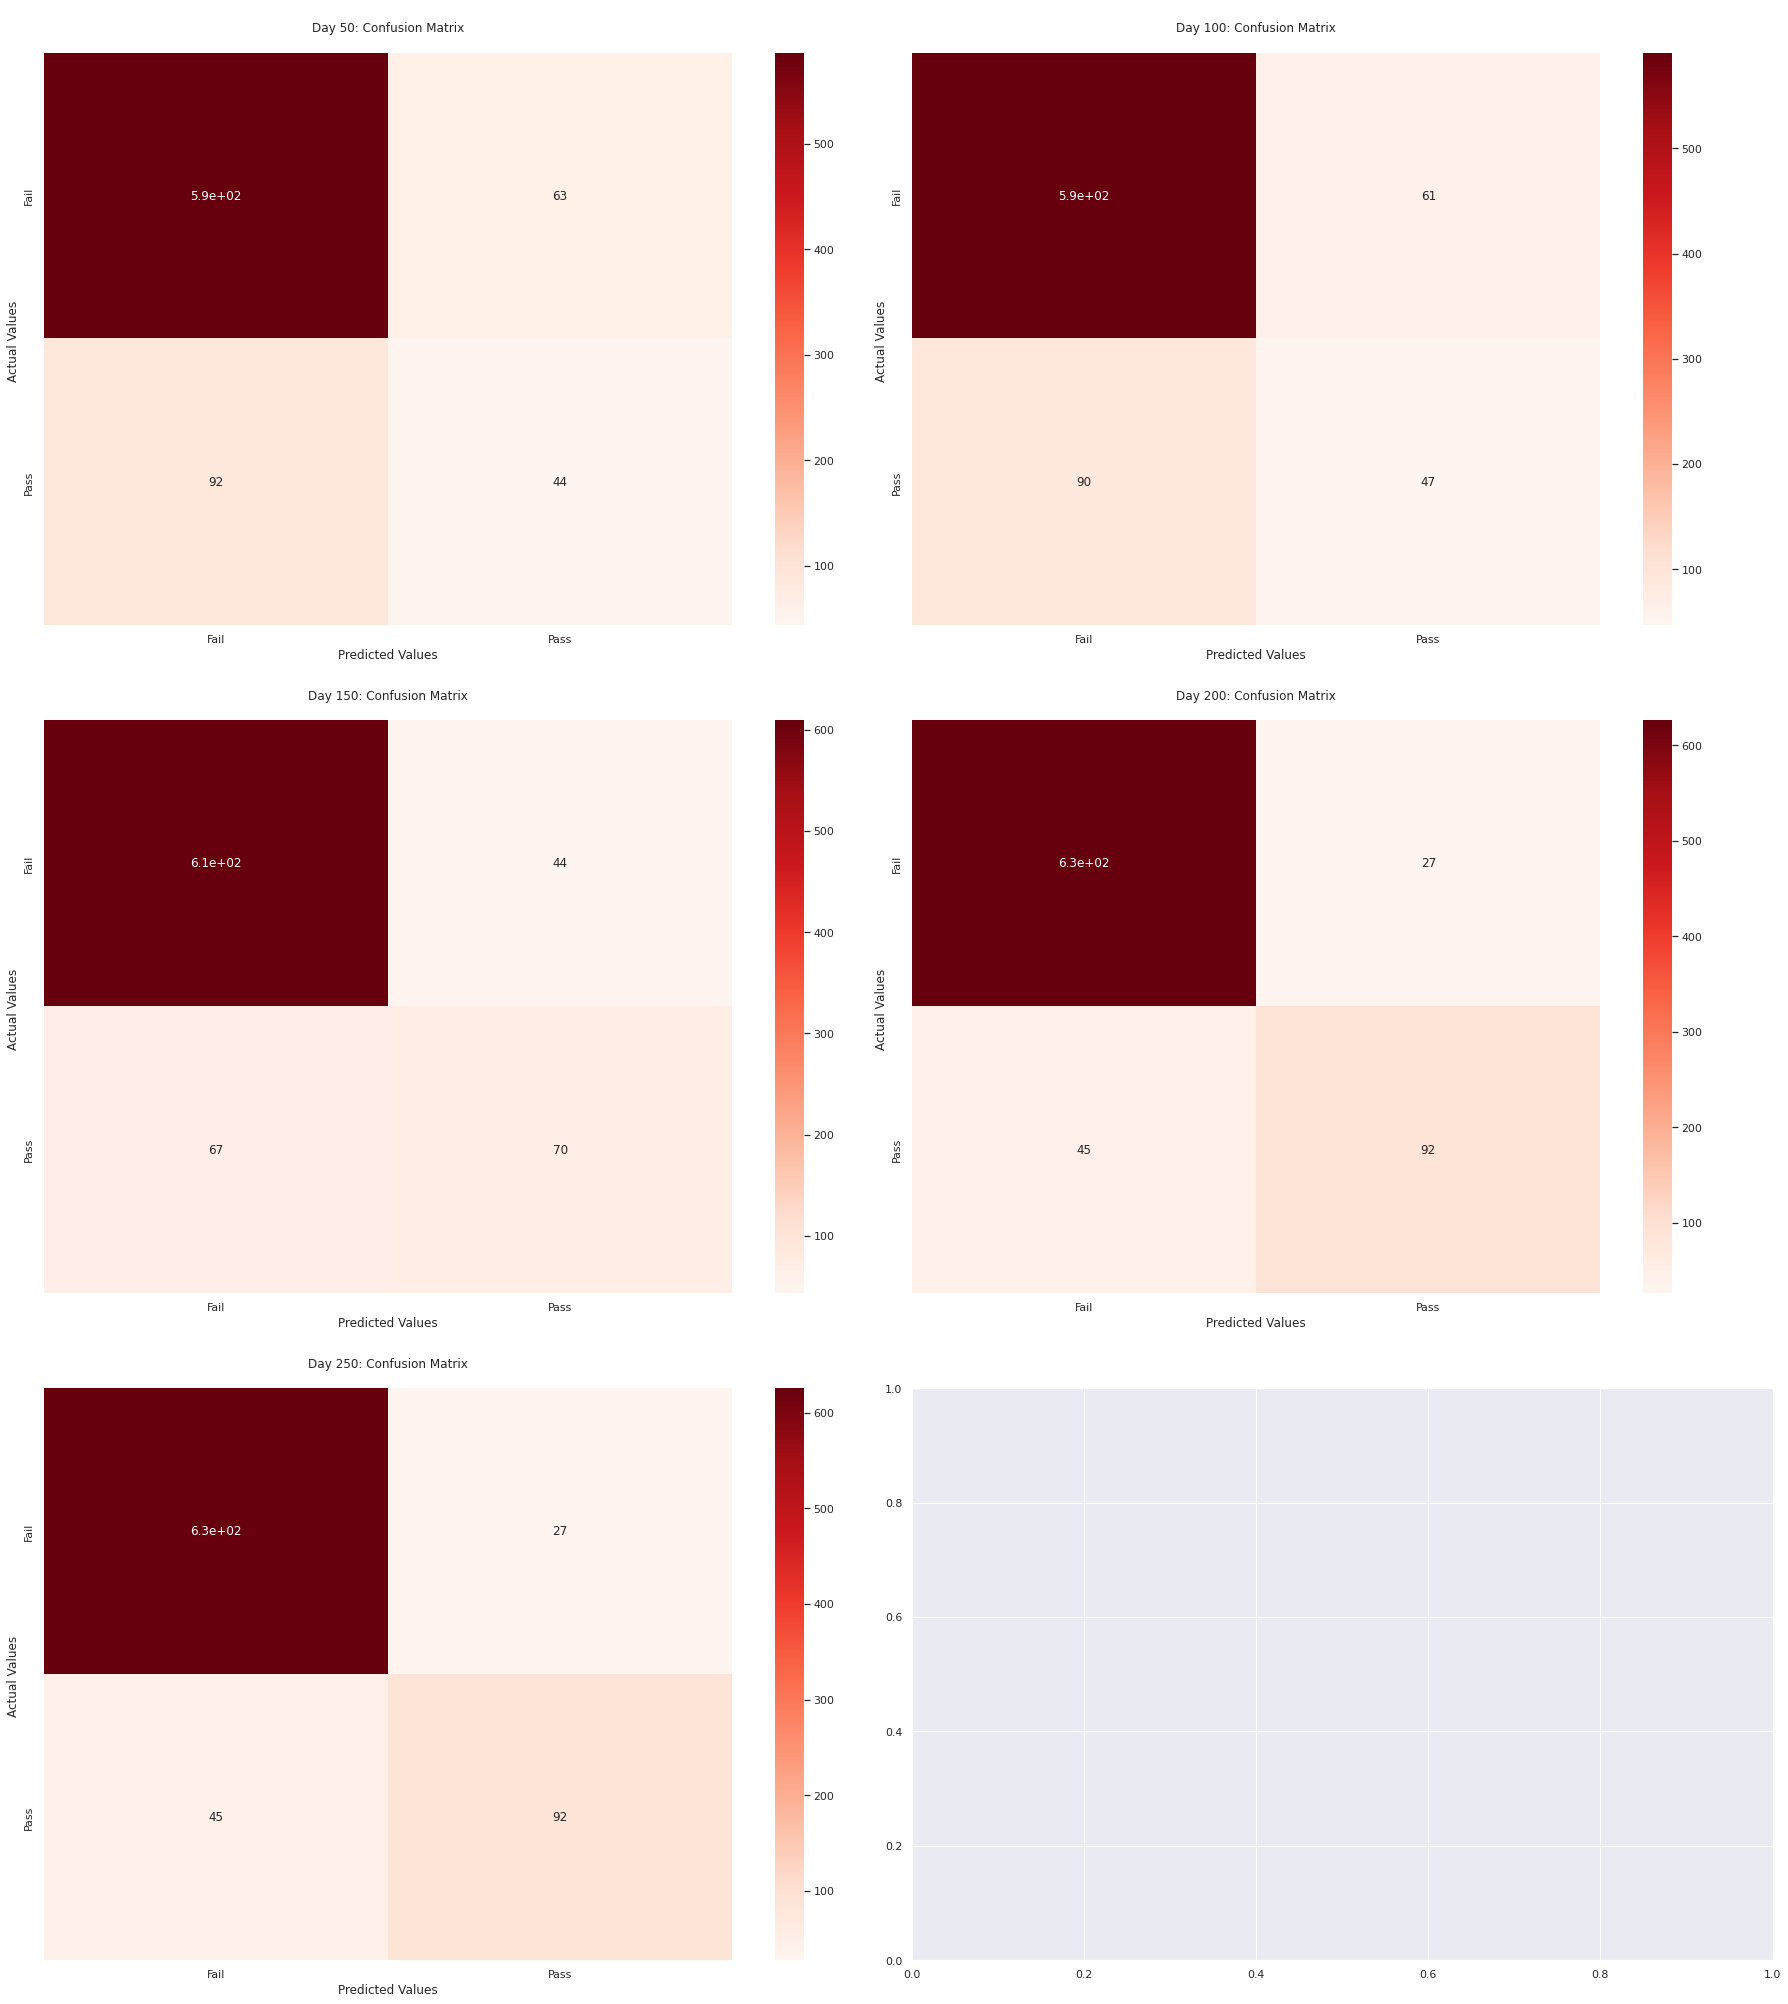

In [ ]:
plot_confusion_matrix(performance_results_rf)

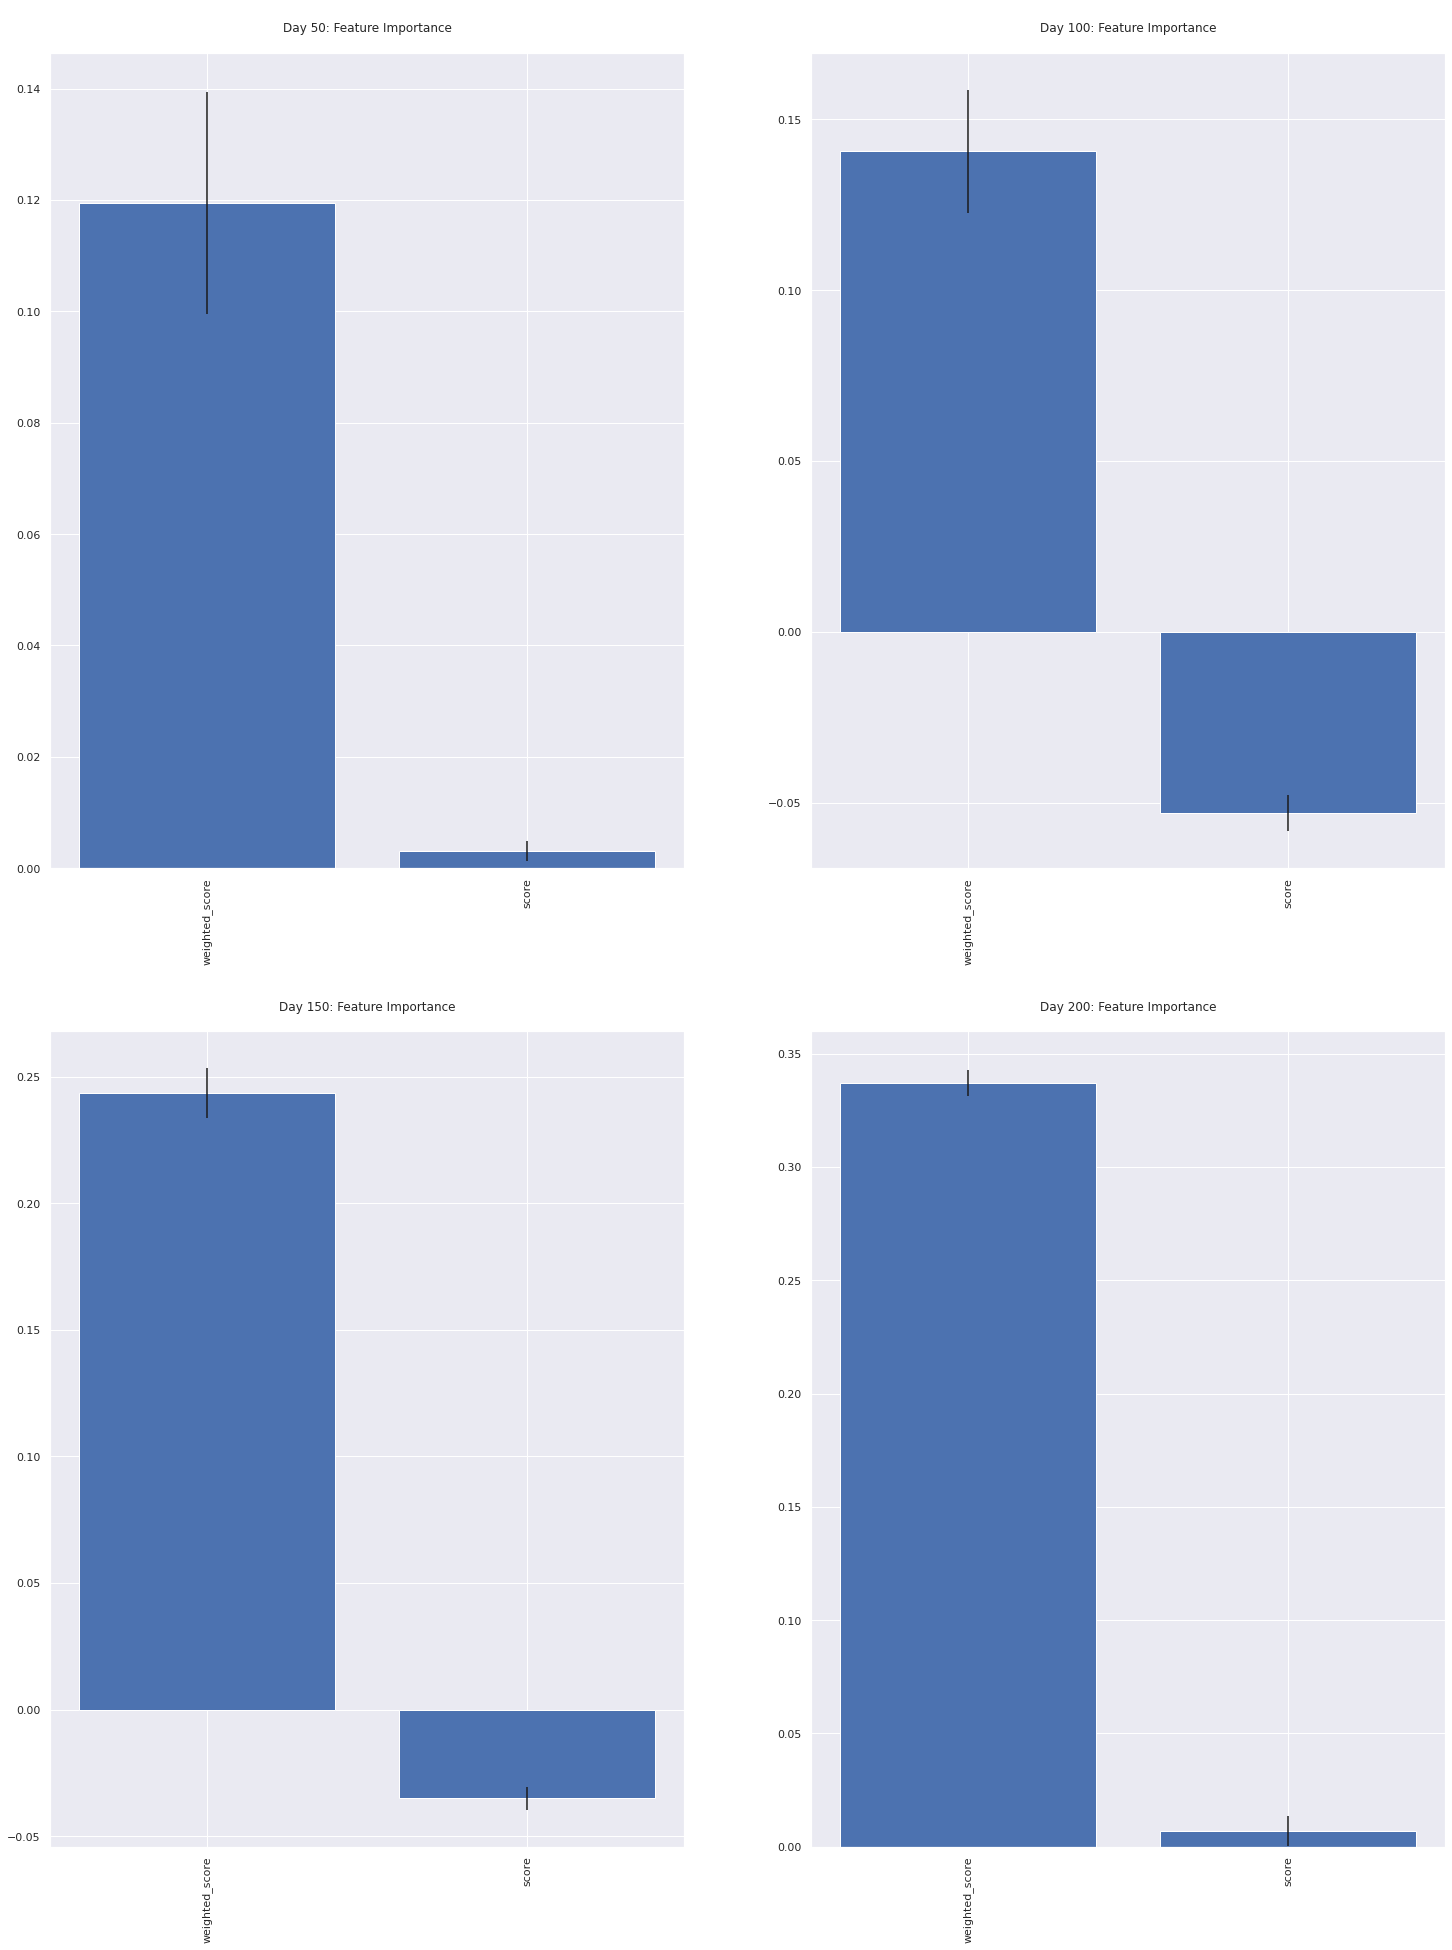

In [ ]:
plot_feature_importance(performance_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

performance_results_ab = []
performance_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_ab.append([acc, f1, prec, recall, conf])
  performance_features_ab.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.628
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.8433121019108281, F1 Score: 0.3050847457627119, Precision: 0.6585365853658537, Recall: 0.19852941176470587


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.724
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8517110266159695, F1 Score: 0.44549763033175355, Precision: 0.6351351351351351, Recall: 0.34306569343065696


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.806
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.8810126582278481

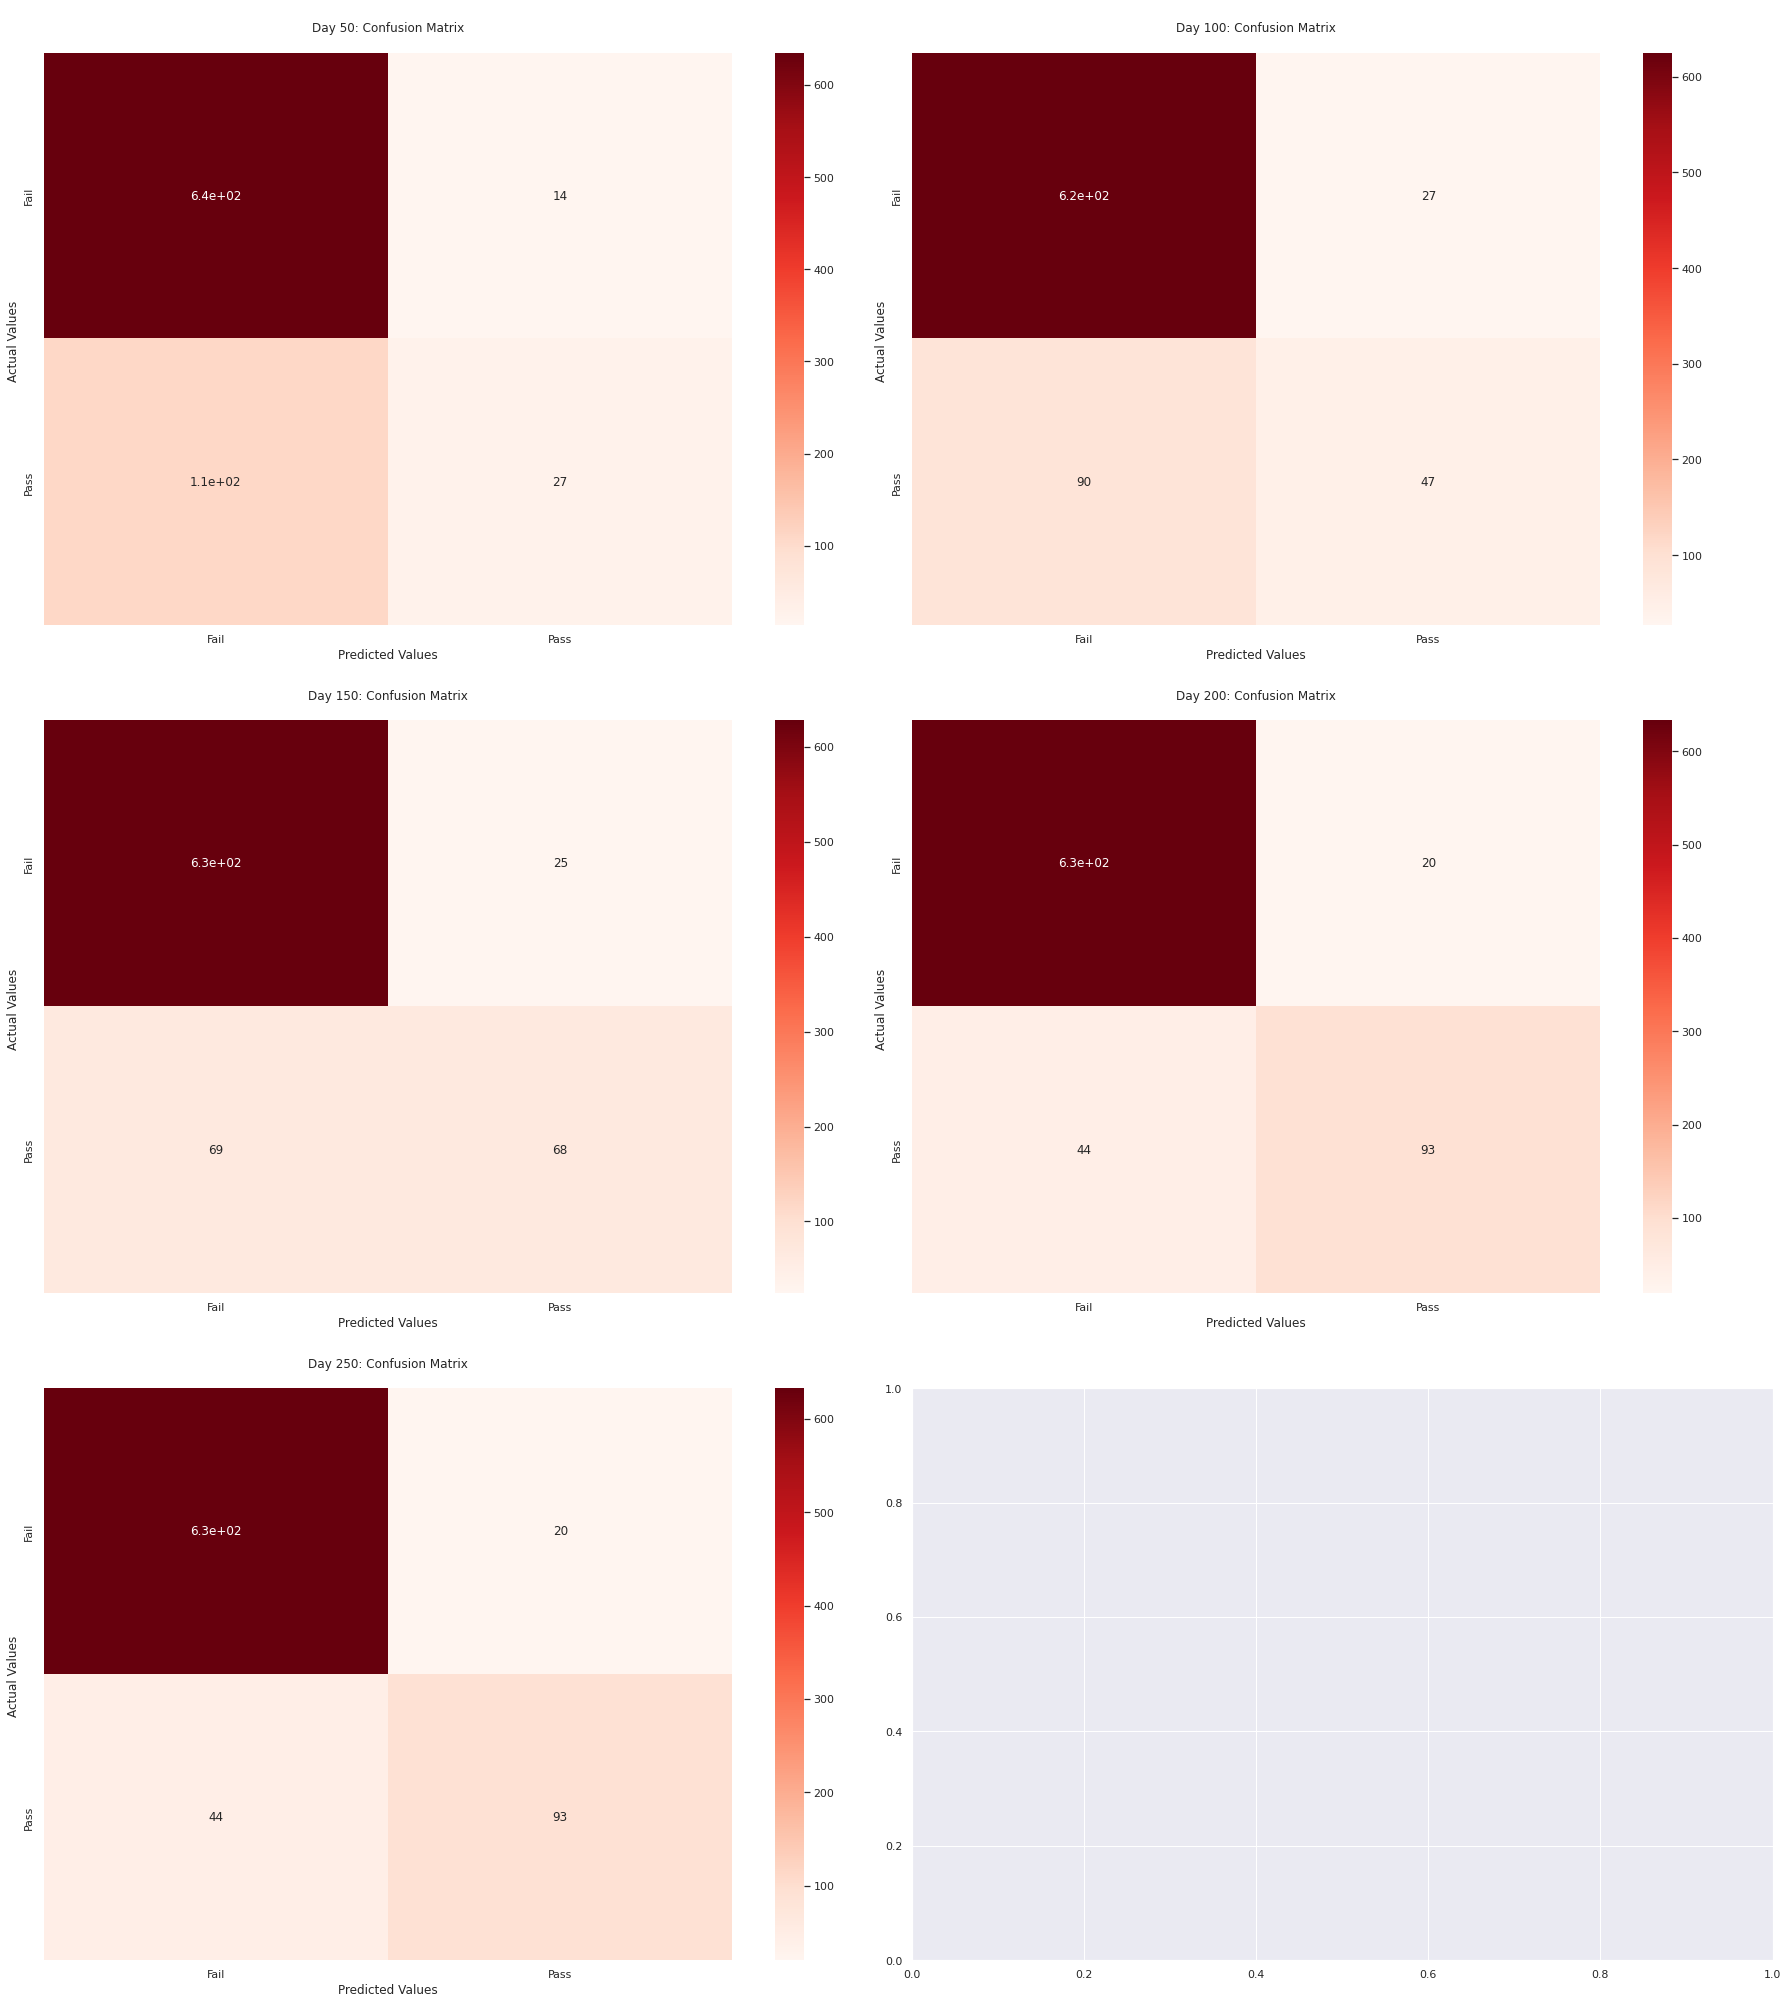

In [ ]:
plot_confusion_matrix(performance_results_ab)

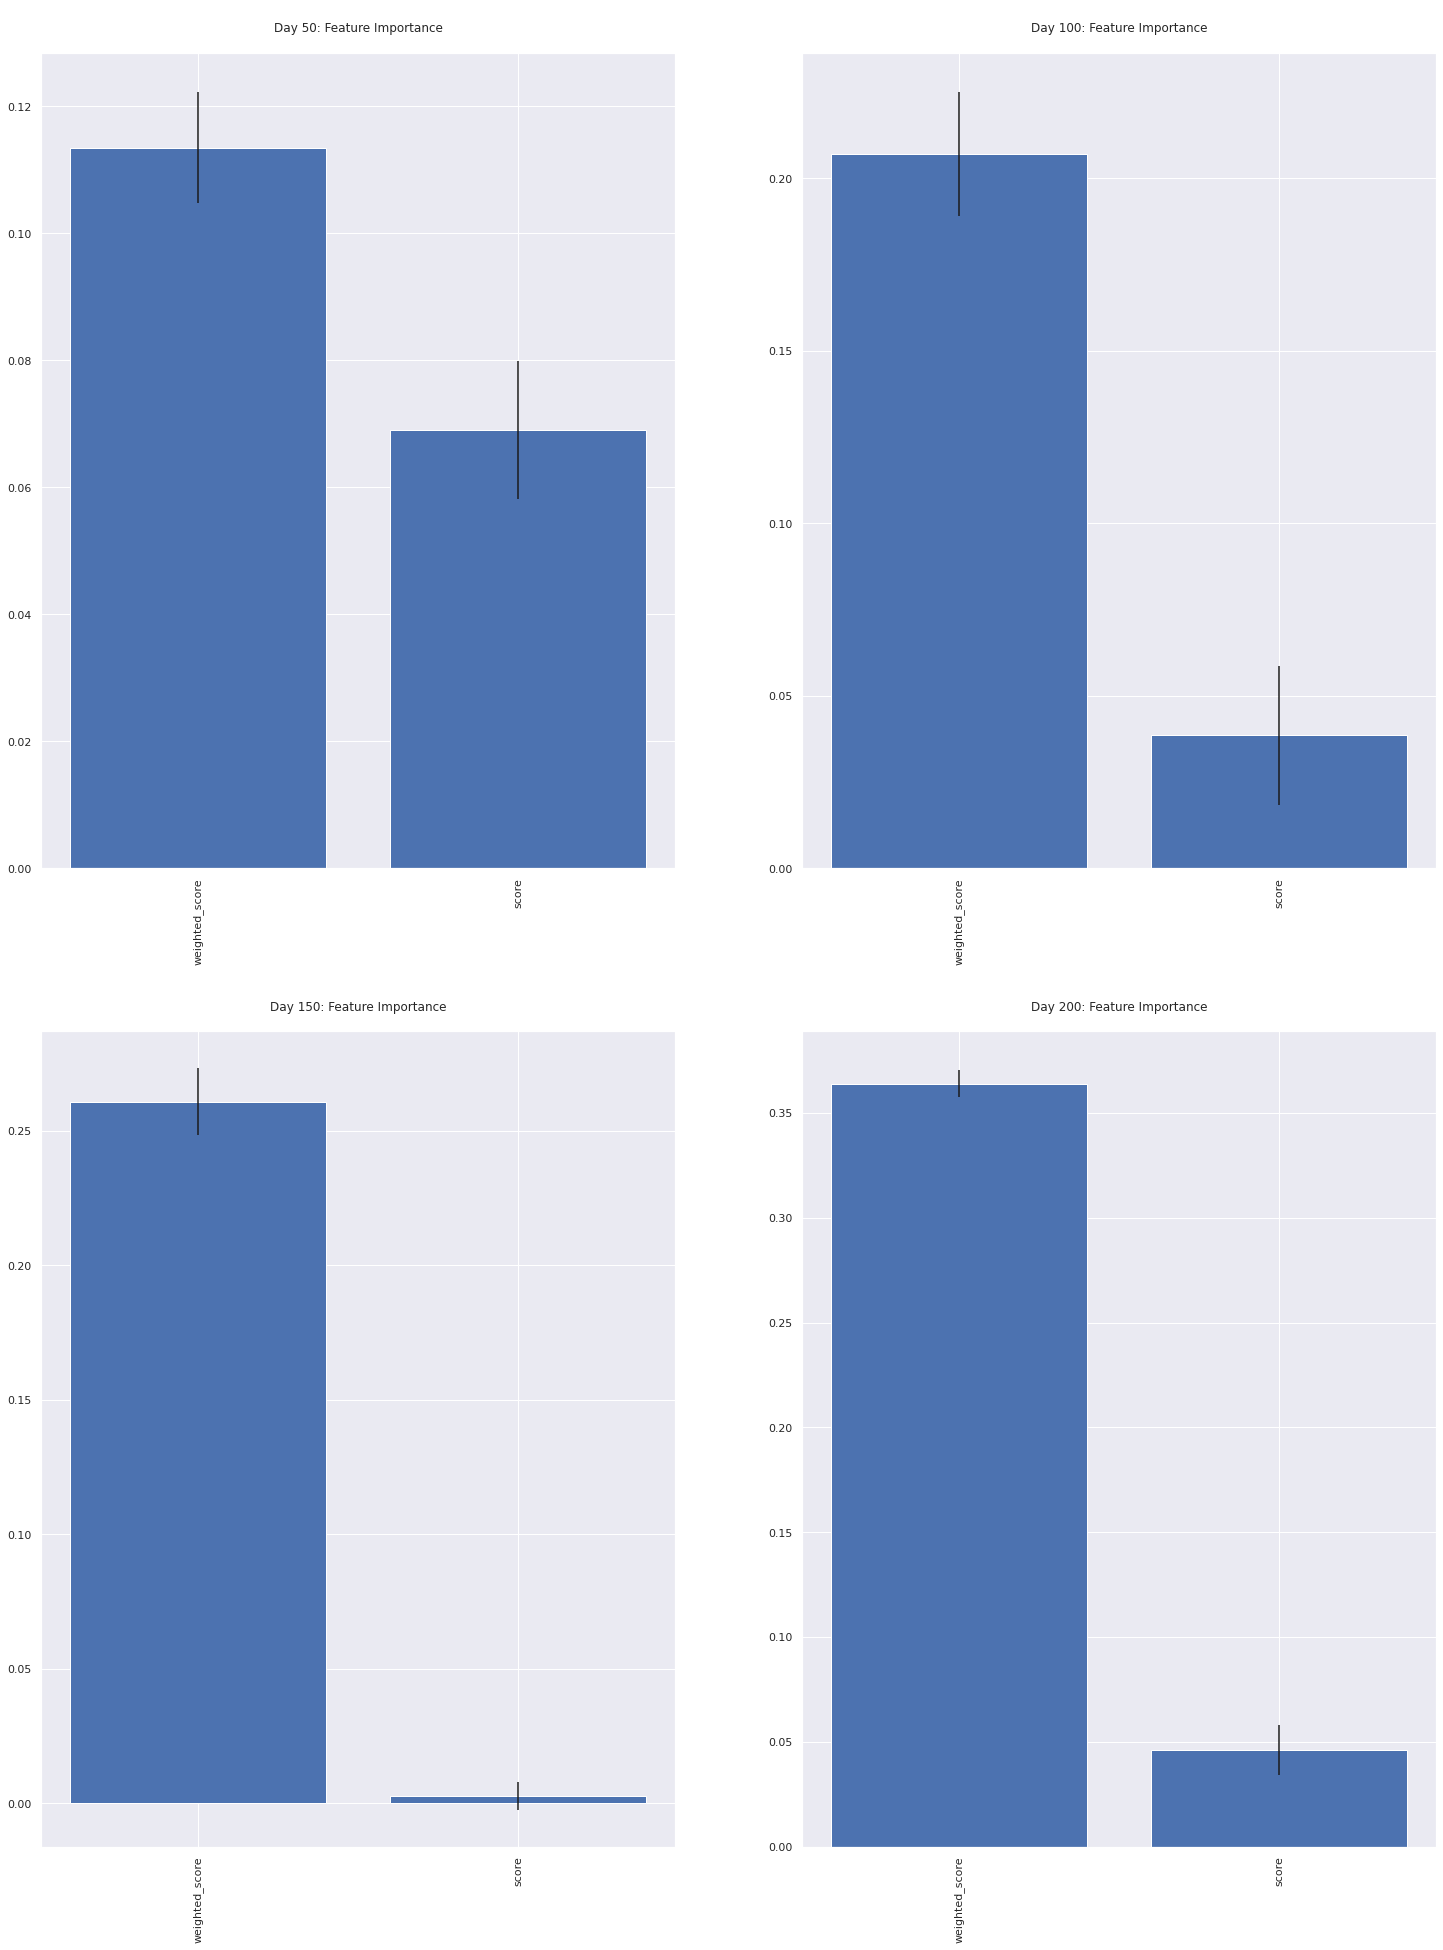

In [ ]:
plot_feature_importance(performance_features_ab)

##### Plot results overview

In [ ]:
performance_classifier_results = [performance_results_du, performance_results_nb, performance_results_lr, performance_results_lrw, performance_results_rf, performance_results_ab]
performance_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

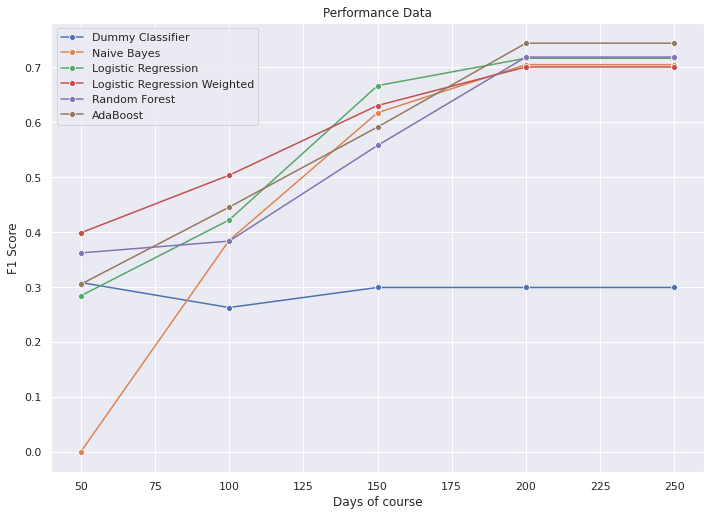

In [ ]:
plot_days_compare(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

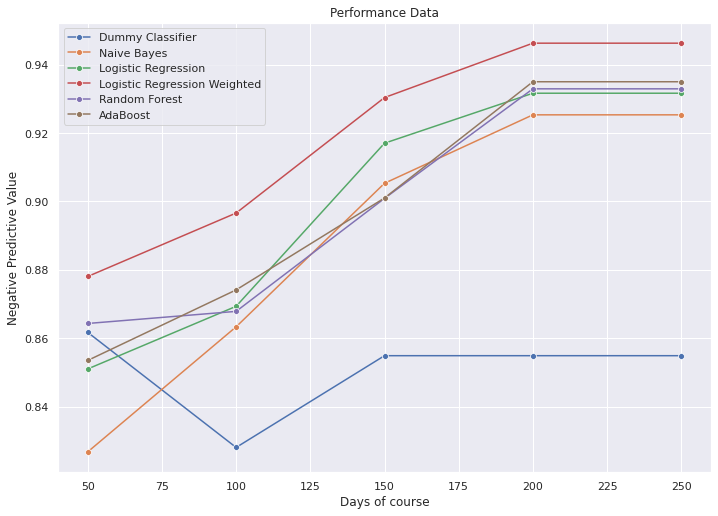

In [ ]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

#### All data (Demographic, Learning Behaviour, Performance)

- Demographic and learning behaviour used throughout classifier
- Performance added from day 100 onwards

##### Prepare data for prediction

In [ ]:
all_df = {}
for i in df.keys():
  all_df[i] = split_dataframe_by_data_type(df[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [ ]:
all_df[50]

code_presentation  id_student gender                region  \
0                2013J       35355      M                 Wales   
1                2013J       42638      M              Scotland   
2                2013J       43564      M              Scotland   
3                2013J       54062      M   East Anglian Region   
4                2013J       63112      M     South East Region   
...                ...         ...    ...                   ...   
1943             2014J     2644404      M              Scotland   
1944             2014J     2654928      M          South Region   
1945             2014J     2663195      M   East Anglian Region   
1946             2014J     2686053      M     South West Region   
1947             2014J     2686712      M  West Midlands Region   

                highest_education imd_band age_band disability  dualpane  \
0              Lower Than A Level    0-10%    35-55          N  2.000000   
1                HE Qualification  90-100%    35-55          N  3.000000   
2                HE Qualification   80-90%    35-55          N  2.666667   
3           A Level or Equivalent   30-40%     0-35          N  2.500000   
4              Lower Than A Level   80-90%    35-55          N  1.333333   
...                           ...      ...      ...        ...       ...   
1943  Post Graduate Qualification   50-60%     0-35          N  0.000000   
1944           Lower Than A Level  90-100%     0-35          N  2.000000   
1945           Lower Than A Level  90-100%     0-35          N  0.000000   
1946        A Level or Equivalent   40-50%    35-55          N  0.000000   
1947        A Level or Equivalent   60-70%    35-55          N  0.000000   

       forumng  ...       quiz  oucollaborate   subpage       url  mean_click  \
0     2.974359  ...  14.142857           0.00  1.250000  1.333333    1.657008   
1     3.043165  ...   8.888889           1.00  2.257143  1.478261    2.027088   
2     4.628571  ...  12.363636           0.00  1.857143  1.266667    1.861836   
3     4.600000  ...  11.222222           0.00  1.400000  1.000000    1.703231   
4     7.264706  ...  12.000000           1.00  1.631579  1.941176    2.174623   
...        ...  ...        ...            ...       ...       ...         ...   
1943  1.000000  ...   9.500000           0.00  1.250000  1.750000    1.219136   
1944  2.541667  ...  10.857143           0.00  2.300000  1.500000    1.566292   
1945  4.200000  ...  10.555556           0.00  1.700000  1.250000    1.516049   
1946  2.000000  ...   7.500000           1.75  1.500000  1.421053    1.249697   
1947  2.654545  ...  17.800000           2.75  1.538462  1.444444    1.979482   

      page  resource  weighted_score  score  final_result  
0      0.0  0.000000          13.846   86.0             0  
1      0.0  1.384615          13.363   83.0             0  
2      0.0  1.687500          15.134   94.0             0  
3      0.0  1.857143          12.558   78.0             0  
4      0.0  2.423077          14.168   88.0             0  
...    ...       ...             ...    ...           ...  
1943   0.0  0.000000          14.007   87.0             0  
1944   0.0  1.111111          14.651   91.0             0  
1945   0.0  1.000000          14.651   91.0             0  
1946   0.0  1.500000          13.846   86.0             0  
1947   1.0  1.250000          16.100  100.0             1  

[1948 rows x 23 columns]

In [ ]:
for i in list(df)[1:1]:
  all_df[i] = all_df[i].drop(columns=["score","weighted_score"])

for i in list(df)[1:]:
  all_df[i] = all_df[i].drop(columns=["score"])

In [ ]:
all_df[50]

code_presentation  id_student gender                region  \
0                2013J       35355      M                 Wales   
1                2013J       42638      M              Scotland   
2                2013J       43564      M              Scotland   
3                2013J       54062      M   East Anglian Region   
4                2013J       63112      M     South East Region   
...                ...         ...    ...                   ...   
1943             2014J     2644404      M              Scotland   
1944             2014J     2654928      M          South Region   
1945             2014J     2663195      M   East Anglian Region   
1946             2014J     2686053      M     South West Region   
1947             2014J     2686712      M  West Midlands Region   

                highest_education imd_band age_band disability  dualpane  \
0              Lower Than A Level    0-10%    35-55          N  2.000000   
1                HE Qualification  90-100%    35-55          N  3.000000   
2                HE Qualification   80-90%    35-55          N  2.666667   
3           A Level or Equivalent   30-40%     0-35          N  2.500000   
4              Lower Than A Level   80-90%    35-55          N  1.333333   
...                           ...      ...      ...        ...       ...   
1943  Post Graduate Qualification   50-60%     0-35          N  0.000000   
1944           Lower Than A Level  90-100%     0-35          N  2.000000   
1945           Lower Than A Level  90-100%     0-35          N  0.000000   
1946        A Level or Equivalent   40-50%    35-55          N  0.000000   
1947        A Level or Equivalent   60-70%    35-55          N  0.000000   

       forumng  ...  homepage       quiz  oucollaborate   subpage       url  \
0     2.974359  ...  2.806452  14.142857           0.00  1.250000  1.333333   
1     3.043165  ...  7.840909   8.888889           1.00  2.257143  1.478261   
2     4.628571  ...  3.742857  12.363636           0.00  1.857143  1.266667   
3     4.600000  ...  3.533333  11.222222           0.00  1.400000  1.000000   
4     7.264706  ...  6.323529  12.000000           1.00  1.631579  1.941176   
...        ...  ...       ...        ...            ...       ...       ...   
1943  1.000000  ...  2.555556   9.500000           0.00  1.250000  1.750000   
1944  2.541667  ...  3.966667  10.857143           0.00  2.300000  1.500000   
1945  4.200000  ...  3.333333  10.555556           0.00  1.700000  1.250000   
1946  2.000000  ...  3.255319   7.500000           1.75  1.500000  1.421053   
1947  2.654545  ...  3.404762  17.800000           2.75  1.538462  1.444444   

      mean_click  page  resource  weighted_score  final_result  
0       1.657008   0.0  0.000000          13.846             0  
1       2.027088   0.0  1.384615          13.363             0  
2       1.861836   0.0  1.687500          15.134             0  
3       1.703231   0.0  1.857143          12.558             0  
4       2.174623   0.0  2.423077          14.168             0  
...          ...   ...       ...             ...           ...  
1943    1.219136   0.0  0.000000          14.007             0  
1944    1.566292   0.0  1.111111          14.651             0  
1945    1.516049   0.0  1.000000          14.651             0  
1946    1.249697   0.0  1.500000          13.846             0  
1947    1.979482   1.0  1.250000          16.100             1  

[1948 rows x 22 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(all_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['dualpane', 'forumng', 'oucontent', 'homepage', 'quiz', 'oucollaborate',
       'subpage', 'url', 'mean_click', 'resource'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['dualpane', 'forumng', 'oucontent', 'homepage', 'quiz', 'oucollaborate',
       'subpage', 'url', 'mean_click', 'resource', 'weighted_score'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['dualpane', 'forumng', 'oucontent', 'homepage', 'quiz', 'oucollaborate',
       'subpage', 'url', 'mean_click', 'resource', 'weighted_score'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['dualpane', 'forumng', 'ouwiki'

In [ ]:
X_train[50]

gender_F  gender_M  region_East Anglian Region  \
0         0.0       1.0                         0.0   
1         0.0       1.0                         0.0   
2         0.0       1.0                         0.0   
3         0.0       1.0                         1.0   
4         0.0       1.0                         0.0   
..        ...       ...                         ...   
702       0.0       1.0                         0.0   
703       0.0       1.0                         1.0   
704       0.0       1.0                         0.0   
705       0.0       1.0                         0.0   
706       0.0       1.0                         0.0   

     region_East Midlands Region  region_Ireland  region_London Region  \
0                            0.0             0.0                   0.0   
1                            0.0             0.0                   0.0   
2                            0.0             0.0                   0.0   
3                            0.0             0.0                   0.0   
4                            0.0             0.0                   0.0   
..                           ...             ...                   ...   
702                          0.0             0.0                   0.0   
703                          0.0             0.0                   0.0   
704                          1.0             0.0                   0.0   
705                          0.0             0.0                   0.0   
706                          0.0             0.0                   0.0   

     region_North Region  region_North Western Region  region_Scotland  \
0                    0.0                          0.0              0.0   
1                    0.0                          0.0              1.0   
2                    0.0                          0.0              1.0   
3                    0.0                          0.0              0.0   
4                    0.0                          0.0              0.0   
..                   ...                          ...              ...   
702                  0.0                          0.0              0.0   
703                  0.0                          0.0              0.0   
704                  0.0                          0.0              0.0   
705                  0.0                          0.0              0.0   
706                  0.0                          0.0              0.0   

     region_South East Region  ...   forumng  oucontent  homepage      quiz  \
0                         0.0  ...  0.289085   0.458547  0.122279  0.358047   
1                         0.0  ...  0.295772   0.654706  0.517798  0.225035   
2                         0.0  ...  0.449861   0.456897  0.195845  0.313003   
3                         0.0  ...  0.447084   0.391850  0.179384  0.284107   
4                         1.0  ...  0.706073   0.450501  0.398589  0.303797   
..                        ...  ...       ...        ...       ...       ...   
702                       0.0  ...  0.161987   0.378788  0.160591  0.362869   
703                       0.0  ...  0.362501   0.419470  0.478780  0.276793   
704                       0.0  ...  0.387956   0.687387  0.623143  0.337025   
705                       0.0  ...  0.222154   0.568966  0.389711  0.037975   
706                       0.0  ...  0.709143   0.332646  0.317056  0.265823   

     oucollaborate   subpage       url  mean_click  resource  weighted_score  
0         0.000000  0.086207  0.290598    0.429913  0.000000        0.810811  
1         0.076923  0.155665  0.322185    0.532832  0.197802        0.770270  
2         0.000000  0.128079  0.276068    0.486876  0.241071        0.918919  
3         0.000000  0.096552  0.217949    0.442768  0.265306        0.702703  
4         0.076923  0.112523  0.423077    0.573862  0.346154        0.837838  
..             ...       ...       ...         ...       ...             ...  
702       0.000000  0.097701  0.217949    0.449667  0.285714    

###### Undersampling

In [ ]:
Y_train[50].value_counts()

0    567
1    140
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = TomekLinks() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 495, 1: 117})
Resample dataset shape Counter({0: 444, 1: 117})
Sampling for day 50
Original dataset shape: Counter({0: 567, 1: 140})
Resample dataset shape Counter({0: 510, 1: 140})
Sampling for day 100
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 517, 1: 141})
Sampling for day 150
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 522, 1: 141})
Sampling for day 200
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 523, 1: 141})
Sampling for day 250
Original dataset shape: Counter({0: 568, 1: 141})
Resample dataset shape Counter({0: 522, 1: 141})


###### Reduce dimensions

In [ ]:
for i in df.keys():
  pca = PCA(n_components='mle')

  X_train[i] = pca.fit_transform(X_train[i], Y_train[i])                             
  
  X_test[i] = pca.transform(X_test[i])

In [ ]:
X_train[250].shape

(709, 41)

###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0         1         2         3         4         5         6   \
0    0.139524  0.019334 -0.168487 -0.118631 -0.099637 -0.207585 -0.013173   
1    0.998186  0.295799  0.105144  0.498308  0.336418 -0.423189 -0.032011   
2    1.050865  0.229709  0.125724  0.228011 -0.343750  0.348474  0.146528   
3    0.103429 -0.197559 -0.232742  0.235043  0.131570  0.880150 -0.315645   
4    0.244394 -0.035724  0.240645  0.361038 -0.400537  0.283285  0.136872   
..        ...       ...       ...       ...       ...       ...       ...   
704 -0.925080  0.121154 -0.601446 -0.378887  0.117065  0.424126  0.179186   
705 -0.830204 -0.139865  0.228202  0.998839  0.368917  0.014006 -0.515110   
706  1.127921 -0.068960 -0.165035 -0.149485  0.078253 -0.396075 -0.272833   
707  0.094986  0.127065 -0.106069  0.121931 -0.371065 -0.011621  0.242745   
708 -0.881546  0.152482 -0.118981  0.174841 -0.347643 -0.017262  0.273422   

           7         8         9         10        11        12        13  \
0   -0.075988  0.215210 -0.302415 -0.158913  0.275749  0.047203  0.307423   
1   -0.089519 -0.012059 -0.060689 -0.004839 -0.051988  0.088042  0.042871   
2    0.141218  0.165352  0.120576 -0.034386  0.062439  0.014483  0.011749   
3   -0.182604 -0.206748  0.053388  0.130100 -0.305294 -0.367412  0.078589   
4    0.209187  0.330765  0.245060  0.010515 -0.020037  0.420117  0.017998   
..        ...       ...       ...       ...       ...       ...       ...   
704 -0.208142 -0.143477 -0.390519 -0.102028  0.234340  0.046421  0.432043   
705 -0.370268 -0.022335  0.029731 -0.074410 -0.142118 -0.023620  0.019808   
706  0.404432 -0.505856  0.544772 -0.456904  0.410561 -0.208864 -0.136257   
707  0.168170 -0.071214 -0.038355  0.120112  0.101208  0.106086  0.625362   
708  0.200553 -0.106671  0.011278  0.181341  0.095211  0.311905 -0.223828   

           14        15        16        17        18        19  
0    0.941981 -0.279093  0.158993  0.015453 -0.130964 -0.110308  
1    0.014955  0.095962 -0.062977 -0.050297  0.244042 -0.072808  
2    0.019991 -0.093504  0.053054 -0.050531 -0.029780 -0.018490  
3    0.145599 -0.024972  0.039986  0.147787 -0.046022  0.233366  
4   -0.446000  0.130763 -0.154298  0.321301 -0.154569 -0.012180  
..        ...       ...       ...       ...       ...       ...  
704 -0.245593 -0.050301 -0.079826 -0.034206 -0.007534  0.077723  
705  0.078762  0.282943 -0.282285  0.076409  0.206467 -0.071660  
706 -0.113256  0.332716 -0.366465  0.121210  0.077937 -0.285338  
707 -0.091975 -0.115820  0.040666  0.018983 -0.121534 -0.132755  
708  0.797211  0.056542 -0.199009 -0.010887  0.141454  0.262446  

[709 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

all_results_du = []
all_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_du.append([acc, f1, prec, recall, conf])
  all_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.431
Best parameters set:
Accuracy: 0.475177304964539, F1 Score: 0.24489795918367346, Precision: 0.16260162601626016, Recall: 0.49586776859504134


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.432
Best parameters set:
Accuracy: 0.5197452229299363, F1 Score: 0.30825688073394497, Precision: 0.20537897310513448, Recall: 0.6176470588235294


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.448
Best parameters set:
Accuracy: 0.4879594423320659, F1 Score: 0.26277372262773724, Precision: 0.17518248175182483, Recall: 0.5255474452554745


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.44

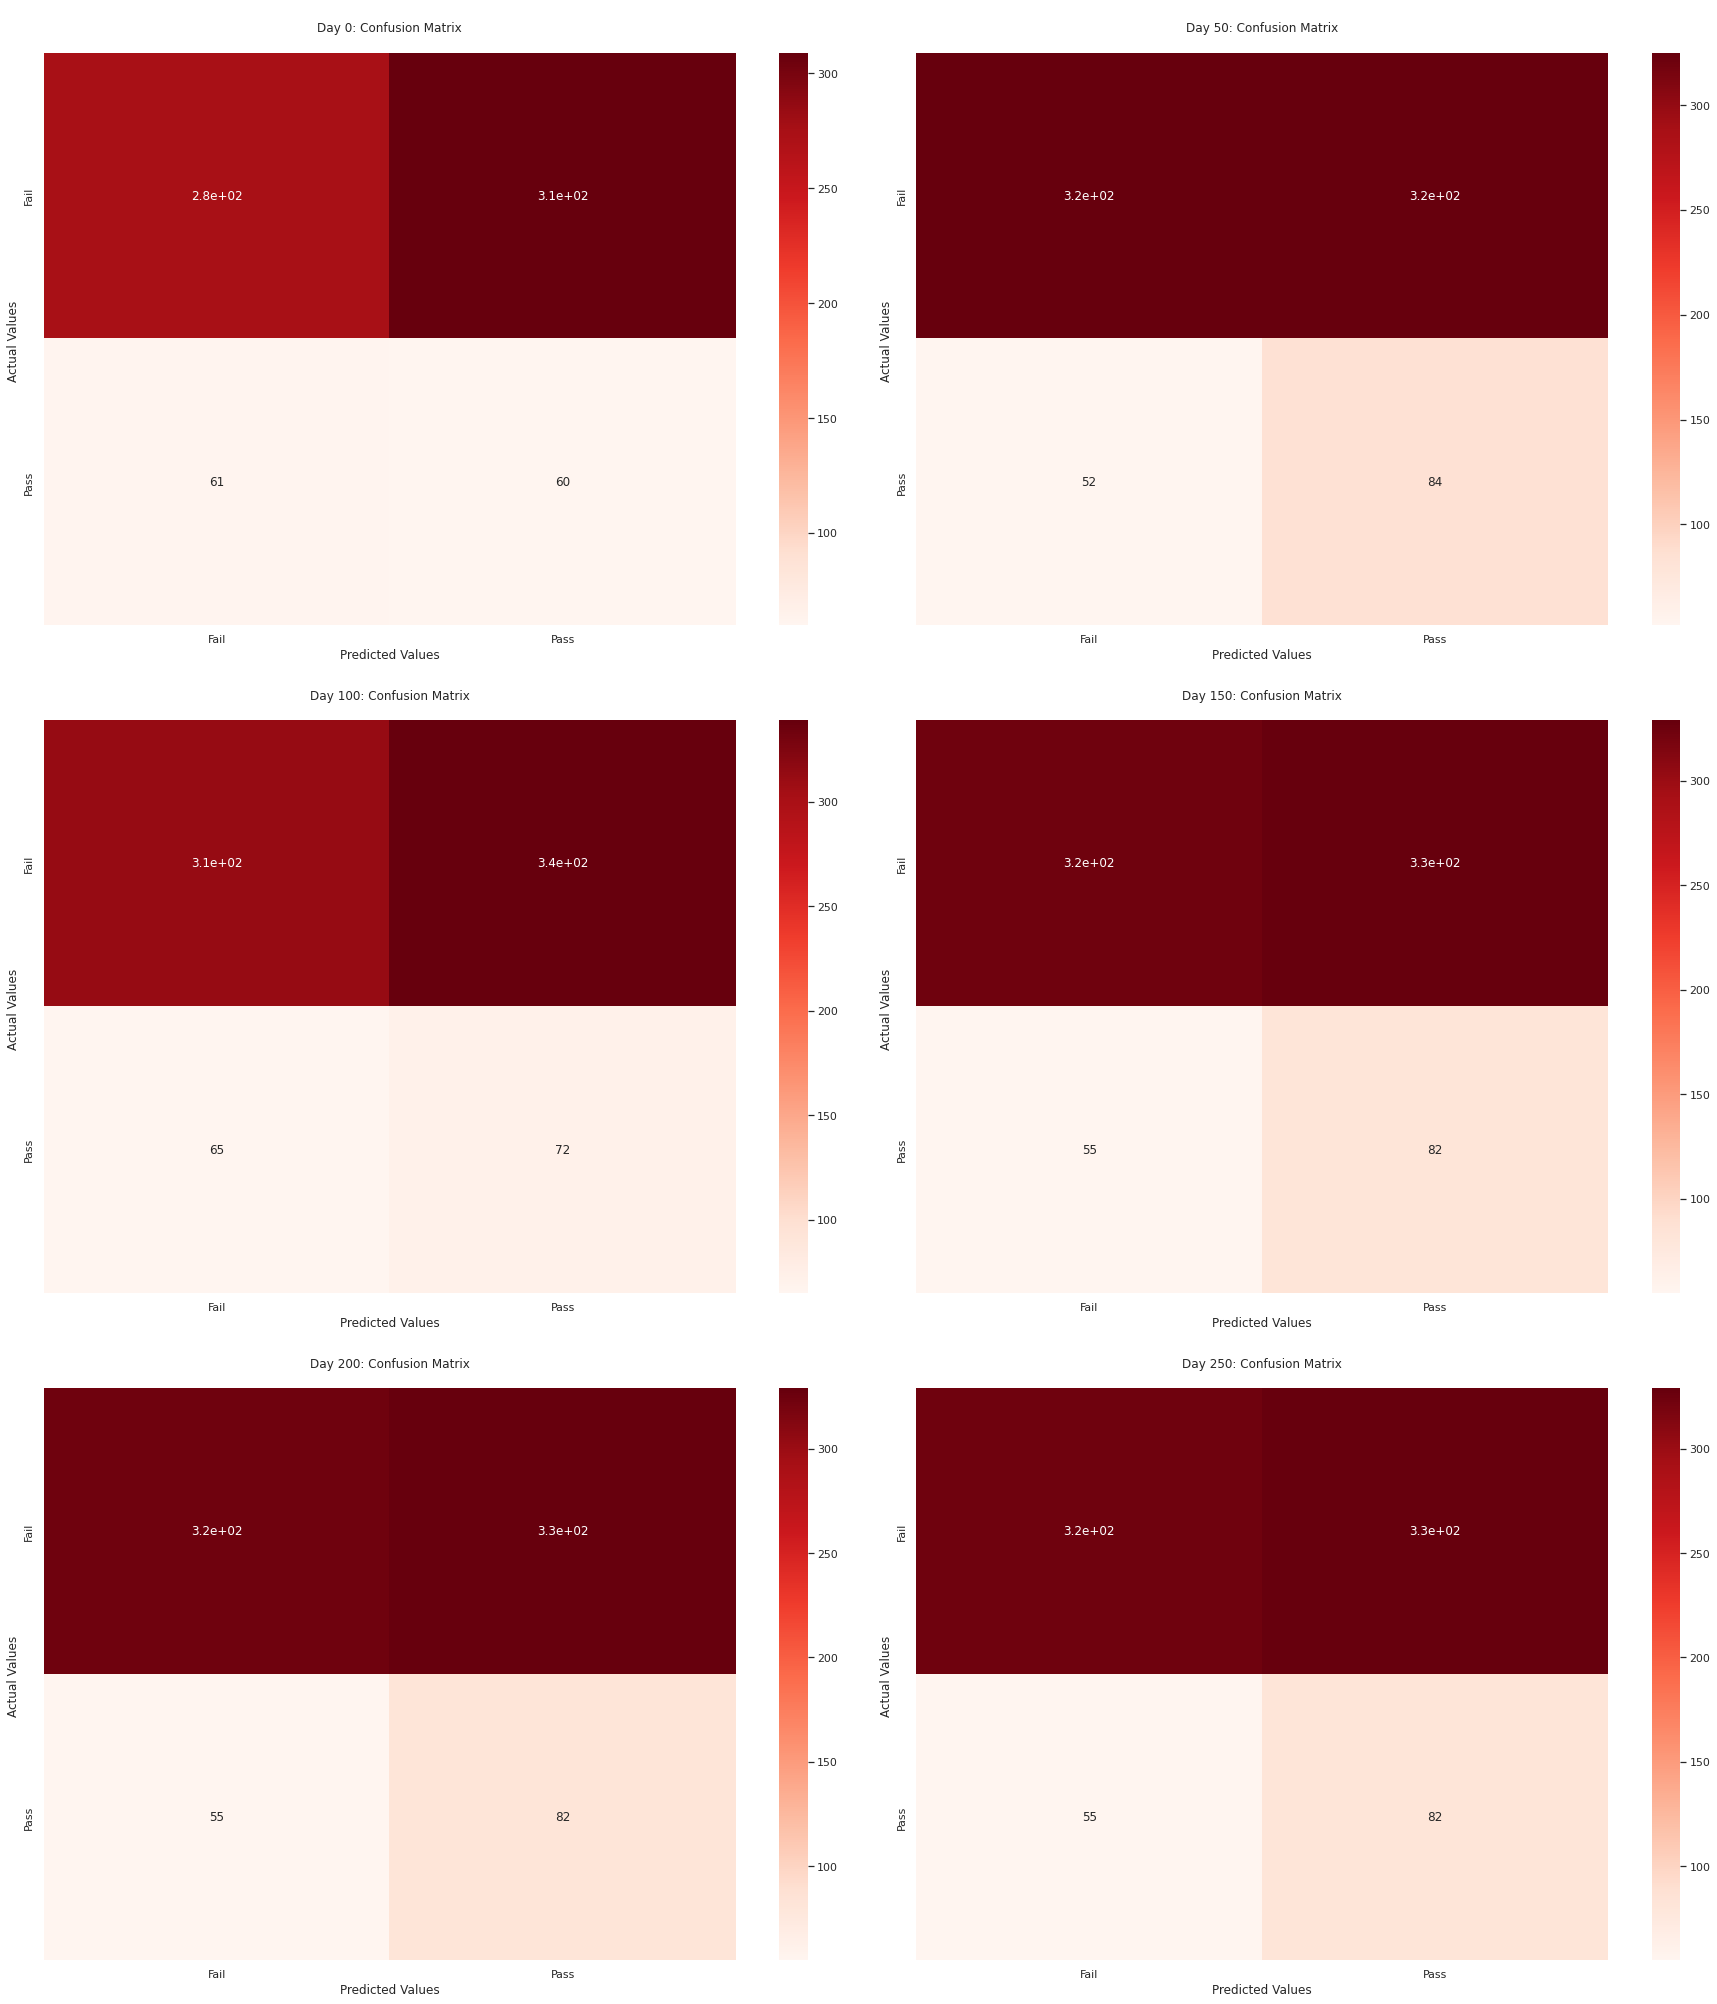

In [ ]:
plot_confusion_matrix(all_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

all_results_nb = []

pipeline = Pipeline([
    ('clf', GaussianNB()),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_nb.append([acc, f1, prec, recall, conf])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.515
Best parameters set:
Accuracy: 0.6212765957446809, F1 Score: 0.2992125984251968, Precision: 0.21923076923076923, Recall: 0.47107438016528924


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.639
Best parameters set:
Accuracy: 0.8050955414012739, F1 Score: 0.331877729257642, Precision: 0.40860215053763443, Recall: 0.27941176470588236


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.694
Best parameters set:
Accuracy: 0.7731305449936628, F1 Score: 0.35842293906810035, Precision: 0.352112676056338, Recall: 0.36496350364963503


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.790


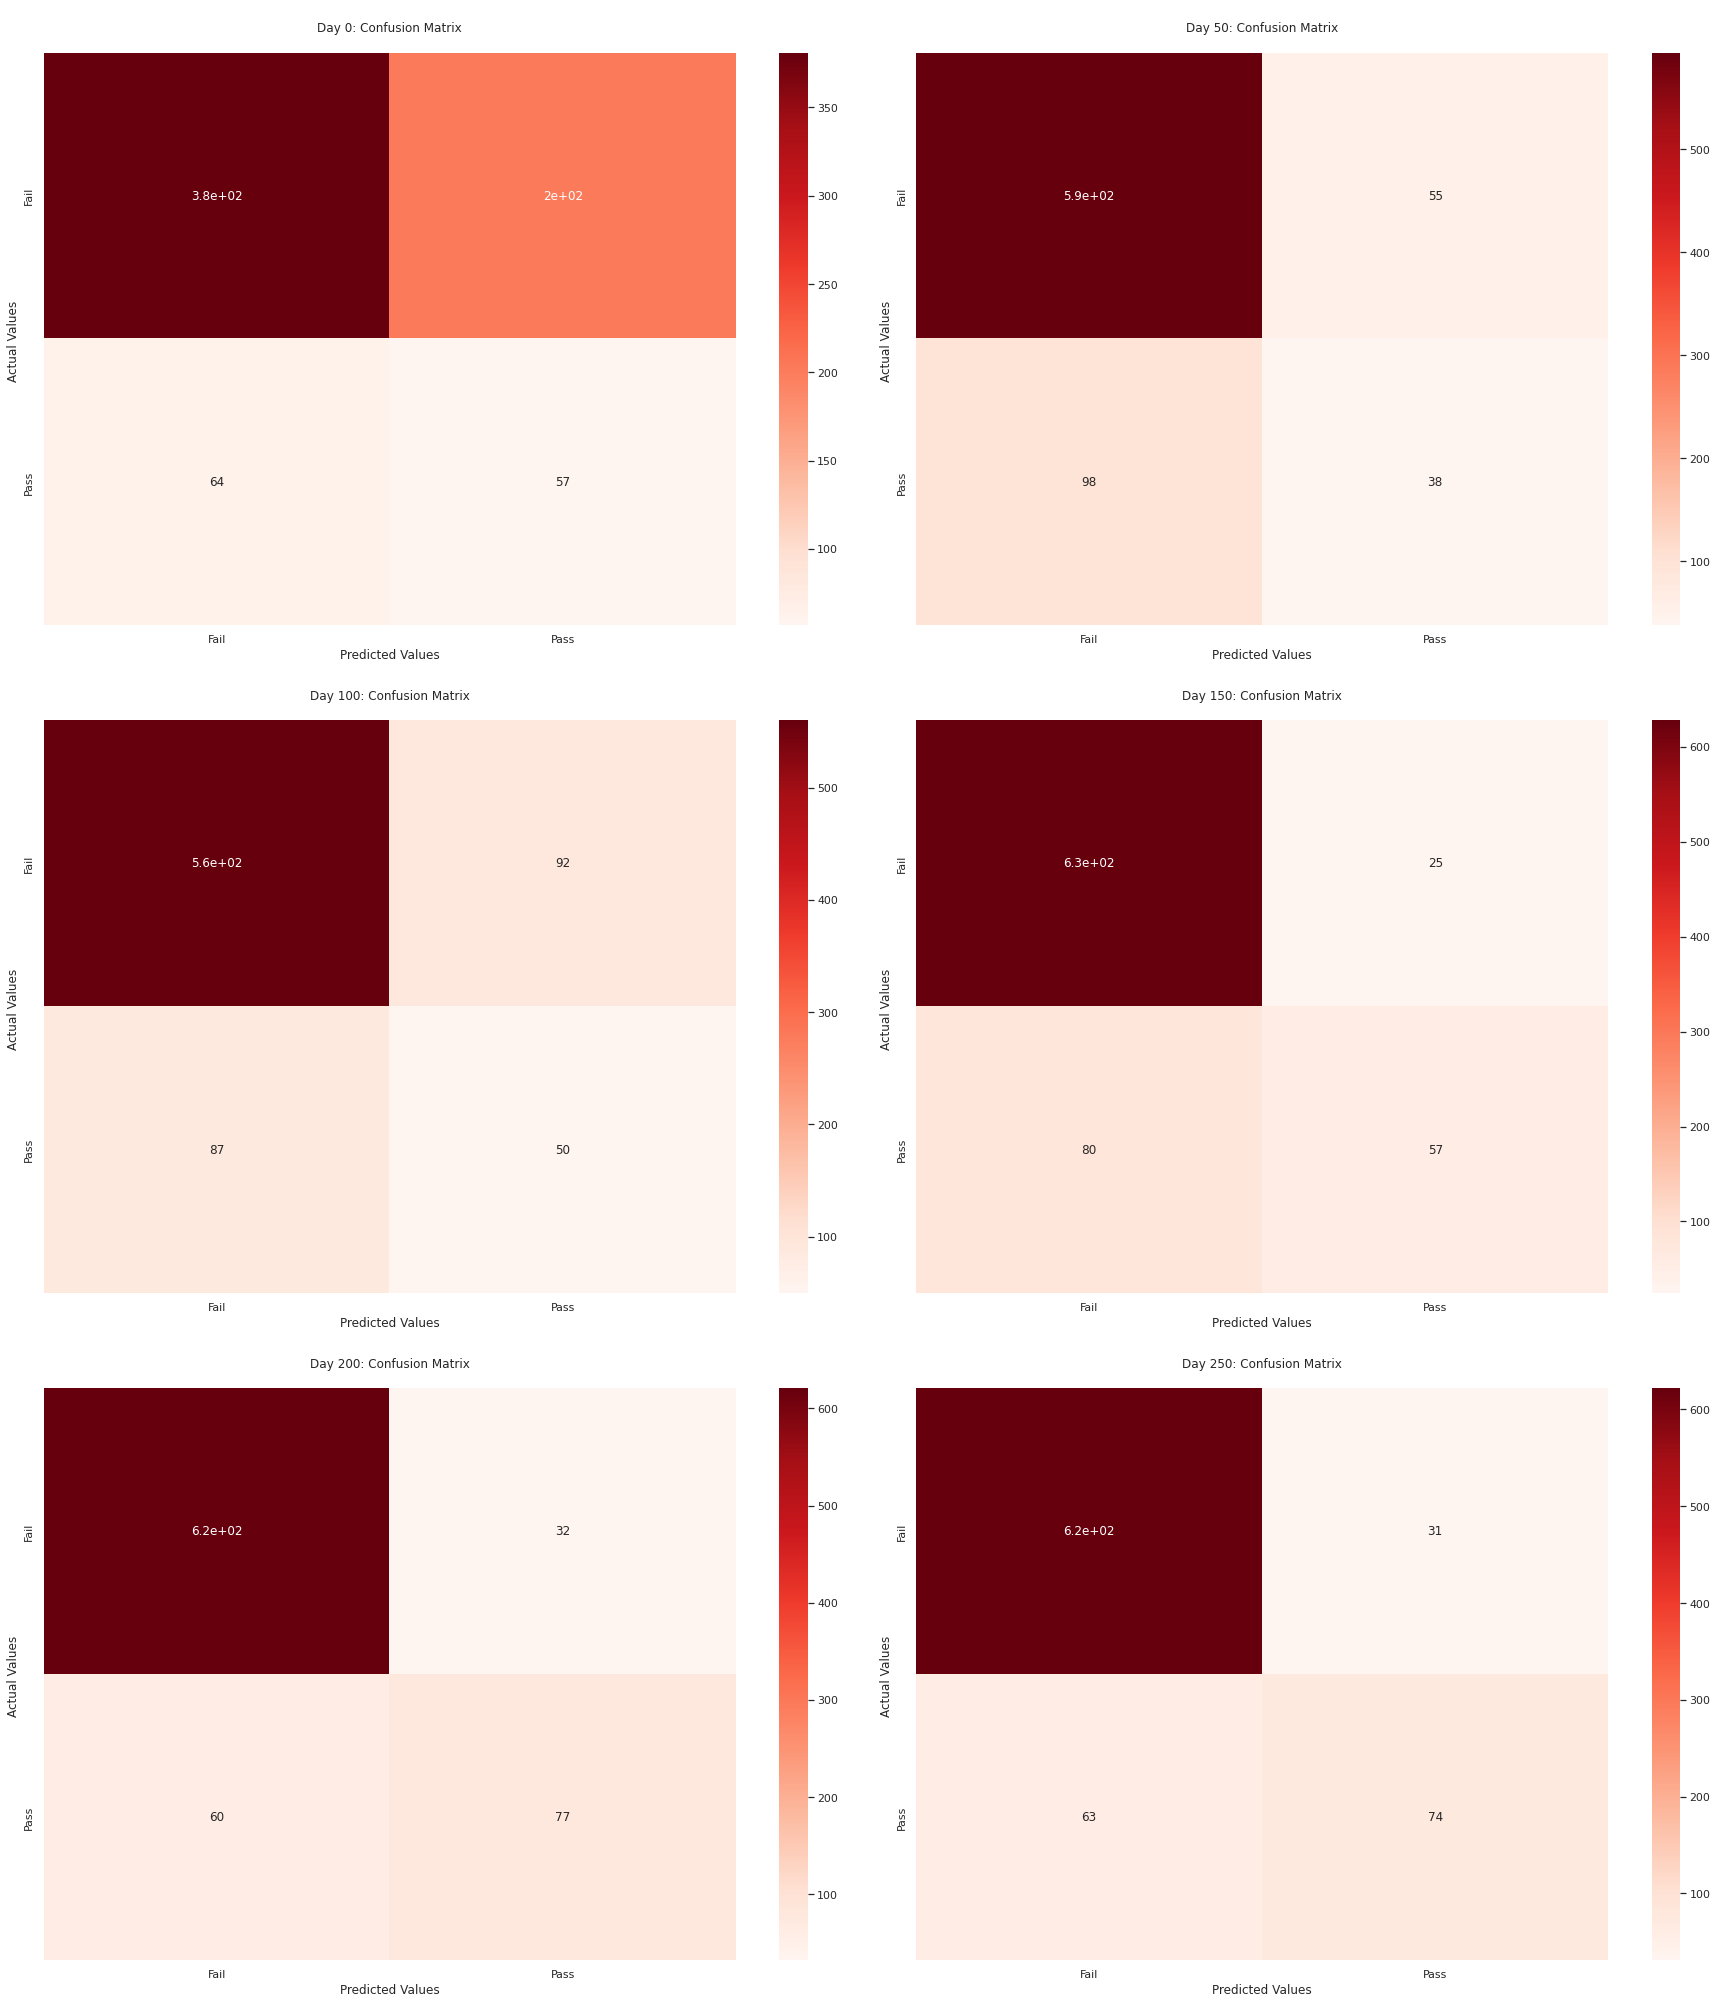

In [ ]:
plot_confusion_matrix(all_results_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

all_results_predict_proba_lr = []
all_results_predict_lr = []

all_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lr.append([acc, f1, prec, recall, conf])
  all_results_predict_proba_lr.append(predictions_proba)
  all_results_predict_lr.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.524
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8184397163120567, F1 Score: 0.07246376811594203, Precision: 0.29411764705882354, Recall: 0.04132231404958678


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.679
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8229299363057325, F1 Score: 0.23204419889502764, Precision: 0.4666666666666667, Recall: 0.15441176470588236


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.762
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8580481622306717, F1 Score: 0.43434343434343436, Precision: 0.7049180327868853, Recall: 0.31386

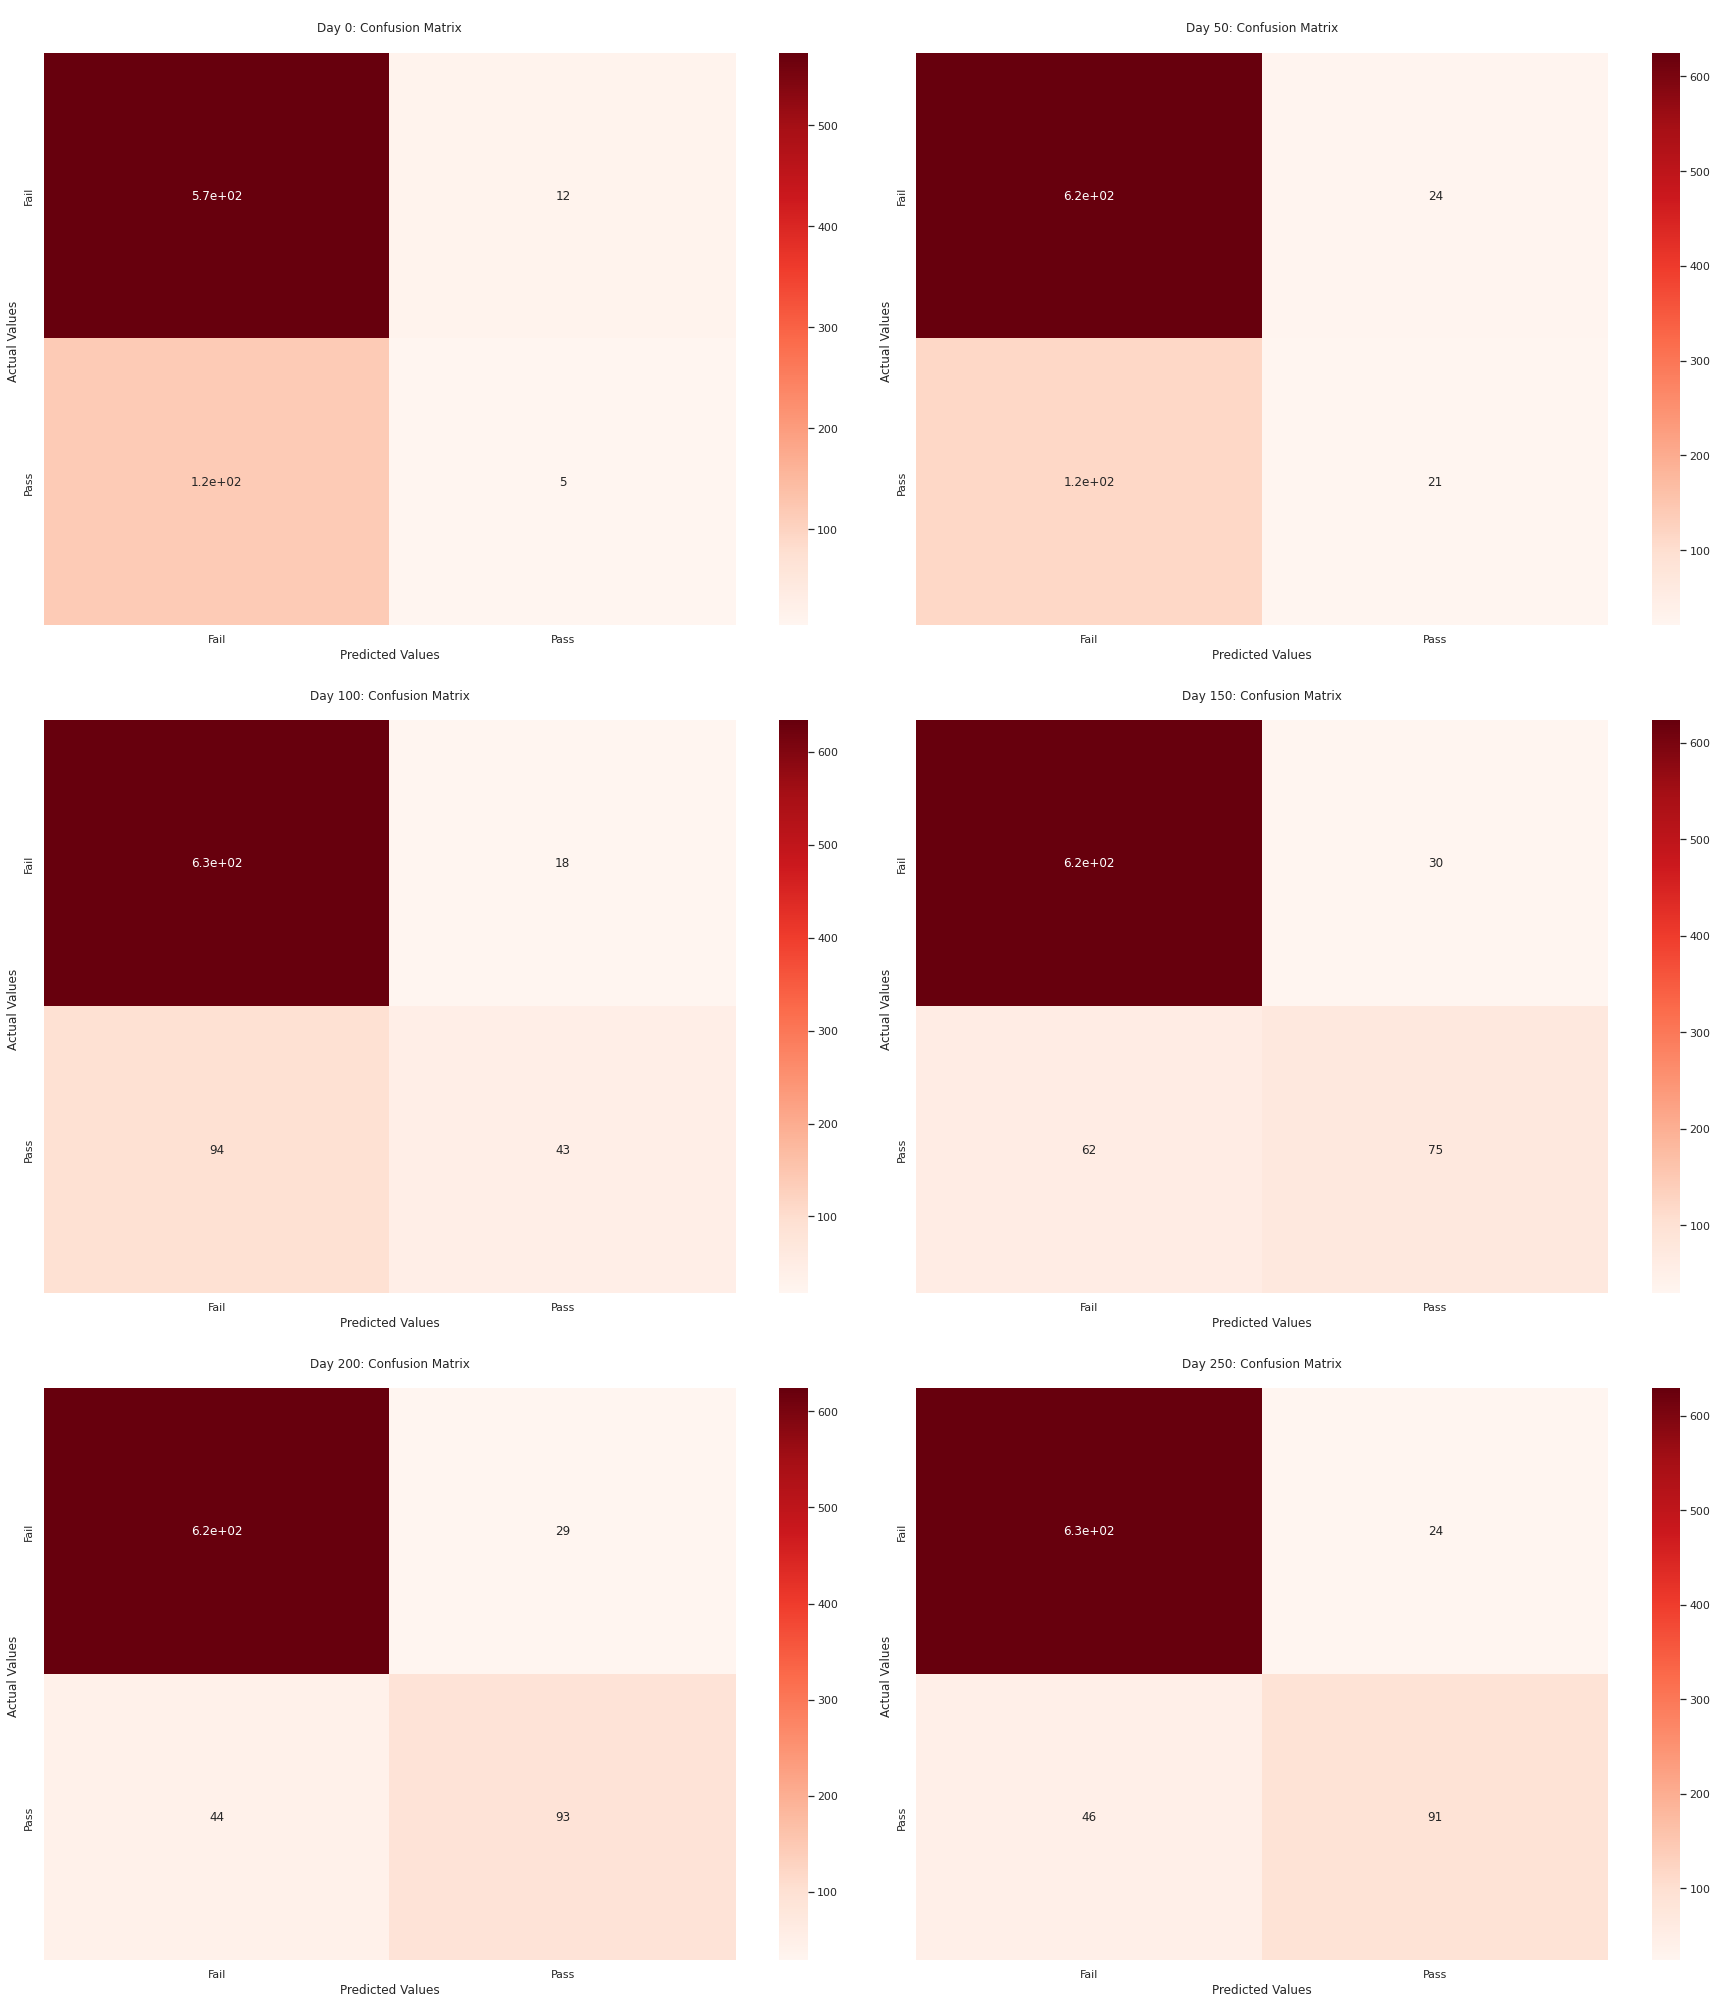

In [ ]:
plot_confusion_matrix(all_results_lr)

##### WeightedLogisticRegression

In [ ]:
all_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.552
Best parameters set:
Accuracy: 0.5787234042553191, F1 Score: 0.3295711060948081, Precision: 0.2267080745341615, Recall: 0.6033057851239669


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.653
Best parameters set:
Accuracy: 0.756687898089172, F1 Score: 0.3696369636963696, Precision: 0.33532934131736525, Recall: 0.4117647058823529


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.746
Best parameters set:
Accuracy: 0.8098859315589354, F1 Score: 0.4485294117647059, Precision: 0.45185185185185184, Recall: 0.44525547445255476


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.789
Be

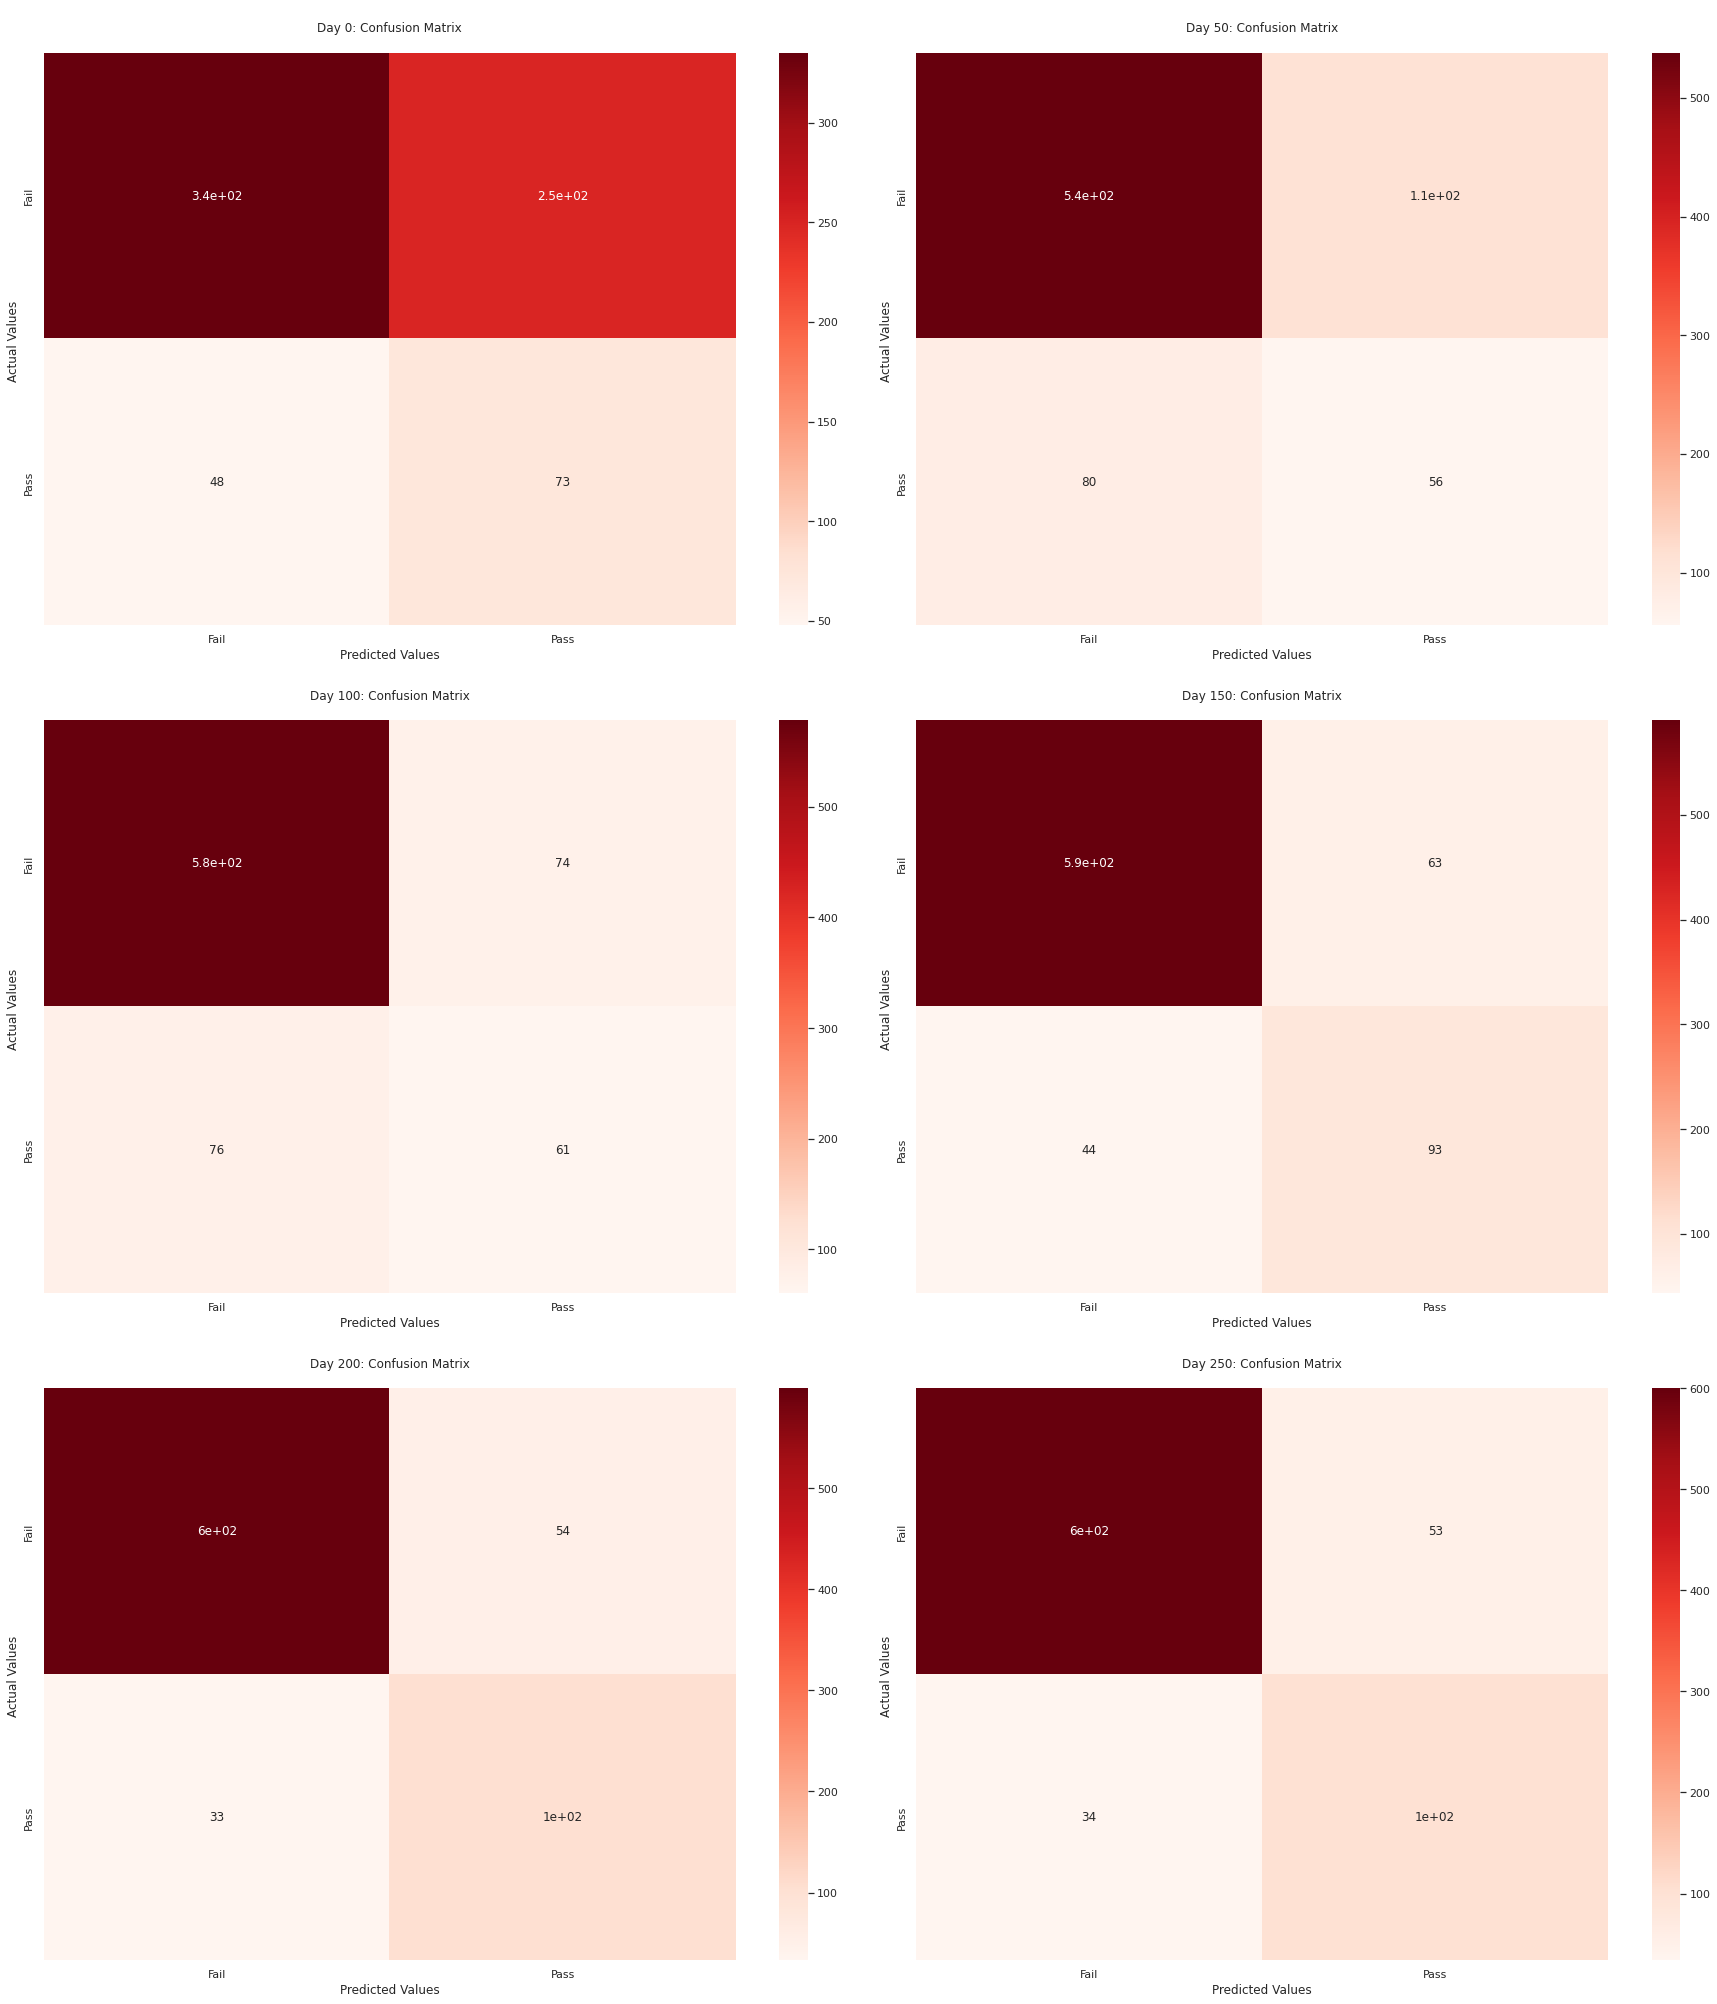

In [ ]:
plot_confusion_matrix(all_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

all_results_rf = []
all_results_predict_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_rf.append([acc, f1, prec, recall, conf])
  all_results_predict_rf.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.522
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.8184397163120567, F1 Score: 0.07246376811594203, Precision: 0.29411764705882354, Recall: 0.04132231404958678


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.597
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.8178343949044586, F1 Score: 0.07741935483870968, Precision: 0.3157894736842105, Recall: 0.04411764705882353


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.719
Best parameters set:
	clf__n_esti

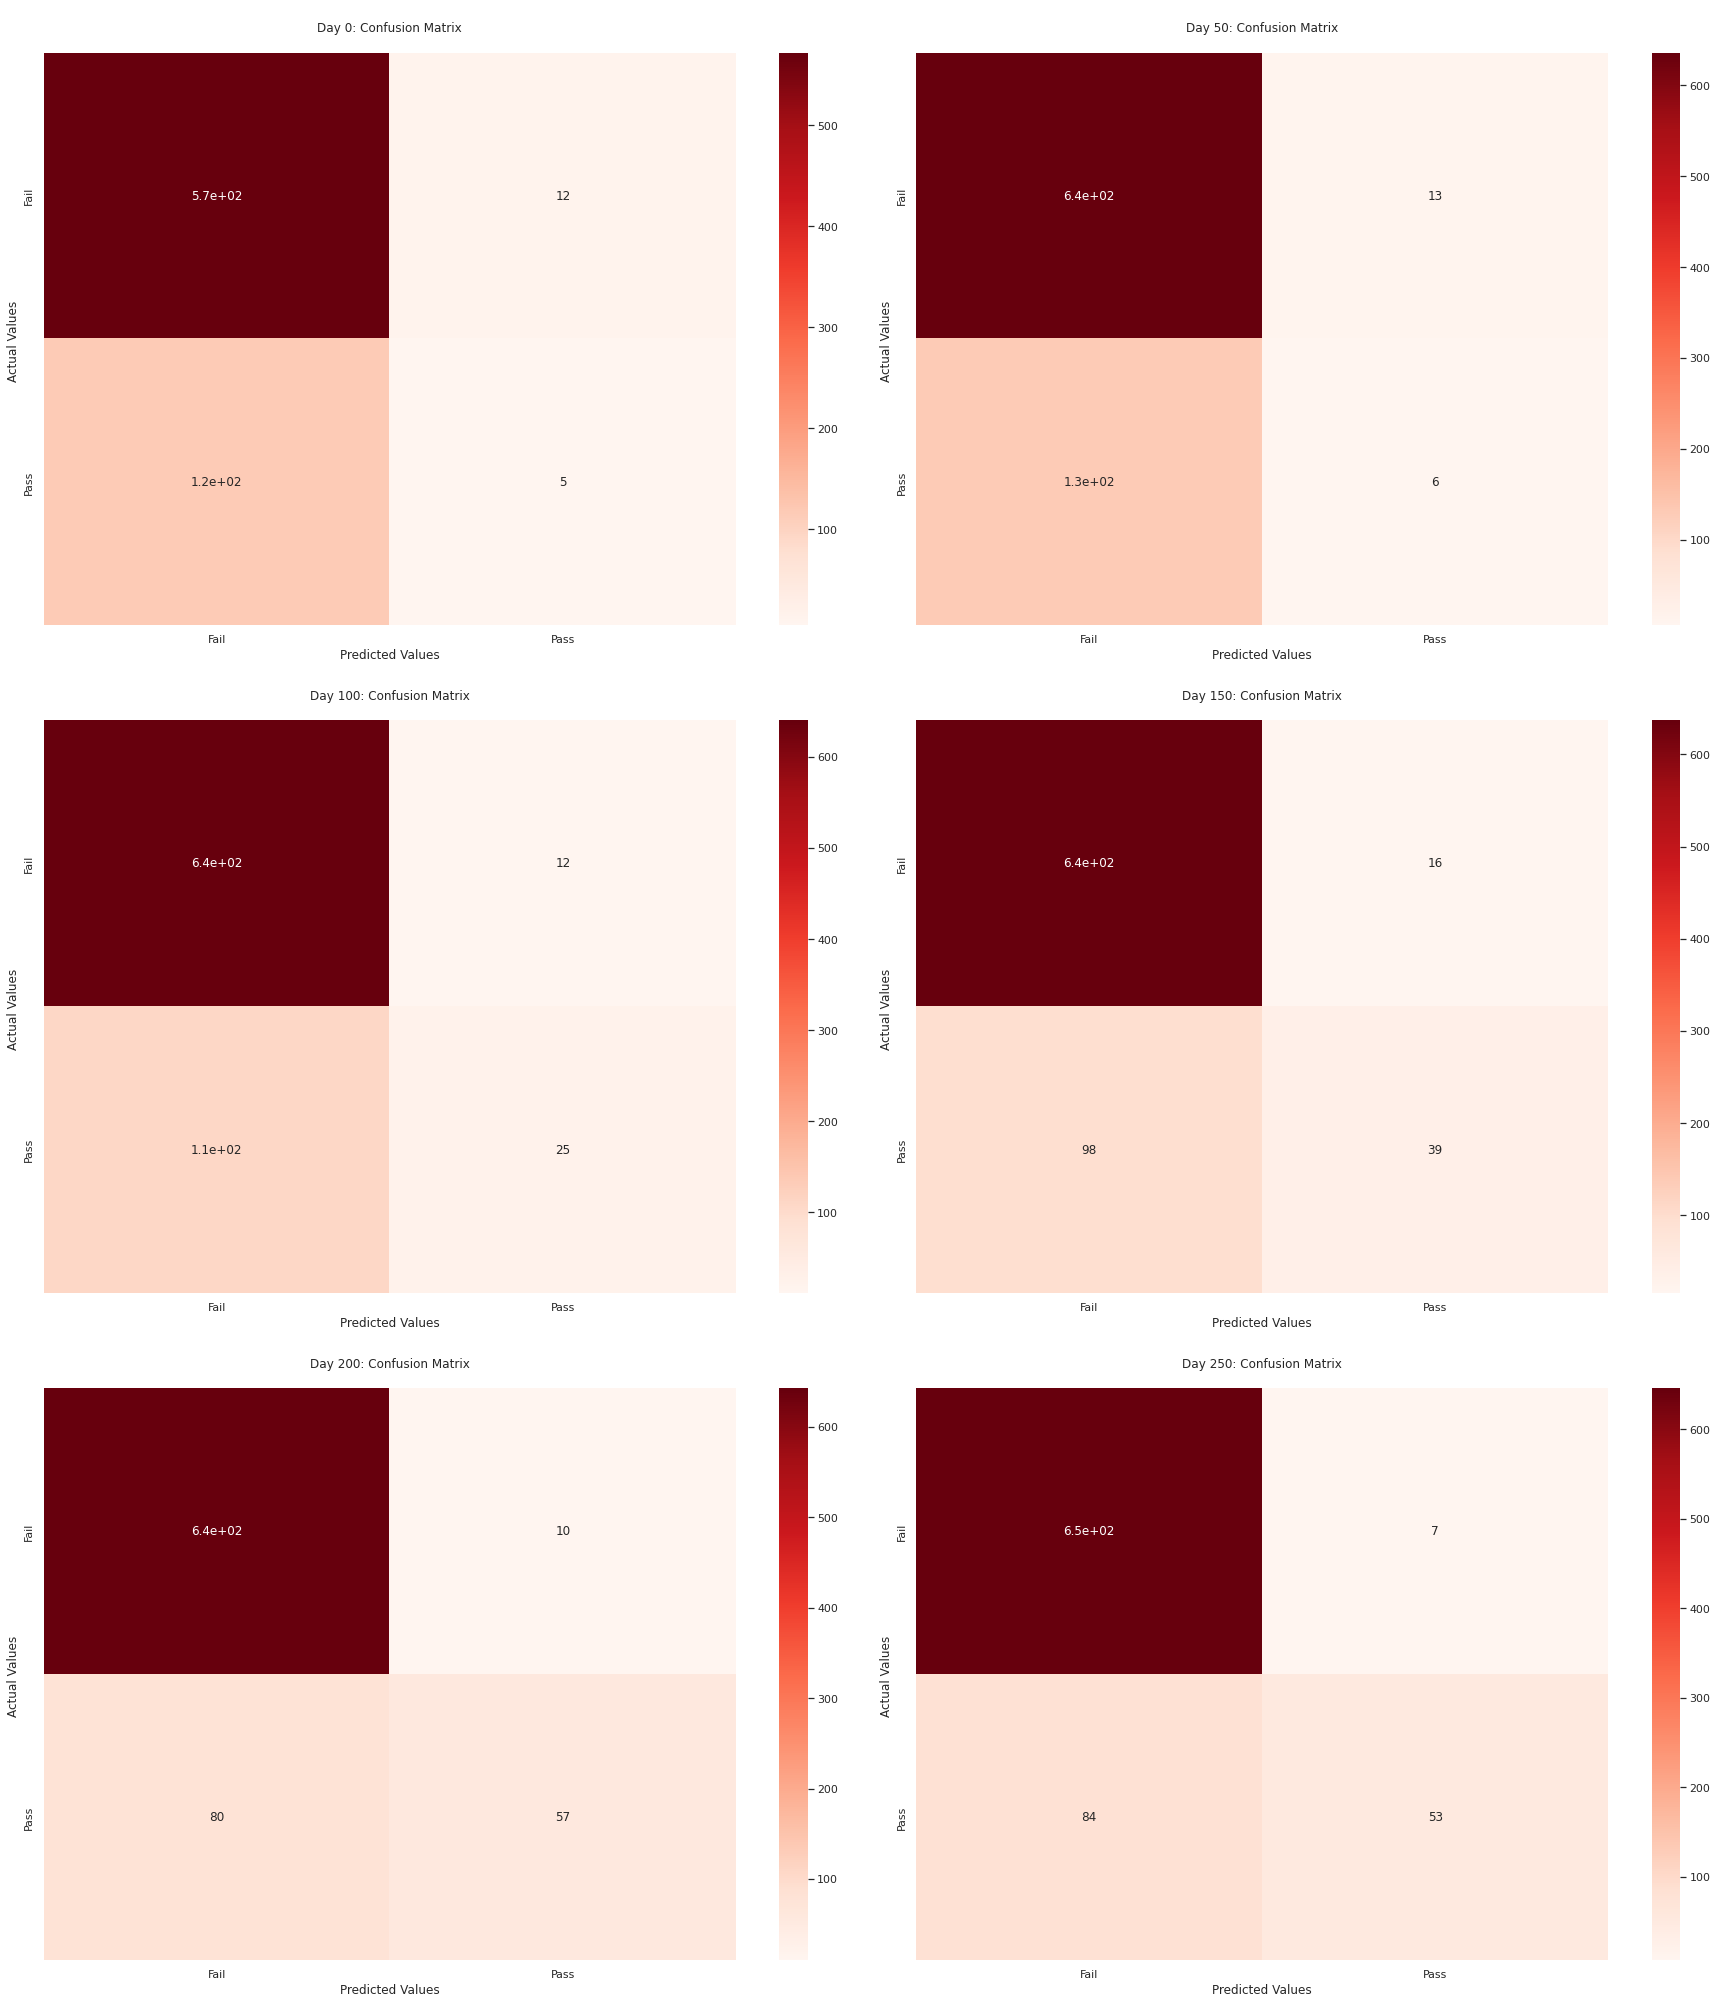

In [ ]:
plot_confusion_matrix(all_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

all_results_ab = []
all_results_predict_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_ab.append([acc, f1, prec, recall, conf])
  all_results_predict_ab.append(predictions)
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.533
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.8070921985815603, F1 Score: 0.10526315789473684, Precision: 0.25806451612903225, Recall: 0.06611570247933884


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.669
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.8140127388535032, F1 Score: 0.1411764705882353, Precision: 0.35294117647058826, Recall: 0.08823529411764706


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.744
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8415716096324461

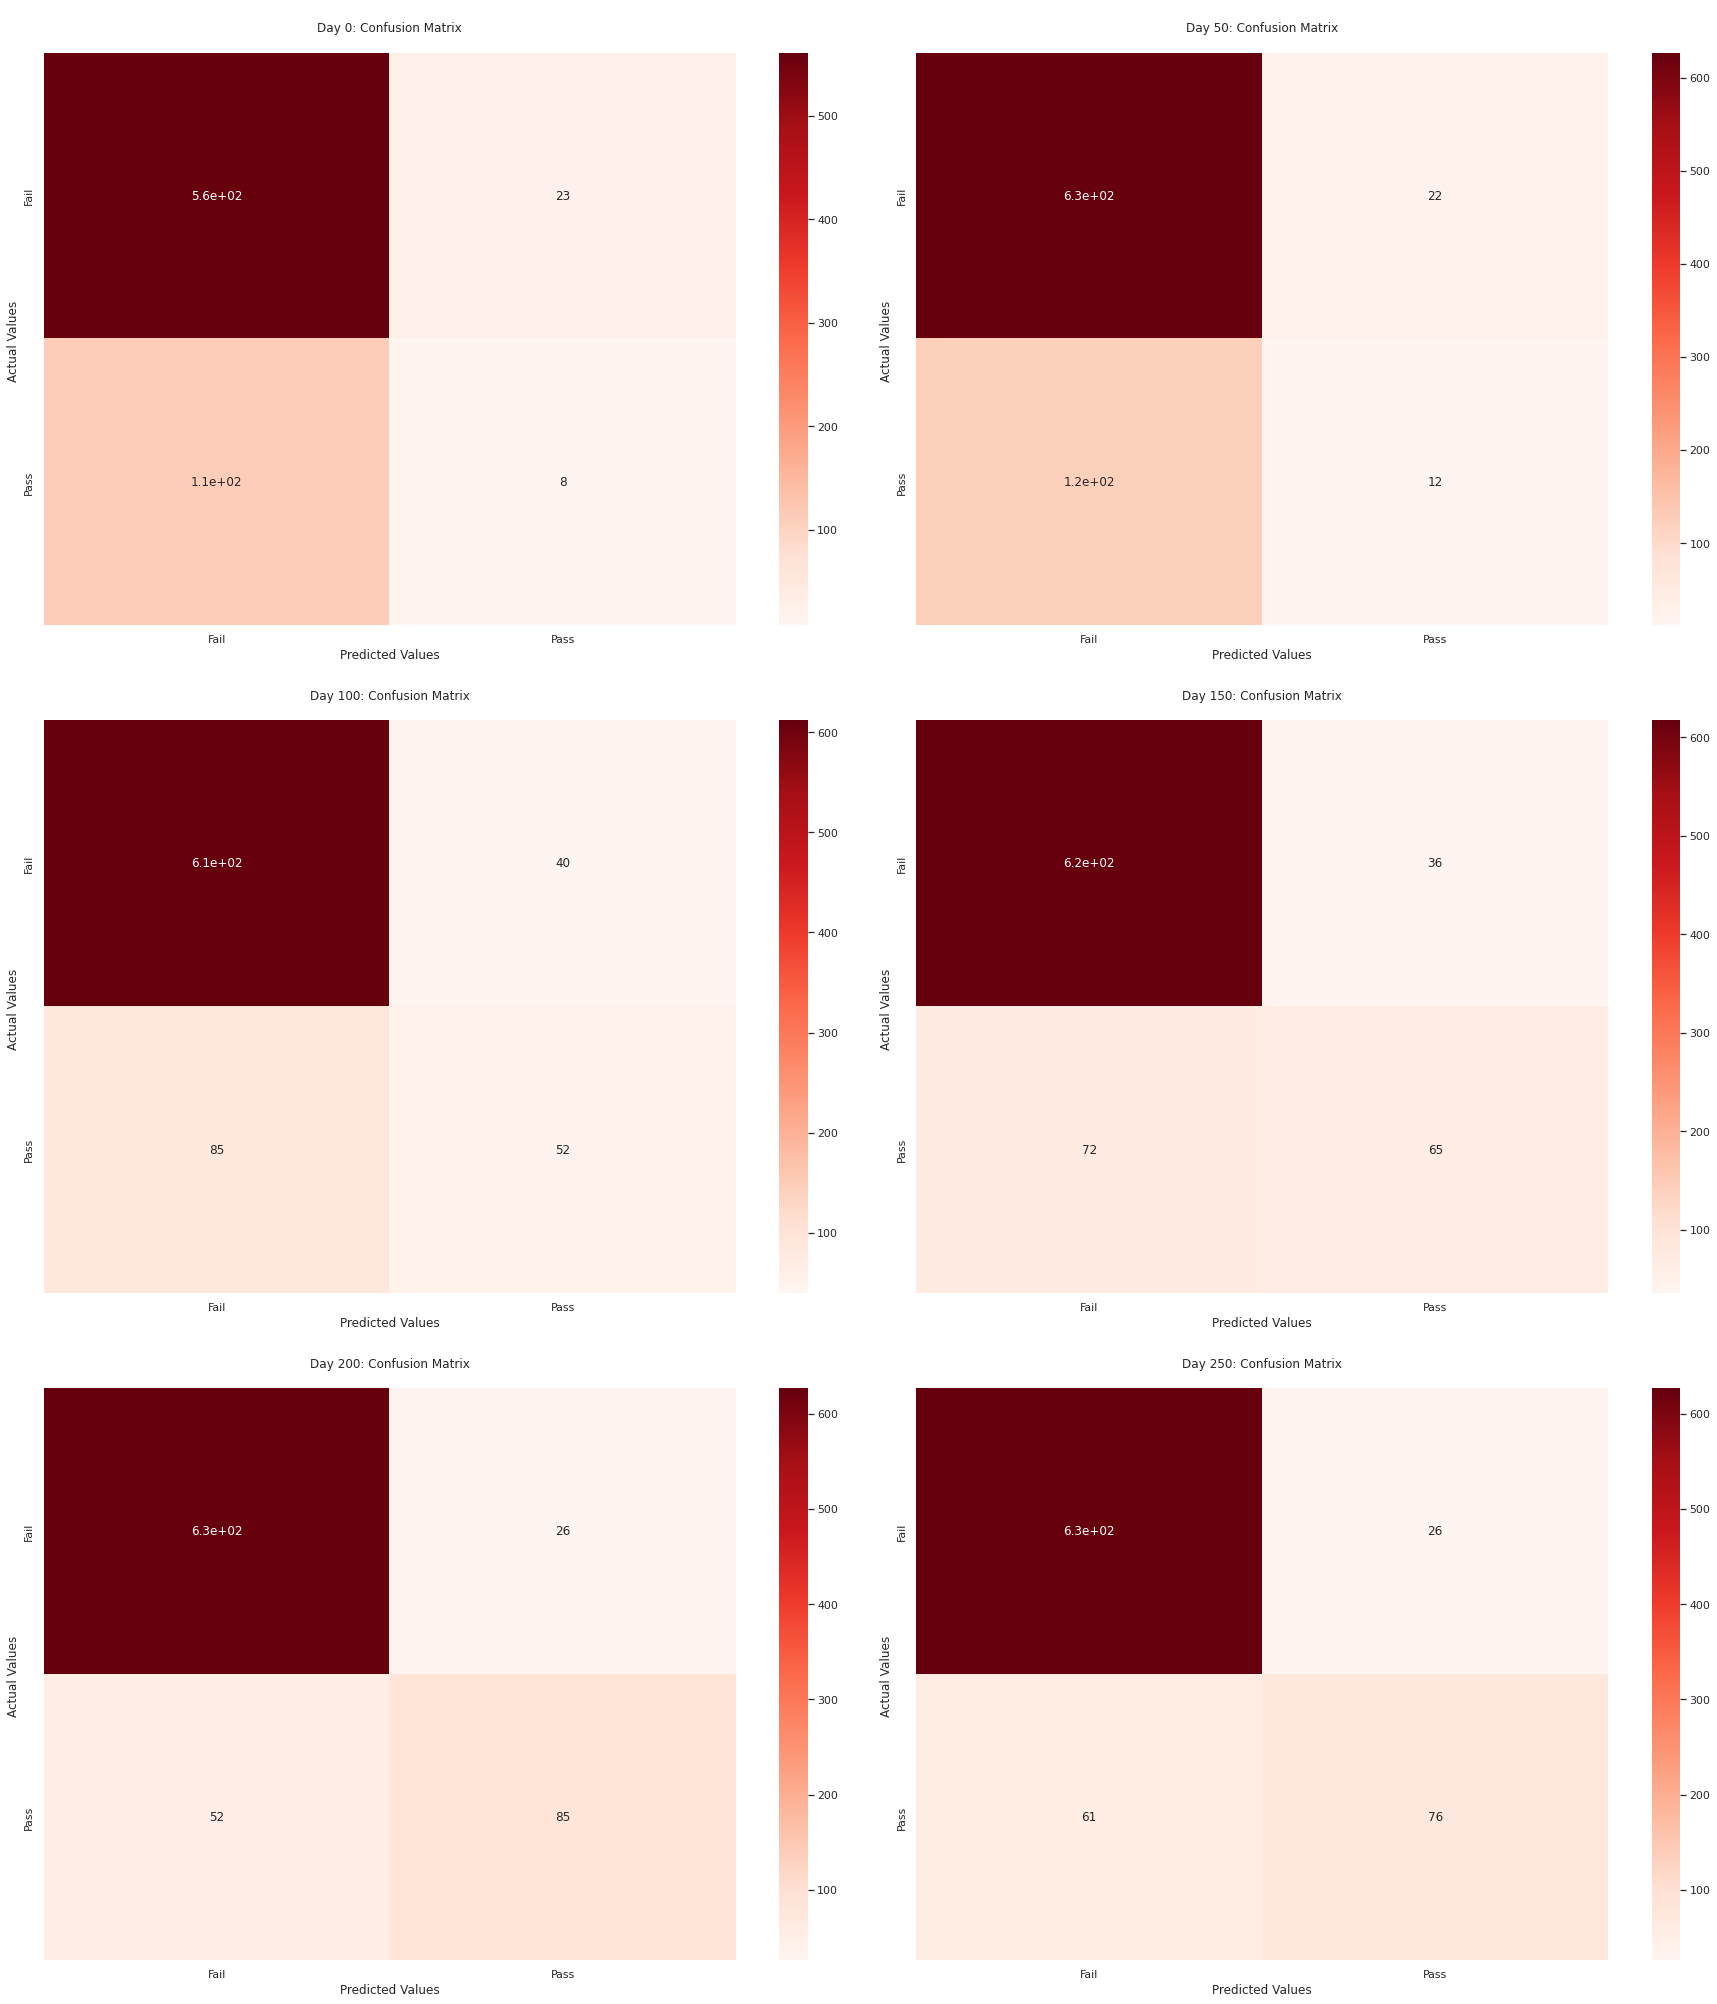

In [ ]:
plot_confusion_matrix(all_results_ab)

##### Plot results overview

In [ ]:
all_classifier_results = [all_results_du, all_results_nb, all_results_lr, all_results_lrw, all_results_rf, all_results_ab]
all_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

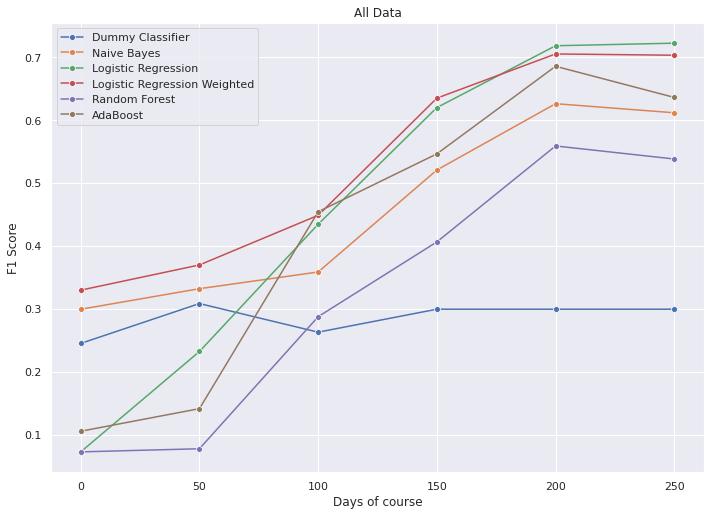

In [ ]:
plot_days_compare(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

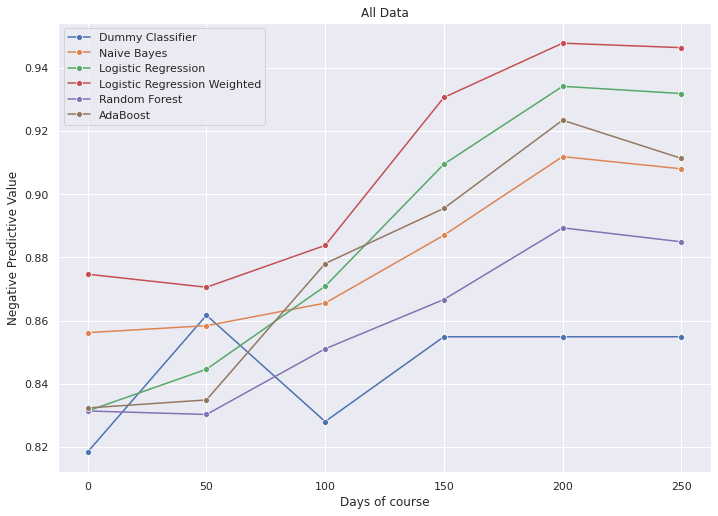

In [ ]:
plot_days_compare_npv(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

#### Three classifiers

In [ ]:
confusion_matrix_combine_three = []
keys= list(df)

for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine_three.append(np.zeros([2,2]))

  for j in range(len(all_results_predict_lr[i])):
    sum_predict = all_results_predict_lr[i][j] + all_results_predict_rf[i][j] + all_results_predict_ab[i][j]
    if sum_predict <= 1:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine_three[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,1] += 1
    else:
      confusion_matrix_combine_three[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine_three)):
  print(confusion_matrix_combine_three[i])

[[575.   9.]
 [116.   5.]]
[[632.  17.]
 [128.   8.]]
[[634.  18.]
 [ 96.  41.]]
[[631.  22.]
 [ 73.  64.]]
[[632.  21.]
 [ 52.  85.]]
[[636.  17.]
 [ 60.  77.]]


#### Combine Classifier Results

In [ ]:
confusion_matrix_combine = []
performance_weight = [0,0,0,0.0,0.5,0.5]
keys= list(df)


for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine.append(np.zeros([2,2]))
  for j in range(len(all_results_predict_proba_lr[i])):
    all_result = all_results_predict_proba_lr[i][j] * (1-performance_weight[i])

    if performance_weight[i] != 0:
      performance_result = performance_predict_proba_nb[i-1][j] * (performance_weight[i])
    else:
      performance_result = 0
    
    final_result = all_result + performance_result
    
    if final_result[0]>0.55:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine[i][0,1] += 1
    else:
      confusion_matrix_combine[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine)):
  print(confusion_matrix_combine[i])

[[564.  20.]
 [109.  12.]]
[[618.  31.]
 [113.  23.]]
[[630.  22.]
 [ 91.  46.]]
[[620.  33.]
 [ 60.  77.]]
[[618.  35.]
 [ 44.  93.]]
[[622.  31.]
 [ 45.  92.]]
